# Project : Screening and selection of candidates

## Introduction

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import import_ipynb
import spacy
import re

import NLP as nlp_functions
import Plotting as plotting_functions
import Clustering as clust
import Utilities as general_utilities

from datetime import date,datetime, timedelta
from dateutil.relativedelta import relativedelta

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

importing Jupyter notebook from NLP.ipynb
importing Jupyter notebook from Plotting.ipynb
importing Jupyter notebook from Clustering.ipynb
importing Jupyter notebook from Utilities.ipynb


<string>:1: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.


In [2]:
# GLOBAL VARIABLES
RAW_DATASET_FOLDER="rawDatasets"
DATASET_FOLDER="dataset"

### Loading Dataset

In [3]:
# Read cv data from file

#Each row is a JSON object representing the cv of a candidate

data = []  # List to store the JSON objects 

with open(RAW_DATASET_FOLDER+'/us_person_profile.txt', 'r') as file:
    for line in file:
        json_obj = json.loads(line)
        data.append(json_obj)

print("Raw Dataset loaded!  "+str(datetime.now()))

Raw Dataset loaded!  2023-06-26 21:27:32.226825


In [151]:
#Read one job posting from the specific dataset

df1= pd.read_csv(RAW_DATASET_FOLDER+'/fake_job_postings.csv')

#I decided to choose one in the field of Software Engineering.
select=df1[(df1['department'] == 'Engineering') & (df1['fraudulent'] == 0) & ("Software Engineer" == df1["title"]) ]
select.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
1242,1243,Software Engineer,NaN,Engineering,NaN,NaN,UI engineeringMachine learningWeb engineeringS...,NaN,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
1991,1992,Software Engineer,"GR, I, Athens",Engineering,NaN,Upstream’s mission is to revolutionise the way...,As a Software Engineer you will be part of a h...,"Knowledge, Skills and ExperienceBSc/MSc in Com...",Salary &amp; BenefitsWe offer a very competiti...,0,1,1,Full-time,Mid-Senior level,Master's Degree,Telecommunications,Engineering,0
4875,4876,Software Engineer,"US, CA, Mountain View",Engineering,70-120,NaN,We're looking for a software engineer with exp...,1-2 years of relevant experience.,"Competitive salary, food.",1,0,0,Full-time,Entry level,Bachelor's Degree,Internet,Engineering,0
9396,9397,Software Engineer,"US, MA, Boston",Engineering,NaN,Meet our team on the About pageRead about empl...,"Our engineering team is small, remote and resp...",About YouYou became an engineer because you li...,Work anywhere - work from our office in Boston...,1,1,1,Full-time,Not Applicable,Unspecified,Internet,Engineering,0
12196,12197,Software Engineer,"US, CA, Menlo Park",Engineering,NaN,Transifex is a SaaS continuous localization pl...,Transifex is seeking an experienced Software E...,Bachelor’s degree in Computer Science or relat...,"Transifex is a Menlo Park, Calif. based compan...",0,1,1,Full-time,Associate,Bachelor's Degree,Information Technology and Services,Engineering,0


In [152]:
# Selecting a specific company
select=df1[(df1['job_id'] == 12197) ]
select
select.iloc[0]["requirements"]

'Bachelor’s degree in Computer Science or related field (or equivalent degree and experience). At least 3 years of experience in Software Development and\xa0Development Stack: Django, Python would be nice. Experience with design patterns and code architecture. A passion for performance and scalability. Strong programming abilities in Python. We write Python on top of Django. Know how to write and maintain unit and system tests in Python. Knowledge of databases internals. We use PostgreSQL. Experience with Memcached, Redis, MongoDB, SOLR, Riak, Celery or Rabbitmq is a plus.'

In [6]:
to_be_stored={
    "raw_job_posting":select.iloc[0]["requirements"],
    "pre_process_job_posting":""
}
df = pd.DataFrame(to_be_stored,index = [0])

In [7]:
df.to_csv(DATASET_FOLDER+'/dataset_job.csv', index=False)
df

,raw_job_posting,pre_process_job_posting
0,Bachelor’s degree in Computer Science or relat...,


## Let's start : Preprocessing

### Data extraction 

In [4]:
#Function to extract meaningful data from the raw dataset file containing rows of json linkeding profile
def build_meaningful_data(elem):
    app={}
    app['full_name']=elem['full_name']
    app['languages']=elem['languages']
    app['country']=elem['country']
    app['working']=1 if (elem['occupation']!=None and elem['occupation'].strip() != "") else 0

    app['travelling_experiences']=0
    app['working_experiences']=len(elem["experiences"])

    date_diff=timedelta(days=0)
    minDate=date.max
    maxDate=date.min
    
    list_places=[]

    #Sort in cronological order the starting of a new job
    for item in elem["experiences"]:
        if(item["starts_at"]!=None):
            sortedDate=date(item["starts_at"]['year'],item["starts_at"]['month'],item["starts_at"]['day'])
            item["sortedDate"]=sortedDate
        else:
            item["sortedDate"]=date.today()
        
    sorted_list = sorted(elem["experiences"], key=lambda x: x['sortedDate'])
    #If there is some working experience and the last ends_at is empty and the person is actually working then the end_at is today.
    if (len(sorted_list)>0 and sorted_list[len(sorted_list)-1]['ends_at']==None and app['working']==1):
        obj=datetime.now()
        sorted_list[len(sorted_list)-1]['ends_at']={'day': int(obj.strftime('%d')), 'month': int(obj.strftime('%m')), 'year': int(obj.strftime('%Y'))}  

    elem["experiences"]=sorted_list
    
    for i in range(len(elem["experiences"])-1, -1, -1):
        #print (i)
       
        end_at=elem["experiences"][i]['ends_at']
        starts_at=elem["experiences"][i]['starts_at']

        if (starts_at != None):
            date_start=date(starts_at['year'],starts_at['month'],starts_at['day'])
            if (minDate>date_start):  #storing the min date for cases in which some range is missing or overlapped
                minDate=date_start
        else:
            date_start=date.today()
        if (end_at != None):
            date_end=date(end_at['year'],end_at['month'],end_at['day'])
        else:
            date_end=date_start+ relativedelta(months=1) #Case of no date_end specified. Supposing working at least 1 month.
        
        if (maxDate<date_end): #storing the min date for cases in which some range is missing or overlapped
            maxDate=date_end
        
        date_diff += date_end - date_start

        if (elem["experiences"][i]['location'] !=None and elem["experiences"][i]['location'] not in list_places ):
            list_places.append(elem["experiences"][i]['location'])

        #print(str(date_start)+" "+str(date_end))

    date_diff_2=maxDate-minDate
    yearsExperience=round(((date_diff.days)/365),2)
    approxExperience=round((int(date_diff_2.days)/365),2)
    
    #Handle overlapped ranges(start-end) of works 
    if (yearsExperience>approxExperience and approxExperience>0):
        app['years_working_experience']=approxExperience
    else:
        app['years_working_experience']=yearsExperience
    
    app['certifications']=len(elem["certifications"])
    app['university']=0

    num_of_degrees=0
    for i in range(len(elem["education"])-1, -1, -1):
        schoolName=elem["education"][i]["school"]
        if ("university" in schoolName.lower()):
            app['university']=1
        if (elem["education"][i]["degree_name"] != None):
            num_of_degrees=num_of_degrees+1

    app['num_of_degrees']=num_of_degrees
    if (app['university']==0 and app['num_of_degrees']>0):
        app['university']=1 #Peraphs it's write in other language

    app['accomplishment_projects']=len(elem["accomplishment_projects"])
    app['accomplishment_courses']=len(elem["accomplishment_courses"])
    app['accomplishment_patents']=len(elem["accomplishment_patents"])


    #Text part
    summary=elem["summary"] if elem["summary"]!=None else ""

    educationalSkills=""
    for i in range(len(elem["education"])-1, -1, -1):
        nameOfDegree=elem["education"][i]["degree_name"] if elem["education"][i]["degree_name"]!=None else ""
        educationalSkills+=nameOfDegree+str("; ")

    workingSkills=""
    for i in range(len(elem["experiences"])-1, -1, -1):
        titleExp=elem["experiences"][i]["title"] if elem["experiences"][i]["title"]!=None else ""
        descrExp=elem["experiences"][i]["description"] if elem["experiences"][i]["description"]!=None else ""
        workingSkills+=titleExp+ str(". ")+descrExp+ str(". ")

    projExpSkills=""
    for i in range(len(elem["accomplishment_projects"])-1, -1, -1):
        descrExp=elem["accomplishment_projects"][i]["description"] if elem["accomplishment_projects"][i]["description"]!=None else ""
        projExpSkills+=descrExp+ str(". ")

    app['skills_descriptions']=summary+" "+educationalSkills+" "+workingSkills+" "+projExpSkills
    
    return app

In [5]:
#Build list of cv data
list_dict=[]
for elem in data:
    list_dict.append(build_meaningful_data(elem)) 

In [6]:
#Example of information extracted
data[3]

{'public_identifier': 'a-a-cabrera',
 'profile_pic_url': 'https://media-exp1.licdn.com/dms/image/C4E03AQGF7kesjc0_jg/profile-displayphoto-shrink_200_200/0/1517476168744?e=2147483647&v=beta&t=2HEgOVWM9vwXZ6upGRA3_p6CGM9vE5WHeuWfpI7HDms',
 'background_cover_image_url': 'https://static-exp1.licdn.com/sc/h/5q92mjc5c51bjlwaj3rs9aa82',
 'first_name': 'Alex',
 'last_name': 'Cabrera',
 'full_name': 'Alex Cabrera',
 'occupation': 'Research Intern at Apple',
 'headline': 'PhD Student at Carnegie Mellon University',
 'summary': None,
 'country': 'US',
 'country_full_name': 'United States of America',
 'city': 'Fairfax County',
 'state': 'Virginia',
 'experiences': [{'starts_at': {'day': 1, 'month': 5, 'year': 2016},
   'ends_at': {'day': 31, 'month': 8, 'year': 2016},
   'company': 'Google',
   'company_linkedin_profile_url': 'https://www.linkedin.com/company/google',
   'title': 'Engineering Practicum Intern',
   'description': None,
   'location': None,
   'logo_url': 'https://media-exp1.licdn.

In [7]:
#Example of what is extracted from the previous raw data
build_meaningful_data (data[3])

{'full_name': 'Alex Cabrera',
 'languages': ['English', 'Spanish', 'French'],
 'country': 'US',
 'working': 1,
 'travelling_experiences': 0,
 'working_experiences': 5,
 'years_working_experience': 1.75,
 'certifications': 0,
 'university': 1,
 'num_of_degrees': 2,
 'accomplishment_projects': 3,
 'accomplishment_courses': 0,
 'accomplishment_patents': 0,
 'skills_descriptions': " Bachelor's degree; Doctor of Philosophy - PhD;  Research Intern. AI/ML. Research Intern. . Software Engineering Intern. . Software Engineering Intern. . Engineering Practicum Intern. .  Python app that creates minimalistic icons from text, similar to those found on GitHub. Available on the Python Package Index and has over 360 downloads.. Crowdsourced repository for information security guides and resources. Over 30 views a day on average, with peaks of over 150 views and 160 stars on GitHub.. Full-stack web application created to help facilitate the communication between and rankings of Model United Nations co

### Data Cleaning

In [8]:
# Cleaning and adaptation of the languages 

# Removing from language fields all the words that not corresponding to a real language
# and adapt some of the languages written in non english traslation to english version.

# The languages considered are the most common 9 and the remaining are grouped in a common language denoted as 'other'.

diff_languages_original=set()
diff_languages=set()

LANG_EN='English'
LANG_IT='Italian'
LANG_FR='French'
LANG_SP='Spanish'
LANG_DE='German'
LANG_CH='Chinese'
LANG_JP='Japanese'
LANG_IN='Indian'
LANG_RU='Russian'

LANG_OT='Other'

TO_BE_REMOVED="TO_BE_REMOVED"

BLACK_LIST=["Medical Terminology",
            "VisualForce",
            "Apex",
            "American Sign Language",
            "BI Publisher 11g",
            "Berber languages",
            "American Sign Language",
            "Local Dialects of Sub-Continent",
            "OBIEE 11g",
            "Klingon",
            "Asl", 
            "Javascript",
            "Informatica",
            "SQL",
            "American Sign Language (ASL)",
            "SQL Server",
            "MySql",
            "\"Business Owner\"",
            "gesture any lanuage",
            "Sign Languages",
            "Microsoft SSIS",
            "C++",
            "Java",
            "Chatbot",
            "CSS",
            "HTML",
           ]

for elem in list_dict:
    
    for i in range(len(elem["languages"])):
        diff_languages_original.add(elem["languages"][i])
        current_lang=elem["languages"][i]
        
        if ('franc' in current_lang.lower() or 
            'frenc' in current_lang.lower() or
            'frans' in current_lang.lower() or 
            'franç' in current_lang.lower() or
            'franz' in current_lang.lower() or
            'Французский' in current_lang or
            'الفرنسية' in current_lang
           ):
            elem["languages"][i]=LANG_FR
            #print (elem["full_name"])
            diff_languages.add(LANG_FR)
            continue
            
        if ('chin' in current_lang.lower() or
           'fuzho' in current_lang.lower()):   
            #print (elem["full_name"])
            #print(elem["languages"][i])
            elem["languages"][i]=LANG_CH
            diff_languages.add(LANG_CH)
            continue
            
        if ('span' in current_lang.lower() or 
            'españ' in current_lang.lower() or
            'hiszpański'in current_lang.lower() or
            'espag' in current_lang.lower() or
            'spagn' in current_lang.lower() or 
            'Испанский' in current_lang or 
            'catal' in current_lang.lower()):
            #print (elem["full_name"])
            #print(elem["languages"][i])
            elem["languages"][i]=LANG_SP
            diff_languages.add(LANG_SP) 
            continue
            
        if ('eng' in current_lang.lower() or
            'anglais' in current_lang.lower() or
            'ingl' in current_lang.lower() or 
            'angiel' in current_lang.lower() or
            'aнглийский' in current_lang.lower() or
            'angulais' in current_lang.lower() or
            'İngilizce'.lower() in current_lang.lower() or
            'krio' in current_lang.lower() or 
            'Английский' in current_lang
           ):
            
            #print (elem["full_name"])
            #print(elem["languages"][i])
            elem["languages"][i]=LANG_EN
            diff_languages.add(LANG_EN)
            continue
        
        if ('germ' in current_lang.lower() or
            'deuts' in current_lang.lower() or
            'tedes' in current_lang.lower() or
            'yiddish' in current_lang.lower() or
            'Немецкий' in current_lang or
            'allema' in current_lang.lower() or
            'duits' in current_lang.lower()
           ):
            #print (elem["full_name"])
            #print(elem["languages"][i])
            elem["languages"][i]=LANG_DE
            diff_languages.add(LANG_DE)
            continue
        
        if ('ita' in current_lang.lower() 
           ):
            #print (elem["full_name"])
            #print(elem["languages"][i])
            elem["languages"][i]=LANG_IT
            diff_languages.add(LANG_IT)
            continue
        
        if ('indi' in current_lang.lower() or
            'bhatkali' in current_lang.lower() or
            'malayalam' in current_lang.lower() or
            'hind' in current_lang.lower() or
            'punja' in current_lang.lower() or
            'konka' in current_lang.lower() or
            'maithili' in current_lang.lower() or
            'indo' in current_lang.lower() or
            'gujrati' in current_lang.lower()
           ):
            #print (elem["full_name"])
            #print(elem["languages"][i])
            elem["languages"][i]=LANG_IN
            diff_languages.add(LANG_IN)
            continue
       
        if ('Русский' == current_lang or
           'rus' in current_lang.lower() 
           ):
            #print (elem["full_name"])
            #print(elem["languages"][i])
            elem["languages"][i]=LANG_RU
            diff_languages.add(LANG_RU)
            continue
            
        if ('jap' in current_lang.lower() 
          ):
            #print (elem["full_name"])
            #print(elem["languages"][i])
            elem["languages"][i]=LANG_JP
            diff_languages.add(LANG_JP)
            continue
        
        if (current_lang in BLACK_LIST):
            elem["languages"][i]=TO_BE_REMOVED
        else:
            elem["languages"][i]=LANG_OT
    
    for lang in elem["languages"]:
        if (lang==TO_BE_REMOVED):
            elem["languages"].remove(lang)
            
#diff_languages_original.remove(TO_BE_REMOVED)        
print(diff_languages_original)


{'Malinke', 'Português', 'Армянский', 'Informatica', 'Setswana (Botswana)', 'Kyrgyz', 'Dansk', 'Alemán', 'rosyjski', 'Swahili', 'Korean (learning)', 'Rusça', 'Somali', 'Lao', 'Ukrainian', 'Welsh', 'Spanish ( beginner)', 'Old English', 'Français (maternelle)', 'Valenciano', 'Thai', 'CSS', 'Tagalog', 'Urdo', 'Filipino - Ilocano', 'الإنجليزي', 'OBIEE 11g', 'VisualForce', 'Japanesse', 'German (basic)', 'Italienisch', 'engels', 'Gypsy', 'Duits', 'English, Middle (1100-1500)', 'Fuzhounese', 'German - Level B1', 'Language to learn next? Spanish looks interesting!', 'tamazight', 'İngilizce, Orta (1100-1500)', 'Castellano', 'Albanian', 'Francés', 'Chinese(Cantonese)', 'ua', 'الفرنسية', 'Georgian', 'Malay', 'Alemão', 'Haitian Creole', 'Spagnolo', 'Spanish (conversational)', 'Mandarin Chinese (Level 1)', 'Английский язык', 'Pushto', 'English (IELTS 8.0)', 'Tagalog (pilipino)', 'Китайский', 'Filipino', 'Bhatkali', 'Amharic', 'SQL Server', 'Испанский', 'Slovak', 'Russe', 'Romanian', 'German - Level

In [9]:
# Handling missing values for (languages)

# In some CV the languages list is empty so the information may be inferred from the country.
count=0
for elem in list_dict:
    if (len(elem["languages"])==0):
        #print(elem["full_name"] )
        count+=1
        
        if (elem["country"]=="US" or elem["country"]=="UK"):
            elem["languages"].append(LANG_EN)
            continue
        
        if (elem["country"]=="ES"):
            elem["languages"].append(LANG_SP)
            continue
            
        if (elem["country"]=="IT"):
            elem["languages"].append(LANG_IT)
            continue

        if (elem["country"]=="FR"):
            elem["languages"].append(LANG_FR)
            continue
        
        if (elem["country"]=="DE"):
            elem["languages"].append(LANG_DE)
            continue
        
        if (elem["country"]=="CH"):
            elem["languages"].append(LANG_CH)
            continue
        
        if (elem["country"]=="JP"):
            elem["languages"].append(LANG_JP)
            continue
            
        if (elem["country"]=="IN"):
            elem["languages"].append(LANG_IN)
            continue
            
        if (elem["country"]=="RU"):
            elem["languages"].append(LANG_RU)
            continue      

        elem["languages"].append(LANG_OT)

print (count)

6344


{'US': 8959, 'SA': 112, 'IN': 98, 'RU': 96, 'NL': 57, 'ES': 56, 'FR': 44, 'EG': 40, 'IT': 38, 'AE': 36, 'IR': 31, 'PL': 31, 'TR': 28, 'DK': 28, 'PE': 22, 'CH': 20, 'BR': 18, 'UK': 17, 'DE': 15, 'MX': 15, 'PK': 15, 'CA': 13, 'FI': 12, 'CL': 9, 'KR': 8, 'SE': 8, 'MA': 8, 'ID': 8, 'KW': 7, 'PS': 7, 'CN': 6, 'VE': 6, 'PT': 5, 'TH': 5, 'BD': 5, 'NO': 5, 'JO': 5, 'AT': 5, 'BH': 4, 'CZ': 4, 'BO': 4, 'TW': 4, 'NP': 4, 'AR': 4, 'MY': 4, 'AU': 4, 'PH': 4, 'SY': 3, 'VN': 3, 'GR': 3, 'JP': 3, 'BE': 3, 'MU': 3, 'QA': 3, 'HK': 3, 'DO': 2, 'CY': 2, 'UA': 2, 'GE': 2, 'CO': 2, 'OM': 2, 'CR': 2, 'LK': 2, 'IL': 1, 'DZ': 1, 'EC': 1, 'ZM': 1, 'BY': 1, 'SD': 1, 'TN': 1, 'MK': 1, 'MD': 1, 'AM': 1, 'VI': 1, 'CF': 1, 'HU': 1, 'KZ': 1, 'LR': 1, 'MG': 1, 'SG': 1, 'MT': 1, 'IE': 1, 'IQ': 1, 'LU': 1, 'YE': 1, 'RS': 1, 'CI': 1, 'EE': 1, 'MZ': 1}



{'US': 8959, 'Others': 1041}


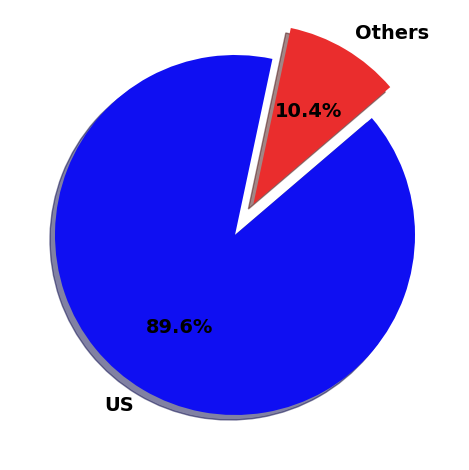

In [9]:
# Analisis on the available data

# Althougth the downloaded dataset was garanteed to be populated with people from USA
# there is about 10% of people that are not from USA.

def obtain_dict_languages(list_dict):
    dict_languages={}
    conta=0
    for elem in list_dict:
        if (elem["country"] in dict_languages):
            dict_languages[elem["country"]]+=1
        else:
            dict_languages[elem["country"]]=1
    return dict_languages
            
dict_languages=obtain_dict_languages(list_dict)

#Here is a ranked list countries  ordered by descending order from the most frequency to the less frequency
print({k: v for k, v in sorted(dict_languages.items(), key=lambda item: item[1],reverse=True)}) 
print("\n\n")
dict_languages_reducted={"US": sum(value for key,value in dict_languages.items() if key == "US"), "Others": sum(value for key,value in dict_languages.items() if key != "US")}
print(dict_languages_reducted)

labels = 'US', 'Others'
sizes = [dict_languages["US"], sum(value for key,value in dict_languages.items() if key != "US")]
explode = (0, 0.2)  
colors = ['#0f0ff2','#ea2d2d']
        
fig, ax = plt.subplots()
#ax.pie(sizes, labels=labels, autopct='%1.1f%%')
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',colors=colors,
        shadow=True, startangle=78,textprops={'fontsize':14,'fontweight':'bold'})
plt.tight_layout()
plt.show()


In [10]:
#Here an example of CV of a person originated from Russia.
#The skills_descriptions is in Russian languages.
list_dict[407]

{'full_name': 'Alexander Cheremnykh',
 'languages': ['Russian', 'English'],
 'country': 'RU',
 'working': 1,
 'travelling_experiences': 0,
 'working_experiences': 3,
 'years_working_experience': 27.42,
 'certifications': 0,
 'university': 1,
 'num_of_degrees': 1,
 'accomplishment_projects': 0,
 'accomplishment_courses': 0,
 'accomplishment_patents': 0,
 'skills_descriptions': 'В настоящее время работаю на должности Биолога в Клинико-диагностической лаборатории Генетической клиники одного из ведущих медико-генетических центров России «НИИ медицинской генетики». \n\nОсновное направление моей деятельности: проведение различных вариантов FISH-диагностики с целями поиска или верификации наследственной патологии. Владею практически всем спектром модификаций FISH: mFISH, mBand, WCP, CGH, SKY и др. Исследуемые ткани: амниоциты, хорион, костный мозг, буккальный эпителий, пуповинная и периферическая кровь. \n\nДо перехода в Генетическую клинику работал в научном коллективе этого же института: ла

### Data Reduction

In [11]:
#Numerosity reduction

#Removing all CV with country different from US in order to have cleaner data for the further phase of NLP.
copy_list = list_dict.copy()

for elem in copy_list:
    if (elem["country"] !="US"):
        list_dict.remove(elem)

dict_languages=obtain_dict_languages(list_dict)
        
dict_languages_reducted={"US": sum(value for key,value in dict_languages.items() if key == "US"), "Others": sum(value for key,value in dict_languages.items() if key != "US")}
print(dict_languages_reducted)  

for elem in list_dict:
    del elem["country"]
        

{'US': 8959, 'Others': 0}


### Data Transformation: Attribute Construction

In [12]:
# One hot encoding of the languages variable

# Transforming the languages list in one hot vector.

for elem in list_dict:
    
    if (LANG_EN in elem["languages"]):
        elem["LANG_EN"]=1
    else:
        elem["LANG_EN"]=0
        
    if (LANG_IT in elem["languages"]):
        elem["LANG_IT"]=1
    else:
        elem["LANG_IT"]=0
    
    if (LANG_FR in elem["languages"]):
        elem["LANG_FR"]=1
    else:
        elem["LANG_FR"]=0
    
    if (LANG_SP in elem["languages"]):
        elem["LANG_SP"]=1
    else:
        elem["LANG_SP"]=0
    
    if (LANG_DE in elem["languages"]):
        elem["LANG_DE"]=1
    else:
        elem["LANG_DE"]=0
        
    if (LANG_CH in elem["languages"]):
        elem["LANG_CH"]=1
    else:
        elem["LANG_CH"]=0
    
    if (LANG_JP in elem["languages"]):
        elem["LANG_JP"]=1
    else:
        elem["LANG_JP"]=0
    
    if (LANG_IN in elem["languages"]):
        elem["LANG_IN"]=1
    else:
        elem["LANG_IN"]=0
    
    if (LANG_RU in elem["languages"]):
        elem["LANG_RU"]=1
    else:
        elem["LANG_RU"]=0
    
    if (LANG_OT in elem["languages"]):
        elem["LANG_OT"]=1
    else:
        elem["LANG_OT"]=0
    
    del elem["languages"]


In [13]:
# Store the new dataset

df = pd.DataFrame(list_dict)
#df.to_csv(DATASET_FOLDER+'/dataset.csv', index=False)
#df = pd.read_csv(DATASET_FOLDER+'/dataset.csv')

### Outliers Analisis

In [14]:
# Before acting NLP, an additional analysis phase on cleaned data is done in order to understand if the current outliers
# must be considered good data or noise.
df

,full_name,working,travelling_experiences,working_experiences,years_working_experience,certifications,university,num_of_degrees,accomplishment_projects,accomplishment_courses,...,LANG_EN,LANG_IT,LANG_FR,LANG_SP,LANG_DE,LANG_CH,LANG_JP,LANG_IN,LANG_RU,LANG_OT
0,Jeff B.,1,0,5,25.50,2,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Abdulaziz Alyahya,0,0,0,0.00,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Andrew Bailey,1,0,4,14.49,0,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Alex Cabrera,1,0,5,1.75,0,1,2,3,0,...,1,0,1,1,0,0,0,0,0,0
4,Alcino de Oliveira Manuel,1,0,1,2.90,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8954,Aaron Dominowski,0,0,0,0.00,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8955,"Aaron Dominy, MBA",1,0,8,15.05,3,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
8956,Aaron Williams,1,0,16,22.17,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8957,Aaron Dona,1,0,8,8.15,0,1,3,1,19,...,0,0,0,0,0,0,0,0,0,0


In [15]:
df.describe()

,working,travelling_experiences,working_experiences,years_working_experience,certifications,university,num_of_degrees,accomplishment_projects,accomplishment_courses,accomplishment_patents,LANG_EN,LANG_IT,LANG_FR,LANG_SP,LANG_DE,LANG_CH,LANG_JP,LANG_IN,LANG_RU,LANG_OT
count,8959.000000,8959.0,8959.000000,8959.000000,8959.000000,8959.000000,8959.00000,8959.000000,8959.000000,8959.000000,8959.000000,8959.000000,8959.000000,8959.000000,8959.000000,8959.000000,8959.000000,8959.000000,8959.000000,8959.000000
mean,0.895301,0.0,5.465454,10.827952,1.259292,0.850876,1.72363,0.600067,1.688135,0.042750,0.292890,0.009376,0.046211,0.117201,0.020761,0.009711,0.008371,0.094653,0.013729,0.145775
std,0.306183,0.0,3.943776,8.820536,2.997034,0.356230,1.29504,2.193834,5.050832,0.591544,0.455114,0.096380,0.209952,0.321677,0.142592,0.098070,0.091117,0.292752,0.116371,0.352900
min,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.0,3.000000,4.570000,0.000000,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.0,5.000000,9.160000,0.000000,1.000000,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.0,8.000000,15.490000,1.000000,1.000000,2.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,0.0,84.000000,123.560000,44.000000,1.000000,29.00000,61.000000,50.000000,25.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
#At first look it seems that there are some people with experiences longer than their life 
#so in order to have a cleaner dataset some situatuation are analyzed deeper.
#Ex. record with years_working_experience > 40
select=df[(df["years_working_experience"]>40)]
select

,full_name,working,travelling_experiences,working_experiences,years_working_experience,certifications,university,num_of_degrees,accomplishment_projects,accomplishment_courses,...,LANG_EN,LANG_IT,LANG_FR,LANG_SP,LANG_DE,LANG_CH,LANG_JP,LANG_IN,LANG_RU,LANG_OT
64,Media America,1,0,1,49.77,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
339,A.Christine Pfeffer,1,0,4,45.51,0,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
716,Avner Hershlag MD,1,0,14,47.52,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
738,A. Howard Matz,1,0,5,49.52,0,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
782,A.J. Ewell,1,0,13,53.10,20,1,2,3,50,...,0,0,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7178,Holly Hough,1,0,5,43.43,0,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
7271,Anthony Arguello,1,0,7,40.51,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
7275,Daniel Dunn,1,0,6,41.51,0,1,1,2,0,...,0,0,0,0,0,0,0,0,0,0
7512,Andy Arkusinski,1,0,3,46.10,0,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
#Additional data-reduction: removing inconsistencies.

#Drop all record of associations,communities, companies and people that set wrong some date_start - date_end period of work
#Preserving all that are real outliers from data that instead are noise.
#This operation has been done by manually inspecting.

df = df.drop([64, 1007,1697,2068,2322,2643,2753,3304,3480,3855,5633,5744,6460,6783])
df.describe()

,working,travelling_experiences,working_experiences,years_working_experience,certifications,university,num_of_degrees,accomplishment_projects,accomplishment_courses,accomplishment_patents,LANG_EN,LANG_IT,LANG_FR,LANG_SP,LANG_DE,LANG_CH,LANG_JP,LANG_IN,LANG_RU,LANG_OT
count,8945.000000,8945.0,8945.000000,8945.000000,8945.000000,8945.000000,8945.000000,8945.000000,8945.000000,8945.000000,8945.000000,8945.000000,8945.000000,8945.000000,8945.000000,8945.000000,8945.000000,8945.000000,8945.000000,8945.000000
mean,0.895137,0.0,5.471884,10.749344,1.261263,0.852096,1.726216,0.600671,1.690777,0.042705,0.293348,0.009391,0.046283,0.117384,0.020794,0.009726,0.008385,0.094802,0.013751,0.146003
std,0.306394,0.0,3.943178,8.552412,2.998964,0.355025,1.294361,2.195285,5.054341,0.591918,0.455322,0.096455,0.210109,0.321895,0.142701,0.098146,0.091188,0.292957,0.116461,0.353129
min,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.0,3.000000,4.570000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.0,5.000000,9.150000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.0,8.000000,15.490000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,0.0,84.000000,60.520000,44.000000,1.000000,29.000000,61.000000,50.000000,25.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
# Inspecting people who declared 10 or more degrees: most of them had insert also certifications on that field.
select=df[(df["num_of_degrees"]>10)]
select

,full_name,working,travelling_experiences,working_experiences,years_working_experience,certifications,university,num_of_degrees,accomplishment_projects,accomplishment_courses,...,LANG_EN,LANG_IT,LANG_FR,LANG_SP,LANG_DE,LANG_CH,LANG_JP,LANG_IN,LANG_RU,LANG_OT
1324,Aslan Omer Kirimli,0,0,0,0.00,27,1,16,0,0,...,1,0,0,0,0,0,0,0,1,1
3203,Aaditya Ailawadhi,1,0,10,8.07,2,1,11,1,37,...,1,0,0,0,0,0,0,0,0,0
5853,Aamir (A.J) Qadri,1,0,11,11.24,0,1,13,0,0,...,1,0,0,0,0,0,0,0,0,0
6149,Mark T Favaloro,1,0,1,0.00,0,1,29,0,0,...,1,0,0,1,0,0,0,0,0,0
7272,Adolfo Argüello (We/Ours/Us/Nosotros),1,0,16,22.71,8,1,16,0,36,...,1,0,1,1,0,0,0,0,0,0


In [19]:
df=df.drop(select.index)
df.describe()

,working,travelling_experiences,working_experiences,years_working_experience,certifications,university,num_of_degrees,accomplishment_projects,accomplishment_courses,accomplishment_patents,LANG_EN,LANG_IT,LANG_FR,LANG_SP,LANG_DE,LANG_CH,LANG_JP,LANG_IN,LANG_RU,LANG_OT
count,8940.000000,8940.0,8940.000000,8940.000000,8940.000000,8940.000000,8940.000000,8940.000000,8940.000000,8940.000000,8940.000000,8940.000000,8940.000000,8940.000000,8940.000000,8940.000000,8940.000000,8940.000000,8940.000000,8940.000000
mean,0.895190,0.0,5.470694,10.750655,1.257830,0.852013,1.717673,0.600895,1.683557,0.042729,0.292953,0.009396,0.046197,0.117226,0.020805,0.009732,0.008389,0.094855,0.013647,0.145973
std,0.306325,0.0,3.941276,8.552308,2.986502,0.355107,1.234340,2.195858,5.028766,0.592083,0.455143,0.096482,0.209923,0.321707,0.142740,0.098173,0.091213,0.293030,0.116025,0.353099
min,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.0,3.000000,4.570000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.0,5.000000,9.150000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.0,8.000000,15.490000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,0.0,84.000000,60.520000,44.000000,1.000000,10.000000,61.000000,50.000000,25.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
#Drop all the outliers in terms of number of different working experiences done.
select=df[(df["working_experiences"]>30)]
select

,full_name,working,travelling_experiences,working_experiences,years_working_experience,certifications,university,num_of_degrees,accomplishment_projects,accomplishment_courses,...,LANG_EN,LANG_IT,LANG_FR,LANG_SP,LANG_DE,LANG_CH,LANG_JP,LANG_IN,LANG_RU,LANG_OT
368,Alex Contreras,1,0,84,10.67,0,1,1,1,2,...,1,0,0,1,0,0,0,0,0,0
3082,Aadip Desai,1,0,38,29.50,2,1,6,10,3,...,0,0,0,1,0,0,0,0,0,1
5230,AALIYAH TAYLOR,1,0,53,17.68,0,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
df=df.drop(select.index)
df

,full_name,working,travelling_experiences,working_experiences,years_working_experience,certifications,university,num_of_degrees,accomplishment_projects,accomplishment_courses,...,LANG_EN,LANG_IT,LANG_FR,LANG_SP,LANG_DE,LANG_CH,LANG_JP,LANG_IN,LANG_RU,LANG_OT
0,Jeff B.,1,0,5,25.50,2,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Abdulaziz Alyahya,0,0,0,0.00,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Andrew Bailey,1,0,4,14.49,0,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Alex Cabrera,1,0,5,1.75,0,1,2,3,0,...,1,0,1,1,0,0,0,0,0,0
4,Alcino de Oliveira Manuel,1,0,1,2.90,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8954,Aaron Dominowski,0,0,0,0.00,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8955,"Aaron Dominy, MBA",1,0,8,15.05,3,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
8956,Aaron Williams,1,0,16,22.17,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8957,Aaron Dona,1,0,8,8.15,0,1,3,1,19,...,0,0,0,0,0,0,0,0,0,0


In [22]:
df.describe()

,working,travelling_experiences,working_experiences,years_working_experience,certifications,university,num_of_degrees,accomplishment_projects,accomplishment_courses,accomplishment_patents,LANG_EN,LANG_IT,LANG_FR,LANG_SP,LANG_DE,LANG_CH,LANG_JP,LANG_IN,LANG_RU,LANG_OT
count,8937.000000,8937.0,8937.000000,8937.000000,8937.000000,8937.000000,8937.000000,8937.000000,8937.000000,8937.000000,8937.000000,8937.000000,8937.000000,8937.000000,8937.000000,8937.000000,8937.000000,8937.000000,8937.000000,8937.000000
mean,0.895155,0.0,5.452948,10.747791,1.258028,0.851964,1.717243,0.599866,1.683563,0.042744,0.292939,0.009399,0.046212,0.117042,0.020812,0.009735,0.008392,0.094886,0.013651,0.145910
std,0.306371,0.0,3.804895,8.551129,2.986934,0.355156,1.233688,2.193961,5.029558,0.592182,0.455136,0.096498,0.209956,0.321488,0.142764,0.098189,0.091228,0.293074,0.116044,0.353036
min,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.0,3.000000,4.570000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.0,5.000000,9.150000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.0,8.000000,15.490000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,0.0,30.000000,60.520000,44.000000,1.000000,10.000000,61.000000,50.000000,25.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
# Store the new dataset
df.to_csv(DATASET_FOLDER+'/dataset.csv', index=False)

### NLP: Natural Language Processing 

In [3]:
#Load Job Posting dataset and apply NLP on job description.
df = pd.read_csv(DATASET_FOLDER+'/dataset_job.csv')

Original text:
Bachelor’s degree in Computer Science or related field (or equivalent degree and experience). At least 3 years of experience in Software Development and Development Stack: Django, Python would be nice. Experience with design patterns and code architecture. A passion for performance and scalability. Strong programming abilities in Python. We write Python on top of Django. Know how to write and maintain unit and system tests in Python. Knowledge of databases internals. We use PostgreSQL. Experience with Memcached, Redis, MongoDB, SOLR, Riak, Celery or Rabbitmq is a plus.

Cleaned text:
bachelor’s degree in computer science or related field (or equivalent degree and experience). at least 3 years of experience in software development and development stack: django, python would be nice. experience with design patterns and code architecture. a passion for performance and scalability. strong programming abilities in python. we write python on top of django. know how to write an

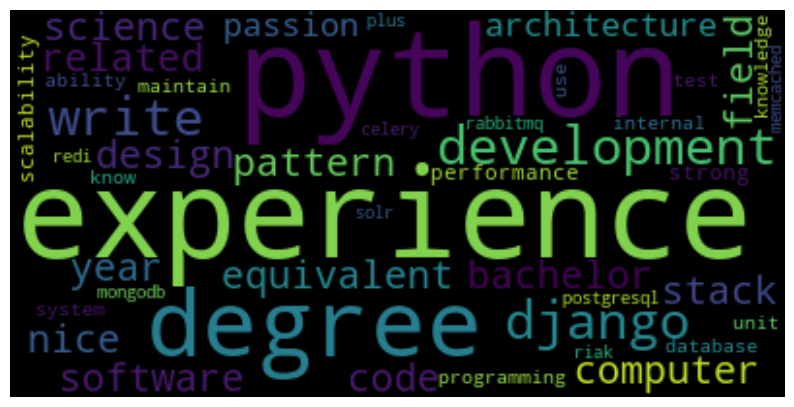

In [6]:
job_post=df.iloc[0]["raw_job_posting"]
    
newText=nlp_functions.clean_text(job_post,True)

nlp_functions.plotWordCloud(newText)

df["pre_process_job_posting"]=newText

#Update the dataset_job 
df.to_csv(DATASET_FOLDER+'/dataset_job.csv', index=False)

In [12]:
#Now that data are less
#Load the dataset of CV and the dataset containg the one just processed.

d_cv = pd.read_csv(DATASET_FOLDER+'/dataset.csv')
d_job =pd.read_csv(DATASET_FOLDER+'/dataset_job.csv')

nlp = spacy.load("en_core_web_lg")
job_requirement_doc=nlp(d_job.iloc[0]["pre_process_job_posting"])

In [8]:
#For each row in dataset apply NLP to the field skills_descriptions and compute similarity with the job posted.

for index, row in d_cv.iterrows():

        skills=row["skills_descriptions"]
        
        processedText=nlp_functions.clean_text(skills,False)
        
        cv_skills_doc=nlp(processedText)
        
        similarity=cv_skills_doc.similarity(job_requirement_doc)
          
        if (similarity<0):
            similarity=0
            
        d_cv.at[index, 'skills_processed']=processedText
        d_cv.at[index, 'similarity']=similarity
        
        print(f"Elaborated index: {index} - Similarity {similarity} \n")
  
        #nlp.plotWordCloud(processedText)
        
        print ("--------------------------------------------")

d_cv.to_csv(DATASET_FOLDER+'/dataset.csv', index=False) 

Elaborated index: 0 - Similarity 0.7679579672997731 

--------------------------------------------
Elaborated index: 1 - Similarity 0.7588415746020707 

--------------------------------------------
Elaborated index: 2 - Similarity 0.82758542754892 

--------------------------------------------
Elaborated index: 3 - Similarity 0.9367061238761932 

--------------------------------------------
Elaborated index: 4 - Similarity 0.8062652033938197 

--------------------------------------------
Elaborated index: 5 - Similarity 0.9317814697046229 

--------------------------------------------
Elaborated index: 6 - Similarity 0.892119477227472 

--------------------------------------------
Elaborated index: 7 - Similarity 0.868431748419885 

--------------------------------------------
Elaborated index: 8 - Similarity 0.8880725957737473 

--------------------------------------------
Elaborated index: 9 - Similarity 0.8342825680382888 

--------------------------------------------
Elaborated ind

C:\Users\Davide\AppData\Local\Temp\ipykernel_20536\974820192.py:9: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarity=cv_skills_doc.similarity(job_requirement_doc)


Elaborated index: 28 - Similarity 0.0 

--------------------------------------------
Elaborated index: 29 - Similarity 0.9237093634239811 

--------------------------------------------
Elaborated index: 30 - Similarity 0.8424151774551019 

--------------------------------------------
Elaborated index: 31 - Similarity 0.9211214903630431 

--------------------------------------------
Elaborated index: 32 - Similarity 0.8377231928505418 

--------------------------------------------
Elaborated index: 33 - Similarity 0.6851842188397892 

--------------------------------------------
Elaborated index: 34 - Similarity 0.8633311036719036 

--------------------------------------------
Elaborated index: 35 - Similarity 0.8915186100412762 

--------------------------------------------
Elaborated index: 36 - Similarity 0.8950219570595472 

--------------------------------------------
Elaborated index: 37 - Similarity 0.9279128617785926 

--------------------------------------------
Elaborated inde

Elaborated index: 111 - Similarity 0.9095075760850312 

--------------------------------------------
Elaborated index: 112 - Similarity 0.9526897766667678 

--------------------------------------------
Elaborated index: 113 - Similarity 0.9012641290755857 

--------------------------------------------
Elaborated index: 114 - Similarity 0.8823193066939439 

--------------------------------------------
Elaborated index: 115 - Similarity 0.6098242748400986 

--------------------------------------------
Elaborated index: 116 - Similarity 0.9069320882302548 

--------------------------------------------
Elaborated index: 117 - Similarity 0.8959267490257397 

--------------------------------------------
Elaborated index: 118 - Similarity 0.8979886714362245 

--------------------------------------------
Elaborated index: 119 - Similarity 0.886147949787914 

--------------------------------------------
Elaborated index: 120 - Similarity 0.8885578690705728 

------------------------------------

Elaborated index: 193 - Similarity 0.8916433834587034 

--------------------------------------------
Elaborated index: 194 - Similarity 0.9134003636206437 

--------------------------------------------
Elaborated index: 195 - Similarity 0.9004209897538589 

--------------------------------------------
Elaborated index: 196 - Similarity 0.8773508545936595 

--------------------------------------------
Elaborated index: 197 - Similarity 0.849173241793037 

--------------------------------------------
Elaborated index: 198 - Similarity 0.8809205654144924 

--------------------------------------------
Elaborated index: 199 - Similarity 0.9043359958000504 

--------------------------------------------
Elaborated index: 200 - Similarity 0.9432432463926005 

--------------------------------------------
Elaborated index: 201 - Similarity 0.9205593180641746 

--------------------------------------------
Elaborated index: 202 - Similarity 0.9253179111784472 

------------------------------------

Elaborated index: 275 - Similarity 0.6833909730360819 

--------------------------------------------
Elaborated index: 276 - Similarity 0.7371676268821911 

--------------------------------------------
Elaborated index: 277 - Similarity 0.9362151249439516 

--------------------------------------------
Elaborated index: 278 - Similarity 0.90612325924685 

--------------------------------------------
Elaborated index: 279 - Similarity 0.8625011751120897 

--------------------------------------------
Elaborated index: 280 - Similarity 0.8539494519285892 

--------------------------------------------
Elaborated index: 281 - Similarity 0.9150189045940641 

--------------------------------------------
Elaborated index: 282 - Similarity 0.9367231232896879 

--------------------------------------------
Elaborated index: 283 - Similarity 0.894947644243328 

--------------------------------------------
Elaborated index: 284 - Similarity 0.846180002554257 

---------------------------------------

Elaborated index: 358 - Similarity 0.8905104830638736 

--------------------------------------------
Elaborated index: 359 - Similarity 0.881656272120773 

--------------------------------------------
Elaborated index: 360 - Similarity 0.0 

--------------------------------------------
Elaborated index: 361 - Similarity 0.8599422462034987 

--------------------------------------------
Elaborated index: 362 - Similarity 0.8604845011760633 

--------------------------------------------
Elaborated index: 363 - Similarity 0.9019495877246626 

--------------------------------------------
Elaborated index: 364 - Similarity 0.8708206508528187 

--------------------------------------------
Elaborated index: 365 - Similarity 0.8449445469618804 

--------------------------------------------
Elaborated index: 366 - Similarity 0.9174401431911552 

--------------------------------------------
Elaborated index: 367 - Similarity 0.5727980985936388 

--------------------------------------------
Elabor

Elaborated index: 441 - Similarity 0.8938411341077062 

--------------------------------------------
Elaborated index: 442 - Similarity 0.8109257031103594 

--------------------------------------------
Elaborated index: 443 - Similarity 0.0 

--------------------------------------------
Elaborated index: 444 - Similarity 0.8925258245810933 

--------------------------------------------
Elaborated index: 445 - Similarity 0.8666785772308773 

--------------------------------------------
Elaborated index: 446 - Similarity 0.4337744025678333 

--------------------------------------------
Elaborated index: 447 - Similarity 0.8206136250107602 

--------------------------------------------
Elaborated index: 448 - Similarity 0.8818768832356986 

--------------------------------------------
Elaborated index: 449 - Similarity 0.8692578163519239 

--------------------------------------------
Elaborated index: 450 - Similarity 0.8431460457586819 

--------------------------------------------
Elabo

Elaborated index: 523 - Similarity 0.8270876070818612 

--------------------------------------------
Elaborated index: 524 - Similarity 0.8899162688478683 

--------------------------------------------
Elaborated index: 525 - Similarity 0.6950984005640555 

--------------------------------------------
Elaborated index: 526 - Similarity 0.8239538545448187 

--------------------------------------------
Elaborated index: 527 - Similarity 0.8612693053248505 

--------------------------------------------
Elaborated index: 528 - Similarity 0.9045198628374975 

--------------------------------------------
Elaborated index: 529 - Similarity 0.895994998523822 

--------------------------------------------
Elaborated index: 530 - Similarity 0.9281219276624457 

--------------------------------------------
Elaborated index: 531 - Similarity 0.8839204842695143 

--------------------------------------------
Elaborated index: 532 - Similarity 0.879604495788655 

-------------------------------------

Elaborated index: 606 - Similarity 0.7354610255693664 

--------------------------------------------
Elaborated index: 607 - Similarity 0.7290597302054427 

--------------------------------------------
Elaborated index: 608 - Similarity 0.8513541375973066 

--------------------------------------------
Elaborated index: 609 - Similarity 0.8953014843225459 

--------------------------------------------
Elaborated index: 610 - Similarity 0.5950833985723625 

--------------------------------------------
Elaborated index: 611 - Similarity 0.869082668204603 

--------------------------------------------
Elaborated index: 612 - Similarity 0.9194327529827577 

--------------------------------------------
Elaborated index: 613 - Similarity 0.8490070096309004 

--------------------------------------------
Elaborated index: 614 - Similarity 0.907249574268101 

--------------------------------------------
Elaborated index: 615 - Similarity 0.4474643262255235 

-------------------------------------

Elaborated index: 688 - Similarity 0.882466037681797 

--------------------------------------------
Elaborated index: 689 - Similarity 0.8948991637512282 

--------------------------------------------
Elaborated index: 690 - Similarity 0.9216063358483266 

--------------------------------------------
Elaborated index: 691 - Similarity 0.8402298724214102 

--------------------------------------------
Elaborated index: 692 - Similarity 0.8655265541816388 

--------------------------------------------
Elaborated index: 693 - Similarity 0.8673305350032957 

--------------------------------------------
Elaborated index: 694 - Similarity 0.8787688294427591 

--------------------------------------------
Elaborated index: 695 - Similarity 0.6811759224733397 

--------------------------------------------
Elaborated index: 696 - Similarity 0.9011756515570214 

--------------------------------------------
Elaborated index: 697 - Similarity 0.815439638986369 

-------------------------------------

Elaborated index: 770 - Similarity 0.8844822333662493 

--------------------------------------------
Elaborated index: 771 - Similarity 0.9137656651102233 

--------------------------------------------
Elaborated index: 772 - Similarity 0.9045185706704905 

--------------------------------------------
Elaborated index: 773 - Similarity 0.7709551851176887 

--------------------------------------------
Elaborated index: 774 - Similarity 0.0 

--------------------------------------------
Elaborated index: 775 - Similarity 0.712987885678551 

--------------------------------------------
Elaborated index: 776 - Similarity 0.8846183237112636 

--------------------------------------------
Elaborated index: 777 - Similarity 0.8681425190203572 

--------------------------------------------
Elaborated index: 778 - Similarity 0.8600303243588253 

--------------------------------------------
Elaborated index: 779 - Similarity 0.8831707789079788 

--------------------------------------------
Elabor

Elaborated index: 852 - Similarity 0.6927371080348487 

--------------------------------------------
Elaborated index: 853 - Similarity 0.868263209452057 

--------------------------------------------
Elaborated index: 854 - Similarity 0.8054798038338011 

--------------------------------------------
Elaborated index: 855 - Similarity 0.8766300581051554 

--------------------------------------------
Elaborated index: 856 - Similarity 0.8874954249481647 

--------------------------------------------
Elaborated index: 857 - Similarity 0.9268227060468581 

--------------------------------------------
Elaborated index: 858 - Similarity 0.903815674903831 

--------------------------------------------
Elaborated index: 859 - Similarity 0.8694937139466958 

--------------------------------------------
Elaborated index: 860 - Similarity 0.8776426566529963 

--------------------------------------------
Elaborated index: 861 - Similarity 0.8248255947007531 

-------------------------------------

Elaborated index: 934 - Similarity 0.8880372135414735 

--------------------------------------------
Elaborated index: 935 - Similarity 0.8936322515397359 

--------------------------------------------
Elaborated index: 936 - Similarity 0.9533078608727895 

--------------------------------------------
Elaborated index: 937 - Similarity 0.8976241021823443 

--------------------------------------------
Elaborated index: 938 - Similarity 0.9186552948265272 

--------------------------------------------
Elaborated index: 939 - Similarity 0.8662422156496976 

--------------------------------------------
Elaborated index: 940 - Similarity 0.9416281652171369 

--------------------------------------------
Elaborated index: 941 - Similarity 0.8978758091529904 

--------------------------------------------
Elaborated index: 942 - Similarity 0.9314483763095491 

--------------------------------------------
Elaborated index: 943 - Similarity 0.9221436519802418 

-----------------------------------

Elaborated index: 1016 - Similarity 0.8745397628689694 

--------------------------------------------
Elaborated index: 1017 - Similarity 0.36437521847567667 

--------------------------------------------
Elaborated index: 1018 - Similarity 0.879713946017431 

--------------------------------------------
Elaborated index: 1019 - Similarity 0.8985074882093035 

--------------------------------------------
Elaborated index: 1020 - Similarity 0.691597088747331 

--------------------------------------------
Elaborated index: 1021 - Similarity 0.8642290529754938 

--------------------------------------------
Elaborated index: 1022 - Similarity 0.7017014880011625 

--------------------------------------------
Elaborated index: 1023 - Similarity 0.9229322829700616 

--------------------------------------------
Elaborated index: 1024 - Similarity 0.9216934010303279 

--------------------------------------------
Elaborated index: 1025 - Similarity 0.6542040261761916 

--------------------------

Elaborated index: 1097 - Similarity 0.8615557069035978 

--------------------------------------------
Elaborated index: 1098 - Similarity 0.9508815387365824 

--------------------------------------------
Elaborated index: 1099 - Similarity 0.5647222581646172 

--------------------------------------------
Elaborated index: 1100 - Similarity 0.8930009429859657 

--------------------------------------------
Elaborated index: 1101 - Similarity 0.7460744114294189 

--------------------------------------------
Elaborated index: 1102 - Similarity 0.918776605687732 

--------------------------------------------
Elaborated index: 1103 - Similarity 0.8379284606372073 

--------------------------------------------
Elaborated index: 1104 - Similarity 0.717553113172178 

--------------------------------------------
Elaborated index: 1105 - Similarity 0.9244482353545109 

--------------------------------------------
Elaborated index: 1106 - Similarity 0.8860693515356651 

---------------------------

Elaborated index: 1178 - Similarity 0.8941995487257012 

--------------------------------------------
Elaborated index: 1179 - Similarity 0.9469687831217564 

--------------------------------------------
Elaborated index: 1180 - Similarity 0.0 

--------------------------------------------
Elaborated index: 1181 - Similarity 0.8856158249430501 

--------------------------------------------
Elaborated index: 1182 - Similarity 0.8752545360103335 

--------------------------------------------
Elaborated index: 1183 - Similarity 0.7912929002322572 

--------------------------------------------
Elaborated index: 1184 - Similarity 0.8678878534101281 

--------------------------------------------
Elaborated index: 1185 - Similarity 0.0 

--------------------------------------------
Elaborated index: 1186 - Similarity 0.7418510145602633 

--------------------------------------------
Elaborated index: 1187 - Similarity 0.40774498715336427 

--------------------------------------------
Elaborate

Elaborated index: 1260 - Similarity 0.7512001460271294 

--------------------------------------------
Elaborated index: 1261 - Similarity 0.8505765435668182 

--------------------------------------------
Elaborated index: 1262 - Similarity 0.8603920936796378 

--------------------------------------------
Elaborated index: 1263 - Similarity 0.7697372621294164 

--------------------------------------------
Elaborated index: 1264 - Similarity 0.615760215092532 

--------------------------------------------
Elaborated index: 1265 - Similarity 0.7018517189798472 

--------------------------------------------
Elaborated index: 1266 - Similarity 0.0 

--------------------------------------------
Elaborated index: 1267 - Similarity 0.9431811948771671 

--------------------------------------------
Elaborated index: 1268 - Similarity 0.9019801795515794 

--------------------------------------------
Elaborated index: 1269 - Similarity 0.813694417120246 

------------------------------------------

Elaborated index: 1342 - Similarity 0.914705429817724 

--------------------------------------------
Elaborated index: 1343 - Similarity 0.8699317802051636 

--------------------------------------------
Elaborated index: 1344 - Similarity 0.7465476143614258 

--------------------------------------------
Elaborated index: 1345 - Similarity 0.7816049650110434 

--------------------------------------------
Elaborated index: 1346 - Similarity 0.8826022660368932 

--------------------------------------------
Elaborated index: 1347 - Similarity 0.9227469847861813 

--------------------------------------------
Elaborated index: 1348 - Similarity 0.8797463680529409 

--------------------------------------------
Elaborated index: 1349 - Similarity 0.9144217805549906 

--------------------------------------------
Elaborated index: 1350 - Similarity 0.8440693498873876 

--------------------------------------------
Elaborated index: 1351 - Similarity 0.8003269312415157 

--------------------------

Elaborated index: 1423 - Similarity 0.8845346026326434 

--------------------------------------------
Elaborated index: 1424 - Similarity 0.6769080038254576 

--------------------------------------------
Elaborated index: 1425 - Similarity 0.9182443313904126 

--------------------------------------------
Elaborated index: 1426 - Similarity 0.8802733224359366 

--------------------------------------------
Elaborated index: 1427 - Similarity 0.8756653962611303 

--------------------------------------------
Elaborated index: 1428 - Similarity 0.0 

--------------------------------------------
Elaborated index: 1429 - Similarity 0.9061567709331022 

--------------------------------------------
Elaborated index: 1430 - Similarity 0.7324470117037625 

--------------------------------------------
Elaborated index: 1431 - Similarity 0.8123713631517139 

--------------------------------------------
Elaborated index: 1432 - Similarity 0.8861215226101399 

----------------------------------------

Elaborated index: 1504 - Similarity 0.9515982369480489 

--------------------------------------------
Elaborated index: 1505 - Similarity 0.8980461070269034 

--------------------------------------------
Elaborated index: 1506 - Similarity 0.8988584289618109 

--------------------------------------------
Elaborated index: 1507 - Similarity 0.9451517183236007 

--------------------------------------------
Elaborated index: 1508 - Similarity 0.8999045332274777 

--------------------------------------------
Elaborated index: 1509 - Similarity 0.8890278149858215 

--------------------------------------------
Elaborated index: 1510 - Similarity 0.7585331062428246 

--------------------------------------------
Elaborated index: 1511 - Similarity 0.873847420032852 

--------------------------------------------
Elaborated index: 1512 - Similarity 0.8941966590553354 

--------------------------------------------
Elaborated index: 1513 - Similarity 0.8946113652170625 

--------------------------

Elaborated index: 1586 - Similarity 0.8085198470261113 

--------------------------------------------
Elaborated index: 1587 - Similarity 0.8507490097608635 

--------------------------------------------
Elaborated index: 1588 - Similarity 0.8675651891013255 

--------------------------------------------
Elaborated index: 1589 - Similarity 0.9189088203909217 

--------------------------------------------
Elaborated index: 1590 - Similarity 0.8767395729290802 

--------------------------------------------
Elaborated index: 1591 - Similarity 0.8887202238740028 

--------------------------------------------
Elaborated index: 1592 - Similarity 0.906036566903075 

--------------------------------------------
Elaborated index: 1593 - Similarity 0.8881699064739205 

--------------------------------------------
Elaborated index: 1594 - Similarity 0.8371440115939028 

--------------------------------------------
Elaborated index: 1595 - Similarity 0.9110710674791256 

--------------------------

Elaborated index: 1668 - Similarity 0.9023240563889996 

--------------------------------------------
Elaborated index: 1669 - Similarity 0.8774843356428631 

--------------------------------------------
Elaborated index: 1670 - Similarity 0.9142734515994008 

--------------------------------------------
Elaborated index: 1671 - Similarity 0.8079792154969603 

--------------------------------------------
Elaborated index: 1672 - Similarity 0.8348211711884205 

--------------------------------------------
Elaborated index: 1673 - Similarity 0.6910821370645532 

--------------------------------------------
Elaborated index: 1674 - Similarity 0.9179332205063725 

--------------------------------------------
Elaborated index: 1675 - Similarity 0.9320328071938685 

--------------------------------------------
Elaborated index: 1676 - Similarity 0.5159836441797874 

--------------------------------------------
Elaborated index: 1677 - Similarity 0.8918293143551351 

-------------------------

Elaborated index: 1750 - Similarity 0.8233746317512619 

--------------------------------------------
Elaborated index: 1751 - Similarity 0.8596813193603383 

--------------------------------------------
Elaborated index: 1752 - Similarity 0.8773647455324817 

--------------------------------------------
Elaborated index: 1753 - Similarity 0.699902081622502 

--------------------------------------------
Elaborated index: 1754 - Similarity 0.9417587765162282 

--------------------------------------------
Elaborated index: 1755 - Similarity 0.8541538743501234 

--------------------------------------------
Elaborated index: 1756 - Similarity 0.8831348447386675 

--------------------------------------------
Elaborated index: 1757 - Similarity 0.8176601838884032 

--------------------------------------------
Elaborated index: 1758 - Similarity 0.9078869538016724 

--------------------------------------------
Elaborated index: 1759 - Similarity 0.7739691643750624 

--------------------------

Elaborated index: 1831 - Similarity 0.7235069192295641 

--------------------------------------------
Elaborated index: 1832 - Similarity 0.907334302746931 

--------------------------------------------
Elaborated index: 1833 - Similarity 0.8850706800219352 

--------------------------------------------
Elaborated index: 1834 - Similarity 0.8506570508080353 

--------------------------------------------
Elaborated index: 1835 - Similarity 0.8708498040138365 

--------------------------------------------
Elaborated index: 1836 - Similarity 0.9130489076201076 

--------------------------------------------
Elaborated index: 1837 - Similarity 0.8727833078249854 

--------------------------------------------
Elaborated index: 1838 - Similarity 0.877675039900967 

--------------------------------------------
Elaborated index: 1839 - Similarity 0.8663867168057351 

--------------------------------------------
Elaborated index: 1840 - Similarity 0.8909392858318544 

---------------------------

Elaborated index: 1913 - Similarity 0.7391083200979545 

--------------------------------------------
Elaborated index: 1914 - Similarity 0.839066500345319 

--------------------------------------------
Elaborated index: 1915 - Similarity 0.9149905535470444 

--------------------------------------------
Elaborated index: 1916 - Similarity 0.874856400066598 

--------------------------------------------
Elaborated index: 1917 - Similarity 0.8913123724659235 

--------------------------------------------
Elaborated index: 1918 - Similarity 0.939188774986702 

--------------------------------------------
Elaborated index: 1919 - Similarity 0.89651274238237 

--------------------------------------------
Elaborated index: 1920 - Similarity 0.859544530011083 

--------------------------------------------
Elaborated index: 1921 - Similarity 0.8541850165572314 

--------------------------------------------
Elaborated index: 1922 - Similarity 0.92338332351993 

---------------------------------

Elaborated index: 1995 - Similarity 0.6630341771275646 

--------------------------------------------
Elaborated index: 1996 - Similarity 0.9076483015738515 

--------------------------------------------
Elaborated index: 1997 - Similarity 0.13342082267563013 

--------------------------------------------
Elaborated index: 1998 - Similarity 0.8145192280579064 

--------------------------------------------
Elaborated index: 1999 - Similarity 0.8510921793095527 

--------------------------------------------
Elaborated index: 2000 - Similarity 0.8546294122711544 

--------------------------------------------
Elaborated index: 2001 - Similarity 0.743433760230975 

--------------------------------------------
Elaborated index: 2002 - Similarity 0.9159523695172779 

--------------------------------------------
Elaborated index: 2003 - Similarity 0.8638408175642933 

--------------------------------------------
Elaborated index: 2004 - Similarity 0.8863035510921402 

-------------------------

Elaborated index: 2076 - Similarity 0.8531433904502291 

--------------------------------------------
Elaborated index: 2077 - Similarity 0.8784380702044577 

--------------------------------------------
Elaborated index: 2078 - Similarity 0.8719756413147087 

--------------------------------------------
Elaborated index: 2079 - Similarity 0.9335886862999544 

--------------------------------------------
Elaborated index: 2080 - Similarity 0.33401714722071524 

--------------------------------------------
Elaborated index: 2081 - Similarity 0.7945287352735256 

--------------------------------------------
Elaborated index: 2082 - Similarity 0.8222235111028138 

--------------------------------------------
Elaborated index: 2083 - Similarity 0.9361289809284232 

--------------------------------------------
Elaborated index: 2084 - Similarity 0.8700831197729946 

--------------------------------------------
Elaborated index: 2085 - Similarity 0.7427266194622393 

------------------------

Elaborated index: 2158 - Similarity 0.9041735353703764 

--------------------------------------------
Elaborated index: 2159 - Similarity 0.8830644787884275 

--------------------------------------------
Elaborated index: 2160 - Similarity 0.9298857718466181 

--------------------------------------------
Elaborated index: 2161 - Similarity 0.8758770258759014 

--------------------------------------------
Elaborated index: 2162 - Similarity 0.9395705560332194 

--------------------------------------------
Elaborated index: 2163 - Similarity 0.5699079725855777 

--------------------------------------------
Elaborated index: 2164 - Similarity 0.13342082267563013 

--------------------------------------------
Elaborated index: 2165 - Similarity 0.6861269999781224 

--------------------------------------------
Elaborated index: 2166 - Similarity 0.7102394345418467 

--------------------------------------------
Elaborated index: 2167 - Similarity 0.8042349317496992 

------------------------

Elaborated index: 2240 - Similarity 0.8735325103126887 

--------------------------------------------
Elaborated index: 2241 - Similarity 0.9162560591130421 

--------------------------------------------
Elaborated index: 2242 - Similarity 0.8284912037603427 

--------------------------------------------
Elaborated index: 2243 - Similarity 0.87254846586909 

--------------------------------------------
Elaborated index: 2244 - Similarity 0.8843582698961874 

--------------------------------------------
Elaborated index: 2245 - Similarity 0.9114904676591026 

--------------------------------------------
Elaborated index: 2246 - Similarity 0.8859668256046631 

--------------------------------------------
Elaborated index: 2247 - Similarity 0.0 

--------------------------------------------
Elaborated index: 2248 - Similarity 0.9295058082028007 

--------------------------------------------
Elaborated index: 2249 - Similarity 0.9017152585177204 

------------------------------------------

Elaborated index: 2322 - Similarity 0.8154989594577922 

--------------------------------------------
Elaborated index: 2323 - Similarity 0.8971445867776279 

--------------------------------------------
Elaborated index: 2324 - Similarity 0.0 

--------------------------------------------
Elaborated index: 2325 - Similarity 0.7944015986490843 

--------------------------------------------
Elaborated index: 2326 - Similarity 0.6697925654878685 

--------------------------------------------
Elaborated index: 2327 - Similarity 0.8490769428228453 

--------------------------------------------
Elaborated index: 2328 - Similarity 0.9269232821246403 

--------------------------------------------
Elaborated index: 2329 - Similarity 0.8711816932382449 

--------------------------------------------
Elaborated index: 2330 - Similarity 0.7728719913616124 

--------------------------------------------
Elaborated index: 2331 - Similarity 0.9276041757991546 

----------------------------------------

Elaborated index: 2403 - Similarity 0.7782020349918793 

--------------------------------------------
Elaborated index: 2404 - Similarity 0.0 

--------------------------------------------
Elaborated index: 2405 - Similarity 0.8467008021745495 

--------------------------------------------
Elaborated index: 2406 - Similarity 0.9089449434595165 

--------------------------------------------
Elaborated index: 2407 - Similarity 0.8813322047990914 

--------------------------------------------
Elaborated index: 2408 - Similarity 0.9413600413639798 

--------------------------------------------
Elaborated index: 2409 - Similarity 0.9381644771282607 

--------------------------------------------
Elaborated index: 2410 - Similarity 0.868129131143894 

--------------------------------------------
Elaborated index: 2411 - Similarity 0.9283044057100287 

--------------------------------------------
Elaborated index: 2412 - Similarity 0.9004571180476565 

-----------------------------------------

Elaborated index: 2484 - Similarity 0.8812289924464437 

--------------------------------------------
Elaborated index: 2485 - Similarity 0.898977633028442 

--------------------------------------------
Elaborated index: 2486 - Similarity 0.8543099952947018 

--------------------------------------------
Elaborated index: 2487 - Similarity 0.7847347539322862 

--------------------------------------------
Elaborated index: 2488 - Similarity 0.8878043502961006 

--------------------------------------------
Elaborated index: 2489 - Similarity 0.043686914572693206 

--------------------------------------------
Elaborated index: 2490 - Similarity 0.9295667467571553 

--------------------------------------------
Elaborated index: 2491 - Similarity 0.8878630456111718 

--------------------------------------------
Elaborated index: 2492 - Similarity 0.7462364764057956 

--------------------------------------------
Elaborated index: 2493 - Similarity 0.8962114310695212 

------------------------

Elaborated index: 2566 - Similarity 0.6935712742162052 

--------------------------------------------
Elaborated index: 2567 - Similarity 0.871175886978051 

--------------------------------------------
Elaborated index: 2568 - Similarity 0.9413434485741484 

--------------------------------------------
Elaborated index: 2569 - Similarity 0.8406487473977602 

--------------------------------------------
Elaborated index: 2570 - Similarity 0.9304072954565272 

--------------------------------------------
Elaborated index: 2571 - Similarity 0.9107729926818632 

--------------------------------------------
Elaborated index: 2572 - Similarity 0.8969404329418925 

--------------------------------------------
Elaborated index: 2573 - Similarity 0.8696288595614622 

--------------------------------------------
Elaborated index: 2574 - Similarity 0.932723449114964 

--------------------------------------------
Elaborated index: 2575 - Similarity 0.7706135995657816 

---------------------------

Elaborated index: 2647 - Similarity 0.7083222797999748 

--------------------------------------------
Elaborated index: 2648 - Similarity 0.7590564765221822 

--------------------------------------------
Elaborated index: 2649 - Similarity 0.8382858254184274 

--------------------------------------------
Elaborated index: 2650 - Similarity 0.9193496718258624 

--------------------------------------------
Elaborated index: 2651 - Similarity 0.8937427282008433 

--------------------------------------------
Elaborated index: 2652 - Similarity 0.941612381128073 

--------------------------------------------
Elaborated index: 2653 - Similarity 0.8982299700530672 

--------------------------------------------
Elaborated index: 2654 - Similarity 0.8866719775889416 

--------------------------------------------
Elaborated index: 2655 - Similarity 0.8374008632873343 

--------------------------------------------
Elaborated index: 2656 - Similarity 0.7669393093746755 

--------------------------

Elaborated index: 2728 - Similarity 0.8651659434661463 

--------------------------------------------
Elaborated index: 2729 - Similarity 0.9096408909449819 

--------------------------------------------
Elaborated index: 2730 - Similarity 0.8943276502815788 

--------------------------------------------
Elaborated index: 2731 - Similarity 0.9063494672456337 

--------------------------------------------
Elaborated index: 2732 - Similarity 0.9021149251355375 

--------------------------------------------
Elaborated index: 2733 - Similarity 0.9204195603236739 

--------------------------------------------
Elaborated index: 2734 - Similarity 0.7366880762062012 

--------------------------------------------
Elaborated index: 2735 - Similarity 0.4945377926731549 

--------------------------------------------
Elaborated index: 2736 - Similarity 0.8009174743866377 

--------------------------------------------
Elaborated index: 2737 - Similarity 0.9351432881615555 

-------------------------

Elaborated index: 2809 - Similarity 0.9132166337758106 

--------------------------------------------
Elaborated index: 2810 - Similarity 0.8682723521459158 

--------------------------------------------
Elaborated index: 2811 - Similarity 0.8890897848451021 

--------------------------------------------
Elaborated index: 2812 - Similarity 0.5952848117057321 

--------------------------------------------
Elaborated index: 2813 - Similarity 0.898915324838211 

--------------------------------------------
Elaborated index: 2814 - Similarity 0.833817954945747 

--------------------------------------------
Elaborated index: 2815 - Similarity 0.8015057756526991 

--------------------------------------------
Elaborated index: 2816 - Similarity 0.8849509281303602 

--------------------------------------------
Elaborated index: 2817 - Similarity 0.9138080228084506 

--------------------------------------------
Elaborated index: 2818 - Similarity 0.0 

------------------------------------------

Elaborated index: 2891 - Similarity 0.8097661122649562 

--------------------------------------------
Elaborated index: 2892 - Similarity 0.9238435129498728 

--------------------------------------------
Elaborated index: 2893 - Similarity 0.8596500216191352 

--------------------------------------------
Elaborated index: 2894 - Similarity 0.8769580678875107 

--------------------------------------------
Elaborated index: 2895 - Similarity 0.8471893271024643 

--------------------------------------------
Elaborated index: 2896 - Similarity 0.9352026443856624 

--------------------------------------------
Elaborated index: 2897 - Similarity 0.592570883453753 

--------------------------------------------
Elaborated index: 2898 - Similarity 0.860534120304348 

--------------------------------------------
Elaborated index: 2899 - Similarity 0.4049612887844818 

--------------------------------------------
Elaborated index: 2900 - Similarity 0.8851790432211892 

---------------------------

Elaborated index: 2972 - Similarity 0.9182026112314732 

--------------------------------------------
Elaborated index: 2973 - Similarity 0.5481617312267307 

--------------------------------------------
Elaborated index: 2974 - Similarity 0.9226148637658693 

--------------------------------------------
Elaborated index: 2975 - Similarity 0.9372753843257495 

--------------------------------------------
Elaborated index: 2976 - Similarity 0.9443637794528293 

--------------------------------------------
Elaborated index: 2977 - Similarity 0.8132831672331159 

--------------------------------------------
Elaborated index: 2978 - Similarity 0.9558502026647676 

--------------------------------------------
Elaborated index: 2979 - Similarity 0.49297198872583964 

--------------------------------------------
Elaborated index: 2980 - Similarity 0.931847816796632 

--------------------------------------------
Elaborated index: 2981 - Similarity 0.9380853848261377 

-------------------------

Elaborated index: 3053 - Similarity 0.7508506209246393 

--------------------------------------------
Elaborated index: 3054 - Similarity 0.9187060866245854 

--------------------------------------------
Elaborated index: 3055 - Similarity 0.7221154803384837 

--------------------------------------------
Elaborated index: 3056 - Similarity 0.8949634139175044 

--------------------------------------------
Elaborated index: 3057 - Similarity 0.0 

--------------------------------------------
Elaborated index: 3058 - Similarity 0.9293490506158362 

--------------------------------------------
Elaborated index: 3059 - Similarity 0.9160455616615989 

--------------------------------------------
Elaborated index: 3060 - Similarity 0.8490228792949617 

--------------------------------------------
Elaborated index: 3061 - Similarity 0.9241816264343924 

--------------------------------------------
Elaborated index: 3062 - Similarity 0.8813374823891339 

----------------------------------------

Elaborated index: 3134 - Similarity 0.7234895018418317 

--------------------------------------------
Elaborated index: 3135 - Similarity 0.9287898479868474 

--------------------------------------------
Elaborated index: 3136 - Similarity 0.926539094668612 

--------------------------------------------
Elaborated index: 3137 - Similarity 0.9424081788049399 

--------------------------------------------
Elaborated index: 3138 - Similarity 0.8925477000813914 

--------------------------------------------
Elaborated index: 3139 - Similarity 0.7936910209842257 

--------------------------------------------
Elaborated index: 3140 - Similarity 0.811875076246541 

--------------------------------------------
Elaborated index: 3141 - Similarity 0.9398778069230499 

--------------------------------------------
Elaborated index: 3142 - Similarity 0.9518617267049257 

--------------------------------------------
Elaborated index: 3143 - Similarity 0.9405238964016017 

---------------------------

Elaborated index: 3215 - Similarity 0.9502552051369035 

--------------------------------------------
Elaborated index: 3216 - Similarity 0.680939844989417 

--------------------------------------------
Elaborated index: 3217 - Similarity 0.9380995337792514 

--------------------------------------------
Elaborated index: 3218 - Similarity 0.9300856048060943 

--------------------------------------------
Elaborated index: 3219 - Similarity 0.9491586785661773 

--------------------------------------------
Elaborated index: 3220 - Similarity 0.8888502804363908 

--------------------------------------------
Elaborated index: 3221 - Similarity 0.8467283626557921 

--------------------------------------------
Elaborated index: 3222 - Similarity 0.9135562336027543 

--------------------------------------------
Elaborated index: 3223 - Similarity 0.9399697708286457 

--------------------------------------------
Elaborated index: 3224 - Similarity 0.802385096777048 

---------------------------

Elaborated index: 3297 - Similarity 0.9421122014129164 

--------------------------------------------
Elaborated index: 3298 - Similarity 0.6254435049251206 

--------------------------------------------
Elaborated index: 3299 - Similarity 0.7432604643935703 

--------------------------------------------
Elaborated index: 3300 - Similarity 0.8481795653733121 

--------------------------------------------
Elaborated index: 3301 - Similarity 0.9118939974937932 

--------------------------------------------
Elaborated index: 3302 - Similarity 0.9292578637295871 

--------------------------------------------
Elaborated index: 3303 - Similarity 0.909577387783525 

--------------------------------------------
Elaborated index: 3304 - Similarity 0.8822697608421525 

--------------------------------------------
Elaborated index: 3305 - Similarity 0.9270041587828189 

--------------------------------------------
Elaborated index: 3306 - Similarity 0.9387309453912408 

--------------------------

Elaborated index: 3378 - Similarity 0.904487223452831 

--------------------------------------------
Elaborated index: 3379 - Similarity 0.9051380983019289 

--------------------------------------------
Elaborated index: 3380 - Similarity 0.9204635280772808 

--------------------------------------------
Elaborated index: 3381 - Similarity 0.8496437363832137 

--------------------------------------------
Elaborated index: 3382 - Similarity 0.8246174482227749 

--------------------------------------------
Elaborated index: 3383 - Similarity 0.8373502070906086 

--------------------------------------------
Elaborated index: 3384 - Similarity 0.7156663683627246 

--------------------------------------------
Elaborated index: 3385 - Similarity 0.895407797047072 

--------------------------------------------
Elaborated index: 3386 - Similarity 0.9118506652377274 

--------------------------------------------
Elaborated index: 3387 - Similarity 0.7920162361825485 

---------------------------

Elaborated index: 3460 - Similarity 0.9292430283217196 

--------------------------------------------
Elaborated index: 3461 - Similarity 0.47457112600674956 

--------------------------------------------
Elaborated index: 3462 - Similarity 0.0 

--------------------------------------------
Elaborated index: 3463 - Similarity 0.9210632075994353 

--------------------------------------------
Elaborated index: 3464 - Similarity 0.8813563036344917 

--------------------------------------------
Elaborated index: 3465 - Similarity 0.48717054520253206 

--------------------------------------------
Elaborated index: 3466 - Similarity 0.8988228737599555 

--------------------------------------------
Elaborated index: 3467 - Similarity 0.8782670945779381 

--------------------------------------------
Elaborated index: 3468 - Similarity 0.8788694842904368 

--------------------------------------------
Elaborated index: 3469 - Similarity 0.9392208966686774 

--------------------------------------

Elaborated index: 3542 - Similarity 0.7707507602527458 

--------------------------------------------
Elaborated index: 3543 - Similarity 0.8856242211628852 

--------------------------------------------
Elaborated index: 3544 - Similarity 0.8674517497531606 

--------------------------------------------
Elaborated index: 3545 - Similarity 0.9414024280041366 

--------------------------------------------
Elaborated index: 3546 - Similarity 0.8856256575442799 

--------------------------------------------
Elaborated index: 3547 - Similarity 0.8705965000837218 

--------------------------------------------
Elaborated index: 3548 - Similarity 0.8931234445220944 

--------------------------------------------
Elaborated index: 3549 - Similarity 0.9537057427484962 

--------------------------------------------
Elaborated index: 3550 - Similarity 0.8938719433879453 

--------------------------------------------
Elaborated index: 3551 - Similarity 0.8467565320096125 

-------------------------

Elaborated index: 3624 - Similarity 0.8477597078207733 

--------------------------------------------
Elaborated index: 3625 - Similarity 0.8932999099761157 

--------------------------------------------
Elaborated index: 3626 - Similarity 0.9299887936513866 

--------------------------------------------
Elaborated index: 3627 - Similarity 0.7061524552586556 

--------------------------------------------
Elaborated index: 3628 - Similarity 0.8678889860757031 

--------------------------------------------
Elaborated index: 3629 - Similarity 0.9573869772842263 

--------------------------------------------
Elaborated index: 3630 - Similarity 0.5910774590643999 

--------------------------------------------
Elaborated index: 3631 - Similarity 0.9121885978625978 

--------------------------------------------
Elaborated index: 3632 - Similarity 0.8484629875764854 

--------------------------------------------
Elaborated index: 3633 - Similarity 0.37280293781534524 

------------------------

Elaborated index: 3705 - Similarity 0.5350868047260262 

--------------------------------------------
Elaborated index: 3706 - Similarity 0.940620059576008 

--------------------------------------------
Elaborated index: 3707 - Similarity 0.8978074661581386 

--------------------------------------------
Elaborated index: 3708 - Similarity 0.933338541256211 

--------------------------------------------
Elaborated index: 3709 - Similarity 0.7358302256558131 

--------------------------------------------
Elaborated index: 3710 - Similarity 0.0 

--------------------------------------------
Elaborated index: 3711 - Similarity 0.9074333194785382 

--------------------------------------------
Elaborated index: 3712 - Similarity 0.8758060166869889 

--------------------------------------------
Elaborated index: 3713 - Similarity 0.7186157453126849 

--------------------------------------------
Elaborated index: 3714 - Similarity 0.7118689008349699 

------------------------------------------

Elaborated index: 3786 - Similarity 0.8479719410802927 

--------------------------------------------
Elaborated index: 3787 - Similarity 0.8250622935248129 

--------------------------------------------
Elaborated index: 3788 - Similarity 0.914117841039107 

--------------------------------------------
Elaborated index: 3789 - Similarity 0.37065078425573755 

--------------------------------------------
Elaborated index: 3790 - Similarity 0.8879471107571111 

--------------------------------------------
Elaborated index: 3791 - Similarity 0.8284382315082139 

--------------------------------------------
Elaborated index: 3792 - Similarity 0.8909864079489573 

--------------------------------------------
Elaborated index: 3793 - Similarity 0.8172242966056449 

--------------------------------------------
Elaborated index: 3794 - Similarity 0.7643524600720567 

--------------------------------------------
Elaborated index: 3795 - Similarity 0.8984759568457633 

-------------------------

Elaborated index: 3868 - Similarity 0.749663682082443 

--------------------------------------------
Elaborated index: 3869 - Similarity 0.7865525163750741 

--------------------------------------------
Elaborated index: 3870 - Similarity 0.7621570966227281 

--------------------------------------------
Elaborated index: 3871 - Similarity 0.8622003122893009 

--------------------------------------------
Elaborated index: 3872 - Similarity 0.8758903556733955 

--------------------------------------------
Elaborated index: 3873 - Similarity 0.827374915321359 

--------------------------------------------
Elaborated index: 3874 - Similarity 0.867049573206756 

--------------------------------------------
Elaborated index: 3875 - Similarity 0.0 

--------------------------------------------
Elaborated index: 3876 - Similarity 0.8567101437158823 

--------------------------------------------
Elaborated index: 3877 - Similarity 0.9328837761250666 

-------------------------------------------

Elaborated index: 3950 - Similarity 0.9117865768904433 

--------------------------------------------
Elaborated index: 3951 - Similarity 0.9033177871137879 

--------------------------------------------
Elaborated index: 3952 - Similarity 0.8505799456463534 

--------------------------------------------
Elaborated index: 3953 - Similarity 0.8891095004328906 

--------------------------------------------
Elaborated index: 3954 - Similarity 0.9027512445268253 

--------------------------------------------
Elaborated index: 3955 - Similarity 0.8698315233910732 

--------------------------------------------
Elaborated index: 3956 - Similarity 0.9189605331773496 

--------------------------------------------
Elaborated index: 3957 - Similarity 0.8651241208164305 

--------------------------------------------
Elaborated index: 3958 - Similarity 0.9443231577897258 

--------------------------------------------
Elaborated index: 3959 - Similarity 0.9486117306392059 

-------------------------

Elaborated index: 4031 - Similarity 0.675451019888581 

--------------------------------------------
Elaborated index: 4032 - Similarity 0.911500693485867 

--------------------------------------------
Elaborated index: 4033 - Similarity 0.8961984563027097 

--------------------------------------------
Elaborated index: 4034 - Similarity 0.849932393069985 

--------------------------------------------
Elaborated index: 4035 - Similarity 0.9319672284322542 

--------------------------------------------
Elaborated index: 4036 - Similarity 0.9173819602474873 

--------------------------------------------
Elaborated index: 4037 - Similarity 0.9258341305978386 

--------------------------------------------
Elaborated index: 4038 - Similarity 0.9382478608536456 

--------------------------------------------
Elaborated index: 4039 - Similarity 0.9489330908562963 

--------------------------------------------
Elaborated index: 4040 - Similarity 0.9182576927485899 

----------------------------

Elaborated index: 4113 - Similarity 0.5368291460782766 

--------------------------------------------
Elaborated index: 4114 - Similarity 0.912712044642086 

--------------------------------------------
Elaborated index: 4115 - Similarity 0.9432559282260841 

--------------------------------------------
Elaborated index: 4116 - Similarity 0.9346489582898674 

--------------------------------------------
Elaborated index: 4117 - Similarity 0.9215031247685643 

--------------------------------------------
Elaborated index: 4118 - Similarity 0.7562568769447086 

--------------------------------------------
Elaborated index: 4119 - Similarity 0.9426543651416986 

--------------------------------------------
Elaborated index: 4120 - Similarity 0.8950779913192978 

--------------------------------------------
Elaborated index: 4121 - Similarity 0.9400790169875833 

--------------------------------------------
Elaborated index: 4122 - Similarity 0.9411981673684153 

--------------------------

Elaborated index: 4194 - Similarity 0.8931125434977547 

--------------------------------------------
Elaborated index: 4195 - Similarity 0.8947084618068172 

--------------------------------------------
Elaborated index: 4196 - Similarity 0.9515509996054993 

--------------------------------------------
Elaborated index: 4197 - Similarity 0.8188193254163085 

--------------------------------------------
Elaborated index: 4198 - Similarity 0.9474492803165251 

--------------------------------------------
Elaborated index: 4199 - Similarity 0.919725653978267 

--------------------------------------------
Elaborated index: 4200 - Similarity 0.9495626531583417 

--------------------------------------------
Elaborated index: 4201 - Similarity 0.8874842074465986 

--------------------------------------------
Elaborated index: 4202 - Similarity 0.9242083504904991 

--------------------------------------------
Elaborated index: 4203 - Similarity 0.8658923074559255 

--------------------------

Elaborated index: 4275 - Similarity 0.8870294095339876 

--------------------------------------------
Elaborated index: 4276 - Similarity 0.8963127136247757 

--------------------------------------------
Elaborated index: 4277 - Similarity 0.8617248583336097 

--------------------------------------------
Elaborated index: 4278 - Similarity 0.9131360683168755 

--------------------------------------------
Elaborated index: 4279 - Similarity 0.9263923344138411 

--------------------------------------------
Elaborated index: 4280 - Similarity 0.9392626783562587 

--------------------------------------------
Elaborated index: 4281 - Similarity 0.939038176985408 

--------------------------------------------
Elaborated index: 4282 - Similarity 0.8633739989001625 

--------------------------------------------
Elaborated index: 4283 - Similarity 0.8690053690297855 

--------------------------------------------
Elaborated index: 4284 - Similarity 0.9060212800594903 

--------------------------

Elaborated index: 4357 - Similarity 0.8872897852720315 

--------------------------------------------
Elaborated index: 4358 - Similarity 0.9039833674992657 

--------------------------------------------
Elaborated index: 4359 - Similarity 0.9381672674372082 

--------------------------------------------
Elaborated index: 4360 - Similarity 0.9004935758893953 

--------------------------------------------
Elaborated index: 4361 - Similarity 0.9625539908101991 

--------------------------------------------
Elaborated index: 4362 - Similarity 0.950833736353129 

--------------------------------------------
Elaborated index: 4363 - Similarity 0.9362285633603694 

--------------------------------------------
Elaborated index: 4364 - Similarity 0.8634638266187962 

--------------------------------------------
Elaborated index: 4365 - Similarity 0.5116515155125744 

--------------------------------------------
Elaborated index: 4366 - Similarity 0.8875405447176956 

--------------------------

Elaborated index: 4439 - Similarity 0.9027697449340846 

--------------------------------------------
Elaborated index: 4440 - Similarity 0.85344578398615 

--------------------------------------------
Elaborated index: 4441 - Similarity 0.0 

--------------------------------------------
Elaborated index: 4442 - Similarity 0.909668027553791 

--------------------------------------------
Elaborated index: 4443 - Similarity 0.9306914214128816 

--------------------------------------------
Elaborated index: 4444 - Similarity 0.5540585615628989 

--------------------------------------------
Elaborated index: 4445 - Similarity 0.9036424346809123 

--------------------------------------------
Elaborated index: 4446 - Similarity 0.9300093688247604 

--------------------------------------------
Elaborated index: 4447 - Similarity 0.8820467934239444 

--------------------------------------------
Elaborated index: 4448 - Similarity 0.8788919448012464 

-------------------------------------------

Elaborated index: 4520 - Similarity 0.9512303680349977 

--------------------------------------------
Elaborated index: 4521 - Similarity 0.874329812129278 

--------------------------------------------
Elaborated index: 4522 - Similarity 0.9438158175228555 

--------------------------------------------
Elaborated index: 4523 - Similarity 0.9260032521108003 

--------------------------------------------
Elaborated index: 4524 - Similarity 0.9109697833870343 

--------------------------------------------
Elaborated index: 4525 - Similarity 0.8845047633622057 

--------------------------------------------
Elaborated index: 4526 - Similarity 0.9347362837740004 

--------------------------------------------
Elaborated index: 4527 - Similarity 0.8956910124637747 

--------------------------------------------
Elaborated index: 4528 - Similarity 0.8353842317817795 

--------------------------------------------
Elaborated index: 4529 - Similarity 0.9439588099517897 

--------------------------

Elaborated index: 4601 - Similarity 0.0 

--------------------------------------------
Elaborated index: 4602 - Similarity 0.0 

--------------------------------------------
Elaborated index: 4603 - Similarity 0.9392896135273371 

--------------------------------------------
Elaborated index: 4604 - Similarity 0.8874474923657937 

--------------------------------------------
Elaborated index: 4605 - Similarity 0.9010758042215663 

--------------------------------------------
Elaborated index: 4606 - Similarity 0.8338278426350102 

--------------------------------------------
Elaborated index: 4607 - Similarity 0.8792772280102421 

--------------------------------------------
Elaborated index: 4608 - Similarity 0.5813157529435536 

--------------------------------------------
Elaborated index: 4609 - Similarity 0.0 

--------------------------------------------
Elaborated index: 4610 - Similarity 0.8853433323778821 

--------------------------------------------
Elaborated index: 4611 - 

Elaborated index: 4684 - Similarity 0.9245801576789866 

--------------------------------------------
Elaborated index: 4685 - Similarity 0.666326612753478 

--------------------------------------------
Elaborated index: 4686 - Similarity 0.8450916755888019 

--------------------------------------------
Elaborated index: 4687 - Similarity 0.9405423419641885 

--------------------------------------------
Elaborated index: 4688 - Similarity 0.8983236601430998 

--------------------------------------------
Elaborated index: 4689 - Similarity 0.8672248214839926 

--------------------------------------------
Elaborated index: 4690 - Similarity 0.8441707408691913 

--------------------------------------------
Elaborated index: 4691 - Similarity 0.9208863164097153 

--------------------------------------------
Elaborated index: 4692 - Similarity 0.4337744025678333 

--------------------------------------------
Elaborated index: 4693 - Similarity 0.7052994380160533 

--------------------------

Elaborated index: 4766 - Similarity 0.7366617467635953 

--------------------------------------------
Elaborated index: 4767 - Similarity 0.8273662312468197 

--------------------------------------------
Elaborated index: 4768 - Similarity 0.5105417683912947 

--------------------------------------------
Elaborated index: 4769 - Similarity 0.7758361376286544 

--------------------------------------------
Elaborated index: 4770 - Similarity 0.7372282177309911 

--------------------------------------------
Elaborated index: 4771 - Similarity 0.8606832805620288 

--------------------------------------------
Elaborated index: 4772 - Similarity 0.9193661024891442 

--------------------------------------------
Elaborated index: 4773 - Similarity 0.8669227237344117 

--------------------------------------------
Elaborated index: 4774 - Similarity 0.8878655407365594 

--------------------------------------------
Elaborated index: 4775 - Similarity 0.0 

----------------------------------------

Elaborated index: 4848 - Similarity 0.8941398210429642 

--------------------------------------------
Elaborated index: 4849 - Similarity 0.9209715155109017 

--------------------------------------------
Elaborated index: 4850 - Similarity 0.8841580314009706 

--------------------------------------------
Elaborated index: 4851 - Similarity 0.9289220586252448 

--------------------------------------------
Elaborated index: 4852 - Similarity 0.8725680483561301 

--------------------------------------------
Elaborated index: 4853 - Similarity 0.7426095924607383 

--------------------------------------------
Elaborated index: 4854 - Similarity 0.8628125698950584 

--------------------------------------------
Elaborated index: 4855 - Similarity 0.8938043096193387 

--------------------------------------------
Elaborated index: 4856 - Similarity 0.9341548038366149 

--------------------------------------------
Elaborated index: 4857 - Similarity 0.8844426480869769 

-------------------------

Elaborated index: 4929 - Similarity 0.6307533574994121 

--------------------------------------------
Elaborated index: 4930 - Similarity 0.8929272337544091 

--------------------------------------------
Elaborated index: 4931 - Similarity 0.8753708422468773 

--------------------------------------------
Elaborated index: 4932 - Similarity 0.9342334316665132 

--------------------------------------------
Elaborated index: 4933 - Similarity 0.9179036152811811 

--------------------------------------------
Elaborated index: 4934 - Similarity 0.825558251591476 

--------------------------------------------
Elaborated index: 4935 - Similarity 0.45255337166935783 

--------------------------------------------
Elaborated index: 4936 - Similarity 0.8713110718778125 

--------------------------------------------
Elaborated index: 4937 - Similarity 0.9373538420105583 

--------------------------------------------
Elaborated index: 4938 - Similarity 0.9372484159767182 

-------------------------

Elaborated index: 5011 - Similarity 0.076890481499174 

--------------------------------------------
Elaborated index: 5012 - Similarity 0.8309403844395509 

--------------------------------------------
Elaborated index: 5013 - Similarity 0.9061847054568855 

--------------------------------------------
Elaborated index: 5014 - Similarity 0.834657586731239 

--------------------------------------------
Elaborated index: 5015 - Similarity 0.8997928865936856 

--------------------------------------------
Elaborated index: 5016 - Similarity 0.8601740585726367 

--------------------------------------------
Elaborated index: 5017 - Similarity 0.7123498800405351 

--------------------------------------------
Elaborated index: 5018 - Similarity 0.0 

--------------------------------------------
Elaborated index: 5019 - Similarity 0.7129037814000495 

--------------------------------------------
Elaborated index: 5020 - Similarity 0.864287425547577 

-------------------------------------------

Elaborated index: 5093 - Similarity 0.8627645269286642 

--------------------------------------------
Elaborated index: 5094 - Similarity 0.869889333099229 

--------------------------------------------
Elaborated index: 5095 - Similarity 0.7986489097323592 

--------------------------------------------
Elaborated index: 5096 - Similarity 0.8698271965982136 

--------------------------------------------
Elaborated index: 5097 - Similarity 0.8017539931954243 

--------------------------------------------
Elaborated index: 5098 - Similarity 0.8858626179664909 

--------------------------------------------
Elaborated index: 5099 - Similarity 0.6594285808976105 

--------------------------------------------
Elaborated index: 5100 - Similarity 0.8899130002412925 

--------------------------------------------
Elaborated index: 5101 - Similarity 0.9380779357432601 

--------------------------------------------
Elaborated index: 5102 - Similarity 0.8868458005452562 

--------------------------

Elaborated index: 5174 - Similarity 0.8870561227615505 

--------------------------------------------
Elaborated index: 5175 - Similarity 0.9210973747755612 

--------------------------------------------
Elaborated index: 5176 - Similarity 0.8960776470210663 

--------------------------------------------
Elaborated index: 5177 - Similarity 0.7631271691639393 

--------------------------------------------
Elaborated index: 5178 - Similarity 0.0 

--------------------------------------------
Elaborated index: 5179 - Similarity 0.9019574210921011 

--------------------------------------------
Elaborated index: 5180 - Similarity 0.8781111591220659 

--------------------------------------------
Elaborated index: 5181 - Similarity 0.874182051844198 

--------------------------------------------
Elaborated index: 5182 - Similarity 0.8552131702829846 

--------------------------------------------
Elaborated index: 5183 - Similarity 0.785221296648633 

------------------------------------------

Elaborated index: 5256 - Similarity 0.9008646091929221 

--------------------------------------------
Elaborated index: 5257 - Similarity 0.7403806702319807 

--------------------------------------------
Elaborated index: 5258 - Similarity 0.661645225942015 

--------------------------------------------
Elaborated index: 5259 - Similarity 0.9008264789887586 

--------------------------------------------
Elaborated index: 5260 - Similarity 0.8914144128896454 

--------------------------------------------
Elaborated index: 5261 - Similarity 0.8833482324510793 

--------------------------------------------
Elaborated index: 5262 - Similarity 0.9134273215483438 

--------------------------------------------
Elaborated index: 5263 - Similarity 0.8833960652509143 

--------------------------------------------
Elaborated index: 5264 - Similarity 0.0 

--------------------------------------------
Elaborated index: 5265 - Similarity 0.349212309701935 

------------------------------------------

Elaborated index: 5338 - Similarity 0.8911046763747321 

--------------------------------------------
Elaborated index: 5339 - Similarity 0.8805211966934954 

--------------------------------------------
Elaborated index: 5340 - Similarity 0.9066589695510988 

--------------------------------------------
Elaborated index: 5341 - Similarity 0.8481345042287078 

--------------------------------------------
Elaborated index: 5342 - Similarity 0.8623685690213193 

--------------------------------------------
Elaborated index: 5343 - Similarity 0.9049816917891715 

--------------------------------------------
Elaborated index: 5344 - Similarity 0.9557023340946438 

--------------------------------------------
Elaborated index: 5345 - Similarity 0.47940163070605707 

--------------------------------------------
Elaborated index: 5346 - Similarity 0.9120127586214689 

--------------------------------------------
Elaborated index: 5347 - Similarity 0.8954180497349985 

------------------------

Elaborated index: 5419 - Similarity 0.8716722591379891 

--------------------------------------------
Elaborated index: 5420 - Similarity 0.8413064556257835 

--------------------------------------------
Elaborated index: 5421 - Similarity 0.8777257796313214 

--------------------------------------------
Elaborated index: 5422 - Similarity 0.9453828776380621 

--------------------------------------------
Elaborated index: 5423 - Similarity 0.9260427808178436 

--------------------------------------------
Elaborated index: 5424 - Similarity 0.5817234806088633 

--------------------------------------------
Elaborated index: 5425 - Similarity 0.8402505380651587 

--------------------------------------------
Elaborated index: 5426 - Similarity 0.5157048779306465 

--------------------------------------------
Elaborated index: 5427 - Similarity 0.8189871685891317 

--------------------------------------------
Elaborated index: 5428 - Similarity 0.8803940350430458 

-------------------------

Elaborated index: 5500 - Similarity 0.9387548144446278 

--------------------------------------------
Elaborated index: 5501 - Similarity 0.8984655706056481 

--------------------------------------------
Elaborated index: 5502 - Similarity 0.8781350886453771 

--------------------------------------------
Elaborated index: 5503 - Similarity 0.9013305865025535 

--------------------------------------------
Elaborated index: 5504 - Similarity 0.865172620396756 

--------------------------------------------
Elaborated index: 5505 - Similarity 0.08702576549748153 

--------------------------------------------
Elaborated index: 5506 - Similarity 0.7665145515791846 

--------------------------------------------
Elaborated index: 5507 - Similarity 0.9188612981850616 

--------------------------------------------
Elaborated index: 5508 - Similarity 0.377591813018506 

--------------------------------------------
Elaborated index: 5509 - Similarity 0.8548289414115705 

--------------------------

Elaborated index: 5581 - Similarity 0.9151208995105118 

--------------------------------------------
Elaborated index: 5582 - Similarity 0.8676270117903512 

--------------------------------------------
Elaborated index: 5583 - Similarity 0.6342959487423769 

--------------------------------------------
Elaborated index: 5584 - Similarity 0.907685100895138 

--------------------------------------------
Elaborated index: 5585 - Similarity 0.9047202849707983 

--------------------------------------------
Elaborated index: 5586 - Similarity 0.926128920440676 

--------------------------------------------
Elaborated index: 5587 - Similarity 0.6251885565343702 

--------------------------------------------
Elaborated index: 5588 - Similarity 0.918757743202468 

--------------------------------------------
Elaborated index: 5589 - Similarity 0.852899415214241 

--------------------------------------------
Elaborated index: 5590 - Similarity 0.8594384360019766 

-----------------------------

Elaborated index: 5663 - Similarity 0.858071217746656 

--------------------------------------------
Elaborated index: 5664 - Similarity -0.0439375935078266 

--------------------------------------------
Elaborated index: 5665 - Similarity 0.8113331793419781 

--------------------------------------------
Elaborated index: 5666 - Similarity 0.9122448502519521 

--------------------------------------------
Elaborated index: 5667 - Similarity 0.7329451075607503 

--------------------------------------------
Elaborated index: 5668 - Similarity 0.8560081742244388 

--------------------------------------------
Elaborated index: 5669 - Similarity 0.8710812325080475 

--------------------------------------------
Elaborated index: 5670 - Similarity 0.8547360353813778 

--------------------------------------------
Elaborated index: 5671 - Similarity 0.7322972003448289 

--------------------------------------------
Elaborated index: 5672 - Similarity 0.8872878618166353 

-------------------------

Elaborated index: 5745 - Similarity 0.8846453547649681 

--------------------------------------------
Elaborated index: 5746 - Similarity 0.911647702255616 

--------------------------------------------
Elaborated index: 5747 - Similarity 0.8114376835578379 

--------------------------------------------
Elaborated index: 5748 - Similarity 0.8748443946486737 

--------------------------------------------
Elaborated index: 5749 - Similarity 0.9012232406428266 

--------------------------------------------
Elaborated index: 5750 - Similarity 0.9182743783907442 

--------------------------------------------
Elaborated index: 5751 - Similarity 0.9308190416989559 

--------------------------------------------
Elaborated index: 5752 - Similarity 0.8950282111564524 

--------------------------------------------
Elaborated index: 5753 - Similarity 0.8667098230016256 

--------------------------------------------
Elaborated index: 5754 - Similarity 0.48310378671135956 

-------------------------

Elaborated index: 5826 - Similarity 0.6654917014472194 

--------------------------------------------
Elaborated index: 5827 - Similarity 0.8897741939612183 

--------------------------------------------
Elaborated index: 5828 - Similarity 0.9062204707946268 

--------------------------------------------
Elaborated index: 5829 - Similarity 0.7497970911569413 

--------------------------------------------
Elaborated index: 5830 - Similarity 0.9446577298472523 

--------------------------------------------
Elaborated index: 5831 - Similarity 0.8609461795310565 

--------------------------------------------
Elaborated index: 5832 - Similarity 0.9016390475324365 

--------------------------------------------
Elaborated index: 5833 - Similarity 0.8943070969482911 

--------------------------------------------
Elaborated index: 5834 - Similarity 0.882698088195311 

--------------------------------------------
Elaborated index: 5835 - Similarity 0.8311347129321767 

--------------------------

Elaborated index: 5908 - Similarity 0.7984456182618046 

--------------------------------------------
Elaborated index: 5909 - Similarity 0.9275961665307086 

--------------------------------------------
Elaborated index: 5910 - Similarity 0.0 

--------------------------------------------
Elaborated index: 5911 - Similarity 0.903909450635602 

--------------------------------------------
Elaborated index: 5912 - Similarity 0.9388796507397962 

--------------------------------------------
Elaborated index: 5913 - Similarity 0.8012235758226339 

--------------------------------------------
Elaborated index: 5914 - Similarity 0.85825516992874 

--------------------------------------------
Elaborated index: 5915 - Similarity 0.9005273971375463 

--------------------------------------------
Elaborated index: 5916 - Similarity 0.9052956999531431 

--------------------------------------------
Elaborated index: 5917 - Similarity 0.8921660651090113 

-------------------------------------------

Elaborated index: 5990 - Similarity 0.9221631634570263 

--------------------------------------------
Elaborated index: 5991 - Similarity 0.8190554684926347 

--------------------------------------------
Elaborated index: 5992 - Similarity 0.9335005712078035 

--------------------------------------------
Elaborated index: 5993 - Similarity 0.8609571123710489 

--------------------------------------------
Elaborated index: 5994 - Similarity 0.9251487358913142 

--------------------------------------------
Elaborated index: 5995 - Similarity 0.9190751516596206 

--------------------------------------------
Elaborated index: 5996 - Similarity 0.8224272900407041 

--------------------------------------------
Elaborated index: 5997 - Similarity 0.9092383095015615 

--------------------------------------------
Elaborated index: 5998 - Similarity 0.0 

--------------------------------------------
Elaborated index: 5999 - Similarity 0.9078853772724247 

----------------------------------------

Elaborated index: 6072 - Similarity 0.9223769179827945 

--------------------------------------------
Elaborated index: 6073 - Similarity 0.7546213562264987 

--------------------------------------------
Elaborated index: 6074 - Similarity 0.0 

--------------------------------------------
Elaborated index: 6075 - Similarity 0.8642671498162158 

--------------------------------------------
Elaborated index: 6076 - Similarity 0.9304129577368668 

--------------------------------------------
Elaborated index: 6077 - Similarity 0.8551463642766526 

--------------------------------------------
Elaborated index: 6078 - Similarity 0.8912344740154402 

--------------------------------------------
Elaborated index: 6079 - Similarity 0.9300457245731448 

--------------------------------------------
Elaborated index: 6080 - Similarity 0.9371968249873395 

--------------------------------------------
Elaborated index: 6081 - Similarity 0.9311410380396905 

----------------------------------------

Elaborated index: 6154 - Similarity 0.8743165262495485 

--------------------------------------------
Elaborated index: 6155 - Similarity 0.8122345431686339 

--------------------------------------------
Elaborated index: 6156 - Similarity 0.8694543957273925 

--------------------------------------------
Elaborated index: 6157 - Similarity 0.8745721128552195 

--------------------------------------------
Elaborated index: 6158 - Similarity 0.6491634075630551 

--------------------------------------------
Elaborated index: 6159 - Similarity 0.929719429396407 

--------------------------------------------
Elaborated index: 6160 - Similarity 0.6604465580441339 

--------------------------------------------
Elaborated index: 6161 - Similarity 0.0 

--------------------------------------------
Elaborated index: 6162 - Similarity 0.9374301235170337 

--------------------------------------------
Elaborated index: 6163 - Similarity 0.8870163401334413 

-----------------------------------------

Elaborated index: 6236 - Similarity 0.8839434179332707 

--------------------------------------------
Elaborated index: 6237 - Similarity 0.7595095311761818 

--------------------------------------------
Elaborated index: 6238 - Similarity 0.9118765593718967 

--------------------------------------------
Elaborated index: 6239 - Similarity 0.9464330854879042 

--------------------------------------------
Elaborated index: 6240 - Similarity 0.9295394074121265 

--------------------------------------------
Elaborated index: 6241 - Similarity 0.910593250519617 

--------------------------------------------
Elaborated index: 6242 - Similarity 0.848417447475614 

--------------------------------------------
Elaborated index: 6243 - Similarity 0.9230674701151659 

--------------------------------------------
Elaborated index: 6244 - Similarity 0.881563605362011 

--------------------------------------------
Elaborated index: 6245 - Similarity 0.8593383583593257 

----------------------------

Elaborated index: 6317 - Similarity 0.7392746537270537 

--------------------------------------------
Elaborated index: 6318 - Similarity 0.7957121166844531 

--------------------------------------------
Elaborated index: 6319 - Similarity 0.7666967274705458 

--------------------------------------------
Elaborated index: 6320 - Similarity 0.6021914694741608 

--------------------------------------------
Elaborated index: 6321 - Similarity 0.9038198022281215 

--------------------------------------------
Elaborated index: 6322 - Similarity 0.6118869943135052 

--------------------------------------------
Elaborated index: 6323 - Similarity 0.7480474856946234 

--------------------------------------------
Elaborated index: 6324 - Similarity 0.8469680028818318 

--------------------------------------------
Elaborated index: 6325 - Similarity 0.0 

--------------------------------------------
Elaborated index: 6326 - Similarity 0.13342082267563013 

---------------------------------------

Elaborated index: 6399 - Similarity 0.7592019518195519 

--------------------------------------------
Elaborated index: 6400 - Similarity 0.7440464536204063 

--------------------------------------------
Elaborated index: 6401 - Similarity 0.8347784885127791 

--------------------------------------------
Elaborated index: 6402 - Similarity 0.8702356231729774 

--------------------------------------------
Elaborated index: 6403 - Similarity 0.6248877226993285 

--------------------------------------------
Elaborated index: 6404 - Similarity 0.8499316580438198 

--------------------------------------------
Elaborated index: 6405 - Similarity 0.9103603048412401 

--------------------------------------------
Elaborated index: 6406 - Similarity 0.8551733159544119 

--------------------------------------------
Elaborated index: 6407 - Similarity 0.9328067307785445 

--------------------------------------------
Elaborated index: 6408 - Similarity 0.8388277289724462 

-------------------------

Elaborated index: 6481 - Similarity 0.8609817350182126 

--------------------------------------------
Elaborated index: 6482 - Similarity 0.8242535260680635 

--------------------------------------------
Elaborated index: 6483 - Similarity 0.5372202155075674 

--------------------------------------------
Elaborated index: 6484 - Similarity 0.8787729854470953 

--------------------------------------------
Elaborated index: 6485 - Similarity 0.7727564687283559 

--------------------------------------------
Elaborated index: 6486 - Similarity 0.7754634749379988 

--------------------------------------------
Elaborated index: 6487 - Similarity 0.9019455791400623 

--------------------------------------------
Elaborated index: 6488 - Similarity 0.8968123901897647 

--------------------------------------------
Elaborated index: 6489 - Similarity 0.9006629719192119 

--------------------------------------------
Elaborated index: 6490 - Similarity 0.8999916191017755 

-------------------------

Elaborated index: 6562 - Similarity 0.8876798293513657 

--------------------------------------------
Elaborated index: 6563 - Similarity 0.946813989270367 

--------------------------------------------
Elaborated index: 6564 - Similarity 0.839647613137252 

--------------------------------------------
Elaborated index: 6565 - Similarity 0.9330597920369599 

--------------------------------------------
Elaborated index: 6566 - Similarity 0.9180783844572674 

--------------------------------------------
Elaborated index: 6567 - Similarity 0.8506891655086891 

--------------------------------------------
Elaborated index: 6568 - Similarity 0.9041079725610481 

--------------------------------------------
Elaborated index: 6569 - Similarity 0.8642872789609354 

--------------------------------------------
Elaborated index: 6570 - Similarity 0.9188730804827903 

--------------------------------------------
Elaborated index: 6571 - Similarity 0.8500639806671373 

---------------------------

Elaborated index: 6643 - Similarity 0.8249635156340316 

--------------------------------------------
Elaborated index: 6644 - Similarity 0.9227131061335955 

--------------------------------------------
Elaborated index: 6645 - Similarity 0.9028904343981893 

--------------------------------------------
Elaborated index: 6646 - Similarity 0.6352648710101175 

--------------------------------------------
Elaborated index: 6647 - Similarity 0.8805994488272836 

--------------------------------------------
Elaborated index: 6648 - Similarity 0.9197495960475983 

--------------------------------------------
Elaborated index: 6649 - Similarity 0.9022826111584242 

--------------------------------------------
Elaborated index: 6650 - Similarity 0.6858642702755579 

--------------------------------------------
Elaborated index: 6651 - Similarity 0.8652482582207328 

--------------------------------------------
Elaborated index: 6652 - Similarity 0.7998249068112008 

-------------------------

Elaborated index: 6725 - Similarity 0.8881075219475455 

--------------------------------------------
Elaborated index: 6726 - Similarity 0.8696303025863978 

--------------------------------------------
Elaborated index: 6727 - Similarity 0.7495986260416506 

--------------------------------------------
Elaborated index: 6728 - Similarity 0.9024827495080171 

--------------------------------------------
Elaborated index: 6729 - Similarity 0.0 

--------------------------------------------
Elaborated index: 6730 - Similarity 0.9178530188783334 

--------------------------------------------
Elaborated index: 6731 - Similarity 0.0 

--------------------------------------------
Elaborated index: 6732 - Similarity 0.8354287877913413 

--------------------------------------------
Elaborated index: 6733 - Similarity 0.9354977567008973 

--------------------------------------------
Elaborated index: 6734 - Similarity 0.7544574911624377 

--------------------------------------------
Elaborated

Elaborated index: 6807 - Similarity 0.0 

--------------------------------------------
Elaborated index: 6808 - Similarity 0.8126296990068911 

--------------------------------------------
Elaborated index: 6809 - Similarity 0.8172035115917469 

--------------------------------------------
Elaborated index: 6810 - Similarity 0.8978918859798737 

--------------------------------------------
Elaborated index: 6811 - Similarity 0.8549553515154807 

--------------------------------------------
Elaborated index: 6812 - Similarity 0.9058274880196687 

--------------------------------------------
Elaborated index: 6813 - Similarity 0.8856623632216597 

--------------------------------------------
Elaborated index: 6814 - Similarity 0.7983170610263415 

--------------------------------------------
Elaborated index: 6815 - Similarity 0.8655213551951262 

--------------------------------------------
Elaborated index: 6816 - Similarity 0.5627831516727585 

----------------------------------------

Elaborated index: 6890 - Similarity 0.9194304715004342 

--------------------------------------------
Elaborated index: 6891 - Similarity 0.8686061263499893 

--------------------------------------------
Elaborated index: 6892 - Similarity 0.6052784868579909 

--------------------------------------------
Elaborated index: 6893 - Similarity 0.8393690400521989 

--------------------------------------------
Elaborated index: 6894 - Similarity 0.8895871607502596 

--------------------------------------------
Elaborated index: 6895 - Similarity 0.8509870332277306 

--------------------------------------------
Elaborated index: 6896 - Similarity 0.8835828240050294 

--------------------------------------------
Elaborated index: 6897 - Similarity 0.8699416472552679 

--------------------------------------------
Elaborated index: 6898 - Similarity 0.8328448178729659 

--------------------------------------------
Elaborated index: 6899 - Similarity 0.8657951870908914 

-------------------------

Elaborated index: 6972 - Similarity 0.9014029232537173 

--------------------------------------------
Elaborated index: 6973 - Similarity 0.9191796419182682 

--------------------------------------------
Elaborated index: 6974 - Similarity 0.46328195202471323 

--------------------------------------------
Elaborated index: 6975 - Similarity 0.8801151753951472 

--------------------------------------------
Elaborated index: 6976 - Similarity 0.8708617916999157 

--------------------------------------------
Elaborated index: 6977 - Similarity 0.0 

--------------------------------------------
Elaborated index: 6978 - Similarity 0.8640745294138984 

--------------------------------------------
Elaborated index: 6979 - Similarity 0.9529397349630343 

--------------------------------------------
Elaborated index: 6980 - Similarity 0.9049995836022808 

--------------------------------------------
Elaborated index: 6981 - Similarity 0.9275637044060324 

---------------------------------------

Elaborated index: 7054 - Similarity 0.8947297933240654 

--------------------------------------------
Elaborated index: 7055 - Similarity 0.7845995526142981 

--------------------------------------------
Elaborated index: 7056 - Similarity 0.8374463375665697 

--------------------------------------------
Elaborated index: 7057 - Similarity 0.7895143280366446 

--------------------------------------------
Elaborated index: 7058 - Similarity 0.8293048665176737 

--------------------------------------------
Elaborated index: 7059 - Similarity 0.8156448983894877 

--------------------------------------------
Elaborated index: 7060 - Similarity 0.9362254334014969 

--------------------------------------------
Elaborated index: 7061 - Similarity 0.8430506373175951 

--------------------------------------------
Elaborated index: 7062 - Similarity 0.8796446102987472 

--------------------------------------------
Elaborated index: 7063 - Similarity 0.8260389859452122 

-------------------------

Elaborated index: 7135 - Similarity 0.8842953260988773 

--------------------------------------------
Elaborated index: 7136 - Similarity 0.9241205841215923 

--------------------------------------------
Elaborated index: 7137 - Similarity 0.8996730111751665 

--------------------------------------------
Elaborated index: 7138 - Similarity 0.9024583423707215 

--------------------------------------------
Elaborated index: 7139 - Similarity 0.8846911360394635 

--------------------------------------------
Elaborated index: 7140 - Similarity 0.9277795133859442 

--------------------------------------------
Elaborated index: 7141 - Similarity 0.0 

--------------------------------------------
Elaborated index: 7142 - Similarity 0.0 

--------------------------------------------
Elaborated index: 7143 - Similarity 0.8842640413722923 

--------------------------------------------
Elaborated index: 7144 - Similarity 0.793958369455573 

--------------------------------------------
Elaborated 

Elaborated index: 7217 - Similarity 0.8719046674718723 

--------------------------------------------
Elaborated index: 7218 - Similarity 0.0 

--------------------------------------------
Elaborated index: 7219 - Similarity 0.9123765370050669 

--------------------------------------------
Elaborated index: 7220 - Similarity 0.7421919340563382 

--------------------------------------------
Elaborated index: 7221 - Similarity 0.9237479104031491 

--------------------------------------------
Elaborated index: 7222 - Similarity 0.8836751584173671 

--------------------------------------------
Elaborated index: 7223 - Similarity 0.7208150355219343 

--------------------------------------------
Elaborated index: 7224 - Similarity 0.8230212531366932 

--------------------------------------------
Elaborated index: 7225 - Similarity 0.8231500410134435 

--------------------------------------------
Elaborated index: 7226 - Similarity 0.8350139230330107 

----------------------------------------

Elaborated index: 7299 - Similarity 0.9100040924158825 

--------------------------------------------
Elaborated index: 7300 - Similarity 0.9399494225403479 

--------------------------------------------
Elaborated index: 7301 - Similarity 0.7431266128116444 

--------------------------------------------
Elaborated index: 7302 - Similarity 0.8921514610813199 

--------------------------------------------
Elaborated index: 7303 - Similarity 0.8460174263204722 

--------------------------------------------
Elaborated index: 7304 - Similarity 0.8919170916101334 

--------------------------------------------
Elaborated index: 7305 - Similarity 0.6117318662086436 

--------------------------------------------
Elaborated index: 7306 - Similarity 0.8198398536214097 

--------------------------------------------
Elaborated index: 7307 - Similarity 0.7904873827131487 

--------------------------------------------
Elaborated index: 7308 - Similarity 0.8295182191324427 

-------------------------

Elaborated index: 7380 - Similarity 0.8911838223149848 

--------------------------------------------
Elaborated index: 7381 - Similarity 0.9196569743188506 

--------------------------------------------
Elaborated index: 7382 - Similarity 0.8392780977743667 

--------------------------------------------
Elaborated index: 7383 - Similarity 0.9073573980964361 

--------------------------------------------
Elaborated index: 7384 - Similarity 0.8403643301046125 

--------------------------------------------
Elaborated index: 7385 - Similarity 0.843900204554057 

--------------------------------------------
Elaborated index: 7386 - Similarity 0.8726379739261455 

--------------------------------------------
Elaborated index: 7387 - Similarity 0.8443092808883198 

--------------------------------------------
Elaborated index: 7388 - Similarity 0.8754625543777256 

--------------------------------------------
Elaborated index: 7389 - Similarity 0.8651614367258221 

--------------------------

Elaborated index: 7463 - Similarity 0.8867688271769429 

--------------------------------------------
Elaborated index: 7464 - Similarity 0.9423590163095789 

--------------------------------------------
Elaborated index: 7465 - Similarity 0.7974722036385581 

--------------------------------------------
Elaborated index: 7466 - Similarity 0.9347798510946673 

--------------------------------------------
Elaborated index: 7467 - Similarity 0.8736023037587812 

--------------------------------------------
Elaborated index: 7468 - Similarity 0.8624571872366734 

--------------------------------------------
Elaborated index: 7469 - Similarity 0.9014228354817384 

--------------------------------------------
Elaborated index: 7470 - Similarity 0.8990068918820449 

--------------------------------------------
Elaborated index: 7471 - Similarity 0.9241898816537321 

--------------------------------------------
Elaborated index: 7472 - Similarity 0.9404825099945029 

-------------------------

Elaborated index: 7545 - Similarity 0.914051406923603 

--------------------------------------------
Elaborated index: 7546 - Similarity 0.8814839486541115 

--------------------------------------------
Elaborated index: 7547 - Similarity 0.0 

--------------------------------------------
Elaborated index: 7548 - Similarity 0.810094996233719 

--------------------------------------------
Elaborated index: 7549 - Similarity 0.9255887579532999 

--------------------------------------------
Elaborated index: 7550 - Similarity 0.9518218429368935 

--------------------------------------------
Elaborated index: 7551 - Similarity 0.8917201687656422 

--------------------------------------------
Elaborated index: 7552 - Similarity 0.9030953537396191 

--------------------------------------------
Elaborated index: 7553 - Similarity 0.8450680342681463 

--------------------------------------------
Elaborated index: 7554 - Similarity 0.8912319817262212 

------------------------------------------

Elaborated index: 7626 - Similarity 0.9505793018559308 

--------------------------------------------
Elaborated index: 7627 - Similarity 0.0 

--------------------------------------------
Elaborated index: 7628 - Similarity 0.5813157529435536 

--------------------------------------------
Elaborated index: 7629 - Similarity 0.8760059854609862 

--------------------------------------------
Elaborated index: 7630 - Similarity 0.873268532618339 

--------------------------------------------
Elaborated index: 7631 - Similarity 0.8684023126239893 

--------------------------------------------
Elaborated index: 7632 - Similarity 0.8642002336083632 

--------------------------------------------
Elaborated index: 7633 - Similarity 0.8361012651154348 

--------------------------------------------
Elaborated index: 7634 - Similarity 0.7952546287402821 

--------------------------------------------
Elaborated index: 7635 - Similarity 0.7971596460983661 

-----------------------------------------

Elaborated index: 7708 - Similarity 0.7953864601849496 

--------------------------------------------
Elaborated index: 7709 - Similarity 0.8387104580474064 

--------------------------------------------
Elaborated index: 7710 - Similarity 0.8108109005108953 

--------------------------------------------
Elaborated index: 7711 - Similarity 0.9064102977709835 

--------------------------------------------
Elaborated index: 7712 - Similarity 0.9195129090953338 

--------------------------------------------
Elaborated index: 7713 - Similarity 0.8780542042697287 

--------------------------------------------
Elaborated index: 7714 - Similarity 0.9075304951324781 

--------------------------------------------
Elaborated index: 7715 - Similarity 0.6325587737187811 

--------------------------------------------
Elaborated index: 7716 - Similarity 0.6683417836318964 

--------------------------------------------
Elaborated index: 7717 - Similarity 0.8808421937107407 

-------------------------

Elaborated index: 7789 - Similarity 0.8945495160521867 

--------------------------------------------
Elaborated index: 7790 - Similarity 0.830596061846727 

--------------------------------------------
Elaborated index: 7791 - Similarity 0.8270255399722448 

--------------------------------------------
Elaborated index: 7792 - Similarity 0.8015339738225618 

--------------------------------------------
Elaborated index: 7793 - Similarity 0.547111840037834 

--------------------------------------------
Elaborated index: 7794 - Similarity 0.9004150351223252 

--------------------------------------------
Elaborated index: 7795 - Similarity 0.8647409908215066 

--------------------------------------------
Elaborated index: 7796 - Similarity 0.8437728017394759 

--------------------------------------------
Elaborated index: 7797 - Similarity 0.8940019815759412 

--------------------------------------------
Elaborated index: 7798 - Similarity 0.8958212353999775 

---------------------------

Elaborated index: 7870 - Similarity 0.8633349168069259 

--------------------------------------------
Elaborated index: 7871 - Similarity 0.8847597053381027 

--------------------------------------------
Elaborated index: 7872 - Similarity 0.8617031296575016 

--------------------------------------------
Elaborated index: 7873 - Similarity 0.0 

--------------------------------------------
Elaborated index: 7874 - Similarity 0.8511681633700042 

--------------------------------------------
Elaborated index: 7875 - Similarity 0.7909641665833085 

--------------------------------------------
Elaborated index: 7876 - Similarity 0.8358530938622283 

--------------------------------------------
Elaborated index: 7877 - Similarity 0.9359169402954247 

--------------------------------------------
Elaborated index: 7878 - Similarity 0.9156472796791711 

--------------------------------------------
Elaborated index: 7879 - Similarity 0.925794184532039 

-----------------------------------------

Elaborated index: 7951 - Similarity 0.8403759553420542 

--------------------------------------------
Elaborated index: 7952 - Similarity 0.9134781390332422 

--------------------------------------------
Elaborated index: 7953 - Similarity 0.8337848184751556 

--------------------------------------------
Elaborated index: 7954 - Similarity 0.8737698524171156 

--------------------------------------------
Elaborated index: 7955 - Similarity 0.8734389880318342 

--------------------------------------------
Elaborated index: 7956 - Similarity 0.8108626592180139 

--------------------------------------------
Elaborated index: 7957 - Similarity 0.9381650157015968 

--------------------------------------------
Elaborated index: 7958 - Similarity 0.6161716857756356 

--------------------------------------------
Elaborated index: 7959 - Similarity 0.0 

--------------------------------------------
Elaborated index: 7960 - Similarity 0.8974030818267235 

----------------------------------------

Elaborated index: 8033 - Similarity 0.9292250017913614 

--------------------------------------------
Elaborated index: 8034 - Similarity 0.0 

--------------------------------------------
Elaborated index: 8035 - Similarity 0.9081142803519501 

--------------------------------------------
Elaborated index: 8036 - Similarity 0.7937101559246879 

--------------------------------------------
Elaborated index: 8037 - Similarity 0.7242312293948263 

--------------------------------------------
Elaborated index: 8038 - Similarity 0.9105783852050164 

--------------------------------------------
Elaborated index: 8039 - Similarity 0.7783780193768313 

--------------------------------------------
Elaborated index: 8040 - Similarity 0.7529165246077502 

--------------------------------------------
Elaborated index: 8041 - Similarity 0.8894398294286262 

--------------------------------------------
Elaborated index: 8042 - Similarity 0.0 

--------------------------------------------
Elaborated

Elaborated index: 8115 - Similarity 0.8958311265598511 

--------------------------------------------
Elaborated index: 8116 - Similarity 0.8933729159258361 

--------------------------------------------
Elaborated index: 8117 - Similarity 0.8426796133431875 

--------------------------------------------
Elaborated index: 8118 - Similarity 0.7865195182326152 

--------------------------------------------
Elaborated index: 8119 - Similarity 0.9162066948722536 

--------------------------------------------
Elaborated index: 8120 - Similarity 0.8718539953728033 

--------------------------------------------
Elaborated index: 8121 - Similarity 0.866188514989351 

--------------------------------------------
Elaborated index: 8122 - Similarity 0.8869232963386858 

--------------------------------------------
Elaborated index: 8123 - Similarity 0.7251277882280259 

--------------------------------------------
Elaborated index: 8124 - Similarity 0.8813512834007106 

--------------------------

Elaborated index: 8196 - Similarity 0.8982986211005175 

--------------------------------------------
Elaborated index: 8197 - Similarity 0.7620443054931968 

--------------------------------------------
Elaborated index: 8198 - Similarity 0.8917552567197634 

--------------------------------------------
Elaborated index: 8199 - Similarity 0.7833535470364694 

--------------------------------------------
Elaborated index: 8200 - Similarity 0.896093876436172 

--------------------------------------------
Elaborated index: 8201 - Similarity 0.7787499189926401 

--------------------------------------------
Elaborated index: 8202 - Similarity 0.9138004999810299 

--------------------------------------------
Elaborated index: 8203 - Similarity 0.8818033489129674 

--------------------------------------------
Elaborated index: 8204 - Similarity 0.8571380262853306 

--------------------------------------------
Elaborated index: 8205 - Similarity 0.8490805567643815 

--------------------------

Elaborated index: 8277 - Similarity 0.9082207030656513 

--------------------------------------------
Elaborated index: 8278 - Similarity 0.888825726982801 

--------------------------------------------
Elaborated index: 8279 - Similarity 0.8736341805724888 

--------------------------------------------
Elaborated index: 8280 - Similarity 0.8963167180227645 

--------------------------------------------
Elaborated index: 8281 - Similarity 0.9051681824899558 

--------------------------------------------
Elaborated index: 8282 - Similarity 0.8736273897545627 

--------------------------------------------
Elaborated index: 8283 - Similarity 0.8488514444661823 

--------------------------------------------
Elaborated index: 8284 - Similarity 0.7668203508680224 

--------------------------------------------
Elaborated index: 8285 - Similarity 0.8537105225643651 

--------------------------------------------
Elaborated index: 8286 - Similarity 0.8868782785681437 

--------------------------

Elaborated index: 8358 - Similarity 0.9246213040152016 

--------------------------------------------
Elaborated index: 8359 - Similarity 0.91200021293837 

--------------------------------------------
Elaborated index: 8360 - Similarity 0.903007894464687 

--------------------------------------------
Elaborated index: 8361 - Similarity 0.8809378253981865 

--------------------------------------------
Elaborated index: 8362 - Similarity 0.8913923844120956 

--------------------------------------------
Elaborated index: 8363 - Similarity 0.9387783340095572 

--------------------------------------------
Elaborated index: 8364 - Similarity 0.8548406243033865 

--------------------------------------------
Elaborated index: 8365 - Similarity 0.8807937325500479 

--------------------------------------------
Elaborated index: 8366 - Similarity 0.4778055599888828 

--------------------------------------------
Elaborated index: 8367 - Similarity 0.8656182301575853 

----------------------------

Elaborated index: 8440 - Similarity 0.8722877831423576 

--------------------------------------------
Elaborated index: 8441 - Similarity 0.9338590981277777 

--------------------------------------------
Elaborated index: 8442 - Similarity 0.8452548134596531 

--------------------------------------------
Elaborated index: 8443 - Similarity 0.9304037153508796 

--------------------------------------------
Elaborated index: 8444 - Similarity 0.9073311228954218 

--------------------------------------------
Elaborated index: 8445 - Similarity 0.874576945786931 

--------------------------------------------
Elaborated index: 8446 - Similarity 0.8800645491503959 

--------------------------------------------
Elaborated index: 8447 - Similarity 0.8685904871505669 

--------------------------------------------
Elaborated index: 8448 - Similarity 0.7909517436361522 

--------------------------------------------
Elaborated index: 8449 - Similarity 0.8920614698650609 

--------------------------

Elaborated index: 8521 - Similarity 0.9007637721219797 

--------------------------------------------
Elaborated index: 8522 - Similarity 0.9308987105757164 

--------------------------------------------
Elaborated index: 8523 - Similarity 0.914420130485934 

--------------------------------------------
Elaborated index: 8524 - Similarity 0.9317282790962179 

--------------------------------------------
Elaborated index: 8525 - Similarity 0.943409420687862 

--------------------------------------------
Elaborated index: 8526 - Similarity 0.7912550797140824 

--------------------------------------------
Elaborated index: 8527 - Similarity 0.8554789906594125 

--------------------------------------------
Elaborated index: 8528 - Similarity 0.0 

--------------------------------------------
Elaborated index: 8529 - Similarity 0.8067557906719237 

--------------------------------------------
Elaborated index: 8530 - Similarity 0.8808058483667951 

------------------------------------------

Elaborated index: 8602 - Similarity 0.867692813363942 

--------------------------------------------
Elaborated index: 8603 - Similarity 0.0 

--------------------------------------------
Elaborated index: 8604 - Similarity 0.8599629159454305 

--------------------------------------------
Elaborated index: 8605 - Similarity 0.4337744025678333 

--------------------------------------------
Elaborated index: 8606 - Similarity 0.8283724464268868 

--------------------------------------------
Elaborated index: 8607 - Similarity 0.8969105455431492 

--------------------------------------------
Elaborated index: 8608 - Similarity 0.5531306685602162 

--------------------------------------------
Elaborated index: 8609 - Similarity 0.5944433764079327 

--------------------------------------------
Elaborated index: 8610 - Similarity 0.8545944816070197 

--------------------------------------------
Elaborated index: 8611 - Similarity 0.22506410597976995 

----------------------------------------

Elaborated index: 8683 - Similarity 0.7617172092089389 

--------------------------------------------
Elaborated index: 8684 - Similarity 0.8674325236419744 

--------------------------------------------
Elaborated index: 8685 - Similarity 0.5566880176797087 

--------------------------------------------
Elaborated index: 8686 - Similarity 0.897574420556195 

--------------------------------------------
Elaborated index: 8687 - Similarity 0.859907353997986 

--------------------------------------------
Elaborated index: 8688 - Similarity 0.8727758376019045 

--------------------------------------------
Elaborated index: 8689 - Similarity 0.610371380356789 

--------------------------------------------
Elaborated index: 8690 - Similarity 0.8843280591633972 

--------------------------------------------
Elaborated index: 8691 - Similarity 0.9018630941957336 

--------------------------------------------
Elaborated index: 8692 - Similarity 0.4989369621480076 

----------------------------

Elaborated index: 8765 - Similarity 0.8057372607745626 

--------------------------------------------
Elaborated index: 8766 - Similarity 0.8929796053891753 

--------------------------------------------
Elaborated index: 8767 - Similarity 0.9010745029300113 

--------------------------------------------
Elaborated index: 8768 - Similarity 0.9188537273474863 

--------------------------------------------
Elaborated index: 8769 - Similarity 0.9077204810026833 

--------------------------------------------
Elaborated index: 8770 - Similarity 0.9251209442135685 

--------------------------------------------
Elaborated index: 8771 - Similarity 0.8891379708646592 

--------------------------------------------
Elaborated index: 8772 - Similarity 0.9150640445980822 

--------------------------------------------
Elaborated index: 8773 - Similarity 0.9043120957699193 

--------------------------------------------
Elaborated index: 8774 - Similarity 0.8783430708858632 

-------------------------

Elaborated index: 8846 - Similarity 0.9171887028544153 

--------------------------------------------
Elaborated index: 8847 - Similarity 0.7680113454114249 

--------------------------------------------
Elaborated index: 8848 - Similarity 0.7613957644035615 

--------------------------------------------
Elaborated index: 8849 - Similarity 0.9185077239060836 

--------------------------------------------
Elaborated index: 8850 - Similarity 0.7996892314128895 

--------------------------------------------
Elaborated index: 8851 - Similarity 0.8422507397741675 

--------------------------------------------
Elaborated index: 8852 - Similarity 0.75666718137051 

--------------------------------------------
Elaborated index: 8853 - Similarity 0.906791175361063 

--------------------------------------------
Elaborated index: 8854 - Similarity 0.8769779684820557 

--------------------------------------------
Elaborated index: 8855 - Similarity 0.0 

-------------------------------------------

Elaborated index: 8927 - Similarity 0.8909577645687893 

--------------------------------------------
Elaborated index: 8928 - Similarity 0.9046326669252076 

--------------------------------------------
Elaborated index: 8929 - Similarity 0.8810380884406341 

--------------------------------------------
Elaborated index: 8930 - Similarity 0.0 

--------------------------------------------
Elaborated index: 8931 - Similarity 0.9454702425917846 

--------------------------------------------
Elaborated index: 8932 - Similarity 0.7560994608575966 

--------------------------------------------
Elaborated index: 8933 - Similarity 0.9130086366749519 

--------------------------------------------
Elaborated index: 8934 - Similarity 0.9098046634013992 

--------------------------------------------
Elaborated index: 8935 - Similarity 0.9347352613926277 

--------------------------------------------
Elaborated index: 8936 - Similarity 0.8531816452198652 

----------------------------------------

In [5]:
#df_sorted = pd.read_csv(DATASET_FOLDER+'/datasetELAB.csv')
df_sorted = df_sorted.sort_values('similarity',ascending=False)

In [37]:
#Adding additional features useful for candidate selection about technical skills.

text=df_sorted.iloc[0]["skills_processed"]
print (text) 

for index, row in df_sorted.iterrows():

        skills=row["skills_processed"]
        print (type(skills))
        # Skills for Back-end 
        if  isinstance(skills, float):
            skills=""
         
        
        #Skills for Back-end
        df_sorted.at[index, 'cpp']= 1 if 'c++' in skills else 0
        df_sorted.at[index, '.net']= 1 if '.net' in skills else 0
        df_sorted.at[index, 'python']= 1 if 'python' in skills else 0
        df_sorted.at[index, 'java']= 1 if len(re.findall(r"\bjava\b", skills))>0 else 0
        df_sorted.at[index, 'ruby']= 1 if 'ruby' in skills else 0
        df_sorted.at[index, 'react']= 1 if 'react' in skills else 0
        df_sorted.at[index, 'php']= 1 if 'php' in skills else 0
        
        # Skills for Front-end
        df_sorted.at[index, 'html']= 1 if 'html' in skills else 0
        df_sorted.at[index, 'css']= 1 if 'css' in skills else 0
        df_sorted.at[index, 'javascript']= 1 if len(re.findall(r"\bjavascript\b", skills))>0 else 0
        
        #Skills of Frameworks- Middleware
        df_sorted.at[index, 'angular']= 1 if 'angular' in skills else 0
        df_sorted.at[index, 'rabbitmq']= 1 if 'rabbit' in skills else 0
        df_sorted.at[index, 'kubernetes']= 1 if 'kubern' in skills else 0
        
        
        #Skills in Database fields
        df_sorted.at[index, 'sql']= 1 if len(re.findall(r"\bsql\b", skills))>0 else 0
        df_sorted.at[index, 'nosql']= 1 if len(re.findall(r"\bnosql\b", skills))>0 else 0
        df_sorted.at[index, 'mongodb']= 1 if 'mongo' in skills else 0
        df_sorted.at[index, 'oracle']= 1 if 'oracle' in skills else 0
        df_sorted.at[index, 'neo4j']= 1 if 'neo4j' in skills else 0
        
        
        #Skills of Operating Systems known
        df_sorted.at[index, 'windows']= 1 if 'windows' in skills else 0
        df_sorted.at[index, 'linux']= 1 if 'linux' in skills else 0
        df_sorted.at[index, 'android']= 1 if 'android' in skills else 0
        df_sorted.at[index, 'apple']= 1 if ('apple' in skills or 'ios' in skills) else 0
        
        #Skill in AI field
        df_sorted.at[index, 'ai']= 1 if ('artific' in skills or 'intellig' in skills) else 0
        df_sorted.at[index, 'tensorflow']= 1 if 'tensor' in skills else 0
        df_sorted.at[index, 'nlp']= 1 if 'nlp' in skills else 0
        
        
        #Skills of Networking-Security
        df_sorted.at[index, 'networking']= 1 if 'network' in skills else 0
        df_sorted.at[index, 'security']= 1 if 'security' in skills else 0
        df_sorted.at[index, 'cloud']= 1 if 'cloud' in skills else 0
       
        
        #Skills general for IT field
        df_sorted.at[index, 'test']= 1 if 'test' in skills else 0
        df_sorted.at[index, 'team']= 1 if 'team' in skills else 0
        
       
        print(f"Elaborated index: {index} \n")
  
        #nlp_functions.plotWordCloud(processedText) 
print ("Finish")

df_sorted = df_sorted.astype({"cpp":'int', ".net":'int','python':'int','java':'int','ruby':'int','react':'int','php':'int',
                             "html":'int','css':'int','javascript':'int',
                             "angular":'int','rabbitmq':'int','kubernetes':'int',
                             "sql":"int","nosql":'int','mongodb':'int','oracle':'int','neo4j':'int',
                             "windows":"int","linux":'int',"android":'int','apple':'int',
                             "ai":"int","tensorflow":"int","nlp":"int",
                             "networking":"int","security":"int","cloud":"int",
                             "test":"int","team":"int"}) 

software engineering professional master science computer science student experience perform challenging technical task design develop new module efficient testable easy maintain code craft new functionality build good quality comprehensive unit end end test feature build exist feature need testing collaborate experienced engineer functional area deliver project possess strong knowledge software development concept like analysis algorithm relational database object orient design development proficient python c++ java familiar javascript react ruby mysql mariadb php html css r panda tensorflow like contact feel free email bachelor engineering master science ms summer intern responsible design develop new module code c++ comprehensive unit test mastodon module craft new functionality fault tree event tree analysis student trainee responsible develop module python integrate centre loss softmax function slim library tensorflow facial recognition system student intern train distribute multi

Elaborated index: 5739 

--------------------------------------------
<class 'str'>
Elaborated index: 8363 

--------------------------------------------
<class 'str'>
Elaborated index: 1740 

--------------------------------------------
<class 'str'>
Elaborated index: 5937 

--------------------------------------------
<class 'str'>
Elaborated index: 5500 

--------------------------------------------
<class 'str'>
Elaborated index: 3306 

--------------------------------------------
<class 'str'>
Elaborated index: 4300 

--------------------------------------------
<class 'str'>
Elaborated index: 6578 

--------------------------------------------
<class 'str'>
Elaborated index: 5539 

--------------------------------------------
<class 'str'>
Elaborated index: 8371 

--------------------------------------------
<class 'str'>
Elaborated index: 2915 

--------------------------------------------
<class 'str'>
Elaborated index: 98 

--------------------------------------------
<class '

Elaborated index: 8425 

--------------------------------------------
<class 'str'>
Elaborated index: 2275 

--------------------------------------------
<class 'str'>
Elaborated index: 3824 

--------------------------------------------
<class 'str'>
Elaborated index: 2611 

--------------------------------------------
<class 'str'>
Elaborated index: 963 

--------------------------------------------
<class 'str'>
Elaborated index: 3305 

--------------------------------------------
<class 'str'>
Elaborated index: 8321 

--------------------------------------------
<class 'str'>
Elaborated index: 3883 

--------------------------------------------
<class 'str'>
Elaborated index: 3618 

--------------------------------------------
<class 'str'>
Elaborated index: 6586 

--------------------------------------------
<class 'str'>
Elaborated index: 798 

--------------------------------------------
<class 'str'>
Elaborated index: 5825 

--------------------------------------------
<class '

Elaborated index: 2280 

--------------------------------------------
<class 'str'>
Elaborated index: 7352 

--------------------------------------------
<class 'str'>
Elaborated index: 2948 

--------------------------------------------
<class 'str'>
Elaborated index: 8669 

--------------------------------------------
<class 'str'>
Elaborated index: 5209 

--------------------------------------------
<class 'str'>
Elaborated index: 2883 

--------------------------------------------
<class 'str'>
Elaborated index: 3673 

--------------------------------------------
<class 'str'>
Elaborated index: 945 

--------------------------------------------
<class 'str'>
Elaborated index: 5839 

--------------------------------------------
<class 'str'>
Elaborated index: 4899 

--------------------------------------------
<class 'str'>
Elaborated index: 3767 

--------------------------------------------
<class 'str'>
Elaborated index: 1310 

--------------------------------------------
<class 

Elaborated index: 577 

--------------------------------------------
<class 'str'>
Elaborated index: 1799 

--------------------------------------------
<class 'str'>
Elaborated index: 2744 

--------------------------------------------
<class 'str'>
Elaborated index: 8458 

--------------------------------------------
<class 'str'>
Elaborated index: 6867 

--------------------------------------------
<class 'str'>
Elaborated index: 8556 

--------------------------------------------
<class 'str'>
Elaborated index: 8788 

--------------------------------------------
<class 'str'>
Elaborated index: 335 

--------------------------------------------
<class 'str'>
Elaborated index: 3226 

--------------------------------------------
<class 'str'>
Elaborated index: 8906 

--------------------------------------------
<class 'str'>
Elaborated index: 1884 

--------------------------------------------
<class 'str'>
Elaborated index: 355 

--------------------------------------------
<class 's

Elaborated index: 5733 

--------------------------------------------
<class 'str'>
Elaborated index: 8691 

--------------------------------------------
<class 'str'>
Elaborated index: 8479 

--------------------------------------------
<class 'str'>
Elaborated index: 1090 

--------------------------------------------
<class 'str'>
Elaborated index: 4818 

--------------------------------------------
<class 'str'>
Elaborated index: 4218 

--------------------------------------------
<class 'str'>
Elaborated index: 6262 

--------------------------------------------
<class 'str'>
Elaborated index: 5783 

--------------------------------------------
<class 'str'>
Elaborated index: 170 

--------------------------------------------
<class 'str'>
Elaborated index: 2249 

--------------------------------------------
<class 'str'>
Elaborated index: 2362 

--------------------------------------------
<class 'str'>
Elaborated index: 7331 

--------------------------------------------
<class 

<class 'str'>
Elaborated index: 1513 

--------------------------------------------
<class 'str'>
Elaborated index: 5374 

--------------------------------------------
<class 'str'>
Elaborated index: 5214 

--------------------------------------------
<class 'str'>
Elaborated index: 216 

--------------------------------------------
<class 'str'>
Elaborated index: 8233 

--------------------------------------------
<class 'str'>
Elaborated index: 1684 

--------------------------------------------
<class 'str'>
Elaborated index: 1804 

--------------------------------------------
<class 'str'>
Elaborated index: 8570 

--------------------------------------------
<class 'str'>
Elaborated index: 6883 

--------------------------------------------
<class 'str'>
Elaborated index: 7789 

--------------------------------------------
<class 'str'>
Elaborated index: 4518 

--------------------------------------------
<class 'str'>
Elaborated index: 994 

---------------------------------------

Elaborated index: 856 

--------------------------------------------
<class 'str'>
Elaborated index: 4201 

--------------------------------------------
<class 'str'>
Elaborated index: 8132 

--------------------------------------------
<class 'str'>
Elaborated index: 4604 

--------------------------------------------
<class 'str'>
Elaborated index: 4813 

--------------------------------------------
<class 'str'>
Elaborated index: 5062 

--------------------------------------------
<class 'str'>
Elaborated index: 1198 

--------------------------------------------
<class 'str'>
Elaborated index: 5296 

--------------------------------------------
<class 'str'>
Elaborated index: 2609 

--------------------------------------------
<class 'str'>
Elaborated index: 991 

--------------------------------------------
<class 'str'>
Elaborated index: 6967 

--------------------------------------------
<class 'str'>
Elaborated index: 495 

--------------------------------------------
<class 's

Elaborated index: 3671 

--------------------------------------------
<class 'str'>
Elaborated index: 7713 

--------------------------------------------
<class 'str'>
Elaborated index: 550 

--------------------------------------------
<class 'str'>
Elaborated index: 7490 

--------------------------------------------
<class 'str'>
Elaborated index: 5337 

--------------------------------------------
<class 'str'>
Elaborated index: 8658 

--------------------------------------------
<class 'str'>
Elaborated index: 846 

--------------------------------------------
<class 'str'>
Elaborated index: 3040 

--------------------------------------------
<class 'str'>
Elaborated index: 4328 

--------------------------------------------
<class 'str'>
Elaborated index: 8637 

--------------------------------------------
<class 'str'>
Elaborated index: 7175 

--------------------------------------------
<class 'str'>
Elaborated index: 5378 

--------------------------------------------
<class '

<class 'str'>
Elaborated index: 4674 

--------------------------------------------
<class 'str'>
Elaborated index: 674 

--------------------------------------------
<class 'str'>
Elaborated index: 4748 

--------------------------------------------
<class 'str'>
Elaborated index: 5412 

--------------------------------------------
<class 'str'>
Elaborated index: 2595 

--------------------------------------------
<class 'str'>
Elaborated index: 1603 

--------------------------------------------
<class 'str'>
Elaborated index: 6743 

--------------------------------------------
<class 'str'>
Elaborated index: 659 

--------------------------------------------
<class 'str'>
Elaborated index: 5229 

--------------------------------------------
<class 'str'>
Elaborated index: 7839 

--------------------------------------------
<class 'str'>
Elaborated index: 4999 

--------------------------------------------
<class 'str'>
Elaborated index: 3874 

---------------------------------------

Elaborated index: 7638 

--------------------------------------------
<class 'str'>
Elaborated index: 4745 

--------------------------------------------
<class 'str'>
Elaborated index: 3023 

--------------------------------------------
<class 'str'>
Elaborated index: 608 

--------------------------------------------
<class 'str'>
Elaborated index: 5106 

--------------------------------------------
<class 'str'>
Elaborated index: 7452 

--------------------------------------------
<class 'str'>
Elaborated index: 7969 

--------------------------------------------
<class 'str'>
Elaborated index: 6455 

--------------------------------------------
<class 'str'>
Elaborated index: 474 

--------------------------------------------
<class 'str'>
Elaborated index: 604 

--------------------------------------------
<class 'str'>
Elaborated index: 261 

--------------------------------------------
<class 'str'>
Elaborated index: 3510 

--------------------------------------------
<class 'st

Elaborated index: 3322 

--------------------------------------------
<class 'str'>
Elaborated index: 769 

--------------------------------------------
<class 'str'>
Elaborated index: 7094 

--------------------------------------------
<class 'str'>
Elaborated index: 7844 

--------------------------------------------
<class 'str'>
Elaborated index: 589 

--------------------------------------------
<class 'str'>
Elaborated index: 5198 

--------------------------------------------
<class 'str'>
Elaborated index: 5009 

--------------------------------------------
<class 'str'>
Elaborated index: 2062 

--------------------------------------------
<class 'str'>
Elaborated index: 6136 

--------------------------------------------
<class 'str'>
Elaborated index: 3145 

--------------------------------------------
<class 'str'>
Elaborated index: 7941 

--------------------------------------------
<class 'str'>
Elaborated index: 4905 

--------------------------------------------
<class '

Elaborated index: 5963 

--------------------------------------------
<class 'str'>
Elaborated index: 8199 

--------------------------------------------
<class 'str'>
Elaborated index: 7966 

--------------------------------------------
<class 'str'>
Elaborated index: 7210 

--------------------------------------------
<class 'str'>
Elaborated index: 6750 

--------------------------------------------
<class 'str'>
Elaborated index: 3498 

--------------------------------------------
<class 'str'>
Elaborated index: 1813 

--------------------------------------------
<class 'str'>
Elaborated index: 4142 

--------------------------------------------
<class 'str'>
Elaborated index: 7858 

--------------------------------------------
<class 'str'>
Elaborated index: 7919 

--------------------------------------------
<class 'str'>
Elaborated index: 486 

--------------------------------------------
<class 'str'>
Elaborated index: 6093 

--------------------------------------------
<class 

Elaborated index: 1569 

--------------------------------------------
<class 'str'>
Elaborated index: 4041 

--------------------------------------------
<class 'str'>
Elaborated index: 5907 

--------------------------------------------
<class 'str'>
Elaborated index: 820 

--------------------------------------------
<class 'str'>
Elaborated index: 4207 

--------------------------------------------
<class 'str'>
Elaborated index: 2287 

--------------------------------------------
<class 'str'>
Elaborated index: 2326 

--------------------------------------------
<class 'str'>
Elaborated index: 3928 

--------------------------------------------
<class 'str'>
Elaborated index: 4867 

--------------------------------------------
<class 'str'>
Elaborated index: 7719 

--------------------------------------------
<class 'str'>
Elaborated index: 4140 

--------------------------------------------
<class 'str'>
Elaborated index: 411 

--------------------------------------------
<class '

Elaborated index: 4053 

--------------------------------------------
<class 'float'>
Elaborated index: 7436 

--------------------------------------------
<class 'float'>
Elaborated index: 5049 

--------------------------------------------
<class 'float'>
Elaborated index: 5052 

--------------------------------------------
<class 'float'>
Elaborated index: 7447 

--------------------------------------------
<class 'float'>
Elaborated index: 4009 

--------------------------------------------
<class 'float'>
Elaborated index: 5065 

--------------------------------------------
<class 'float'>
Elaborated index: 7453 

--------------------------------------------
<class 'float'>
Elaborated index: 7455 

--------------------------------------------
<class 'float'>
Elaborated index: 3997 

--------------------------------------------
<class 'float'>
Elaborated index: 3973 

--------------------------------------------
<class 'float'>
Elaborated index: 3972 

-----------------------------

In [45]:
#df_sorted.to_csv(DATASET_FOLDER+'/datasetELAB_Final.csv', index=False) 
df_sorted.to_csv(DATASET_FOLDER+'/dataset.csv', index=False) 

# Screening of candidates

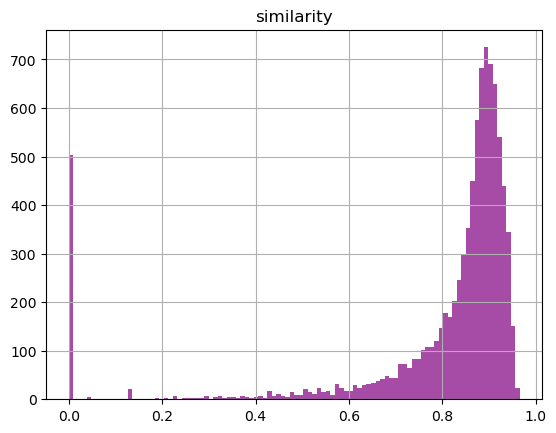

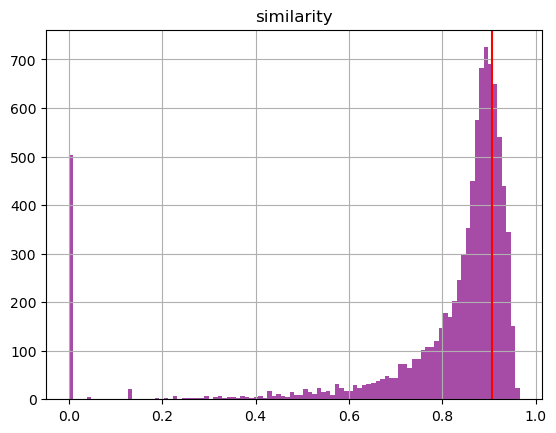

Similarity at 75-th percentile : 0.906791175361063
Number of records of the new screened dataset : 2234


In [5]:
# Histogram about similarty between skills and job posted 

df = pd.read_csv(DATASET_FOLDER+'/dataset.csv')
df_subset_3 = df[['similarity']]
df_subset_3.hist(alpha = 0.7,color='purple',bins=100)
plt.show()

#Let's suppose to consider all the CV with a similarty larger then the 75-th quartile.

df_subset_3 = df[['similarity']]
df_subset_3.hist(alpha = 0.7,color='purple',bins=100)
plt.axvline(x=df_subset_3.quantile(q=0.75)["similarity"],color='red')
plt.show()

print ("Similarity at 75-th percentile : "+str(df_subset_3.quantile(q=0.75)["similarity"]))
print ("Number of records of the new screened dataset : "+str(df_subset_3[(df_subset_3["similarity"]>0.906791175361063)]["similarity"].count()) )

ds_screened=df[(df["similarity"]>0.906791175361063)]

### Additional data reduction

In [39]:
#This part could maybe avoided if used the latest generations of Generative-AI techniques like GPT-3.
#This part is added in order to find a solution of this previous generation of AI-tool, like Spacy.

#Considering mandatory the following skills emerged by job_post:
# - attended a university and to have a degree 
# - at least 3 years of experience
# - knowledge of python and programming

#The dataset could be additionaly reduced.

ds_screened=ds_screened[(ds_screened["university"]==1) & (ds_screened["num_of_degrees"]>0) & (ds_screened["years_working_experience"]>3) & (ds_screened["python"]==1)]
ds_screened.to_csv(DATASET_FOLDER+'/datasetScreened.csv', index=False)
ds_screened

,full_name,working,travelling_experiences,working_experiences,years_working_experience,certifications,university,num_of_degrees,accomplishment_projects,accomplishment_courses,...,android,apple,ai,tensorflow,nlp,networking,security,cloud,test,team
1,Aaroh Mathur,1,0,8,7.38,4,1,2,8,14,...,1,0,1,1,1,0,0,0,1,1
2,Aakash Shah,1,0,14,21.89,2,1,2,7,11,...,0,0,1,0,1,1,0,1,1,1
3,Aaksha Jaywant,1,0,6,3.98,2,1,4,0,0,...,0,1,0,0,0,0,0,0,1,0
5,Aakash Sudhakar,1,0,12,9.77,1,1,5,6,0,...,0,1,0,0,1,1,0,1,1,1
6,Aaron Alphonsus,1,0,14,8.16,0,1,3,1,16,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2139,Aaron Broom,1,0,5,10.24,2,1,1,0,0,...,0,0,0,0,0,0,0,1,0,1
2143,Abdullah Al Mamun,1,0,6,8.91,9,1,4,2,0,...,0,1,0,0,0,0,0,0,0,0
2155,Aadesh Randeria,1,0,6,9.07,2,1,2,35,8,...,1,1,0,0,0,1,1,1,1,1
2157,Artur Stypułkowski,1,0,4,6.31,2,1,2,0,0,...,0,0,0,0,0,0,0,0,0,1


### Analisis on cleaned data 

In [43]:
#Plot of interesting graphs
df = pd.read_csv(DATASET_FOLDER+'/datasetScreened.csv')
df.describe()

,working,travelling_experiences,working_experiences,years_working_experience,certifications,university,num_of_degrees,accomplishment_projects,accomplishment_courses,accomplishment_patents,...,android,apple,ai,tensorflow,nlp,networking,security,cloud,test,team
count,484.0,484.0,484.000000,484.000000,484.000000,484.0,484.000000,484.000000,484.000000,484.000000,...,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000
mean,1.0,0.0,6.772727,9.413843,2.454545,1.0,2.268595,3.157025,5.444215,0.080579,...,0.171488,0.169421,0.219008,0.078512,0.066116,0.402893,0.256198,0.318182,0.640496,0.745868
std,0.0,0.0,2.900346,5.362200,4.298876,0.0,1.052536,4.518668,7.545239,0.998817,...,0.377324,0.375512,0.414002,0.269255,0.248741,0.490987,0.436984,0.466252,0.480352,0.435823
min,1.0,0.0,1.000000,3.060000,0.000000,1.0,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,0.0,5.000000,5.950000,0.000000,1.0,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.0,0.0,6.000000,7.905000,1.000000,1.0,2.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,1.0,0.0,8.000000,10.982500,3.000000,1.0,3.000000,5.000000,10.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.0,0.0,20.000000,33.090000,38.000000,1.0,7.000000,35.000000,35.000000,21.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


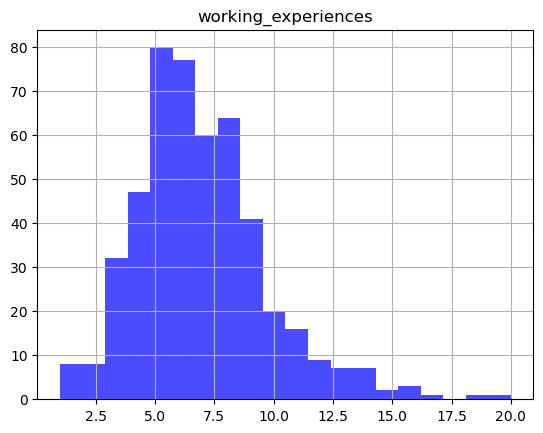

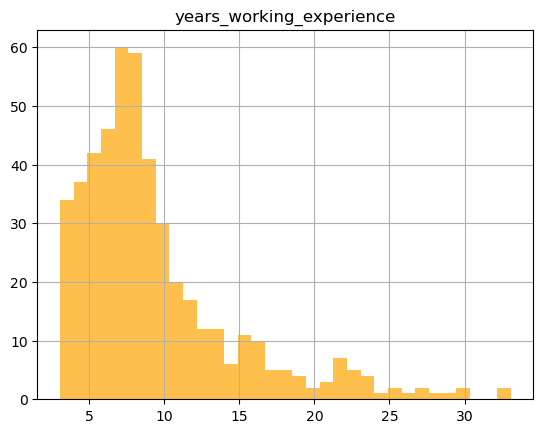

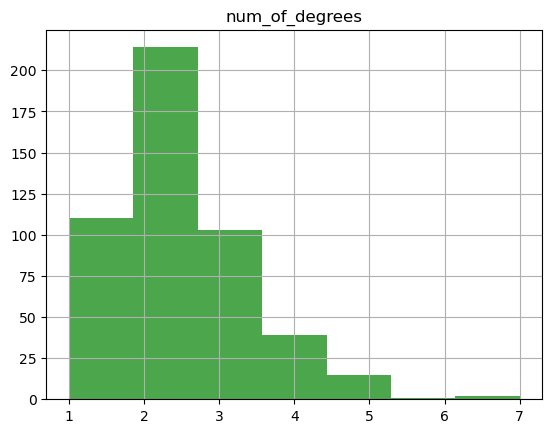

In [44]:
#Bar chart of working experiences

df_subset_1 = df[["working_experiences"]]
df_subset_2 = df[['years_working_experience']]

df_subset_1.hist(alpha = 0.7,color='blue',bins=20)
plt.show()

#Bar chart of years experiences 

df_subset_2.hist(alpha = 0.7,color='orange',bins=33)
plt.show()

# Barchart about level of instruction of candidates

df_subset_3 = df[['num_of_degrees']]
df_subset_3.hist(alpha = 0.7,color='green',bins=7)
plt.show()



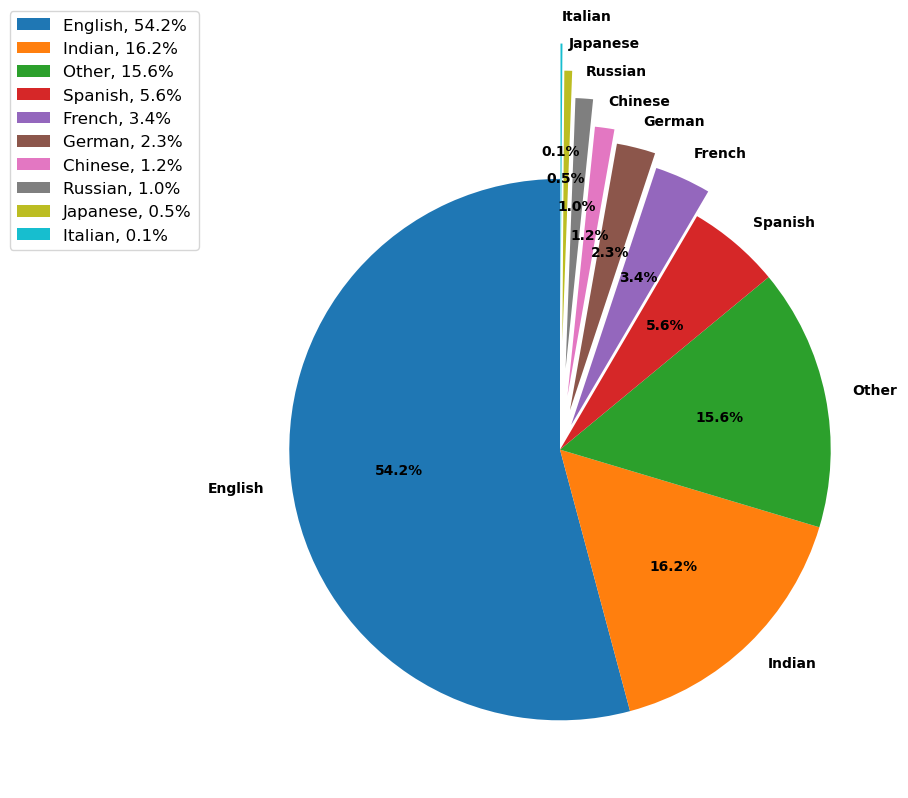

<Figure size 4000x4000 with 0 Axes>

In [46]:
plotting_functions.plot_perc_lang_spoken(df)

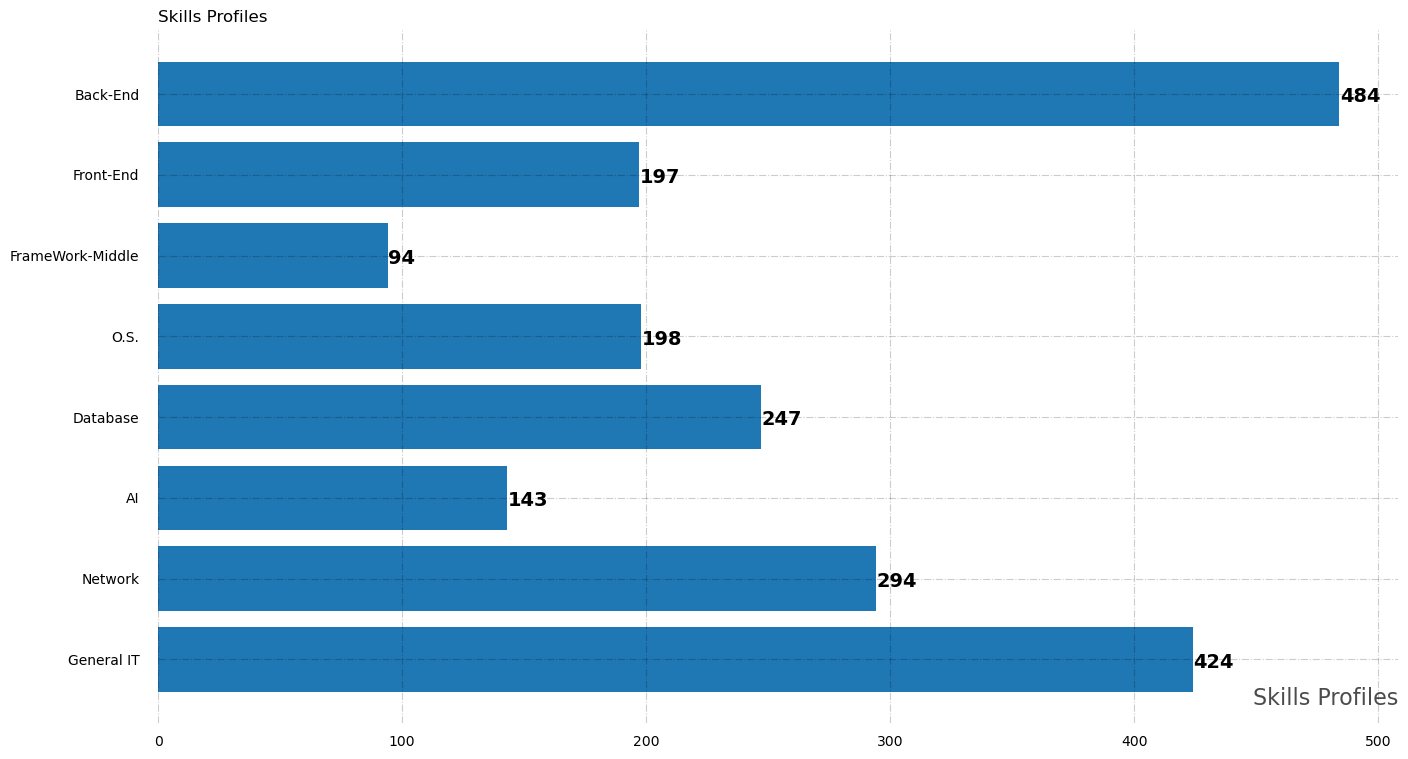

In [47]:
#Looking at particular skills of an IT profile.
plotting_functions.plot_skills(df)

# Selection of candidates: clustering

In [14]:
#Nr of candidatares: from (intial) 10000 to 484 (end)
df = pd.read_csv(DATASET_FOLDER+'/datasetScreened.csv')
df = general_utilities.aggregateSkills(df)

## 1° Business Question 

### Identification of groups of possible future employees with the aim of proposing an adequate salary based on their educational background and years of working experience

In [15]:
#Giving a value to education summing the number of degrees + the nr. of courses/100 + the nr. of certifications /500
df["education_score"]=df["num_of_degrees"]+(df["accomplishment_courses"]/100)+(df["certifications"]/500)

In [16]:
#Define a normalization method to be applied on numerical columns before clustering.
# z=(xi-u)/std_dev
scaler=StandardScaler()

In [17]:
# Removing non-numerical columns and similarity added column
colDiff=df.columns.difference(['full_name','skills_descriptions','skills_processed','similarity'])
newDf = df.loc[ : , colDiff]

In [18]:
#Appling Standard scaler on all the numberical columns
scaled_data = scaler.fit_transform(newDf)

In [19]:
scaled_df = pd.DataFrame(scaled_data, columns=newDf.columns)
scaled_df=scaled_df.add_suffix('_t')
scaled_df

,.net_t,AI_t,Backend_t,Database_t,Frontend_t,General_t,LANG_CH_t,LANG_DE_t,LANG_EN_t,LANG_FR_t,...,sql_t,team_t,tensorflow_t,test_t,travelling_experiences_t,university_t,windows_t,working_t,working_experiences_t,years_working_experience_t
0,-0.331801,1.544220,0.0,0.979548,1.207002,0.376177,-0.145248,-0.207614,0.1849,-0.25246,...,1.156790,0.583712,3.425907,0.749193,0.0,0.0,-0.17259,0.0,0.423585,-0.379685
1,-0.331801,1.544220,0.0,0.979548,-0.828499,0.376177,-0.145248,-0.207614,0.1849,-0.25246,...,-0.864461,0.583712,-0.291893,0.749193,0.0,0.0,-0.17259,0.0,2.494444,2.329093
2,-0.331801,-0.647576,0.0,-1.020879,-0.828499,0.376177,-0.145248,-0.207614,0.1849,-0.25246,...,-0.864461,-1.713172,-0.291893,0.749193,0.0,0.0,-0.17259,0.0,-0.266702,-1.014409
3,-0.331801,1.544220,0.0,0.979548,1.207002,0.376177,-0.145248,-0.207614,0.1849,-0.25246,...,1.156790,0.583712,-0.291893,0.749193,0.0,0.0,-0.17259,0.0,1.804157,0.066489
4,-0.331801,-0.647576,0.0,-1.020879,1.207002,0.376177,-0.145248,-0.207614,0.1849,-0.25246,...,-0.864461,0.583712,-0.291893,0.749193,0.0,0.0,-0.17259,0.0,2.494444,-0.234072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,-0.331801,-0.647576,0.0,-1.020879,-0.828499,0.376177,-0.145248,-0.207614,0.1849,-0.25246,...,-0.864461,0.583712,-0.291893,-1.334769,0.0,0.0,-0.17259,0.0,-0.611845,0.154230
480,-0.331801,-0.647576,0.0,-1.020879,-0.828499,-2.658320,-0.145248,-0.207614,0.1849,-0.25246,...,-0.864461,-1.713172,-0.291893,-1.334769,0.0,0.0,-0.17259,0.0,-0.266702,-0.094059
481,-0.331801,-0.647576,0.0,0.979548,1.207002,0.376177,-0.145248,-0.207614,0.1849,-0.25246,...,1.156790,0.583712,-0.291893,0.749193,0.0,0.0,-0.17259,0.0,-0.266702,-0.064190
482,-0.331801,-0.647576,0.0,0.979548,-0.828499,0.376177,-0.145248,4.816638,0.1849,-0.25246,...,1.156790,0.583712,-0.291893,-1.334769,0.0,0.0,-0.17259,0.0,-0.956988,-0.579436


In [20]:
newDf = df[["education_score","years_working_experience"]]
scaled_data = scaler.fit_transform(newDf)
scaled_df = pd.DataFrame(scaled_data, columns=newDf.columns)
scaled_df=scaled_df.add_suffix('_t')


merged_df = pd.merge(df, scaled_df, left_index=True, right_index=True)
merged_df.describe()

# Identify duplicate rows
duplicates = merged_df[merged_df.duplicated(subset=['education_score', 'years_working_experience'],keep=False)]
# Save duplicate rows to a new DataFrame
duplicate_df = duplicates.copy()

merged_df=merged_df.drop_duplicates(subset=['education_score', 'years_working_experience'],keep='first')
merged_df

,full_name,working,travelling_experiences,working_experiences,years_working_experience,certifications,university,num_of_degrees,accomplishment_projects,accomplishment_courses,...,MiddleWare,OS,Database,AI,Networks,General,Total,education_score,education_score_t,years_working_experience_t
0,Aaroh Mathur,1,0,8,7.38,4,1,2,8,14,...,0,0,1,1,0,1,1,2.148,-0.170105,-0.379685
1,Aakash Shah,1,0,14,21.89,2,1,2,7,11,...,1,1,1,1,1,1,1,2.114,-0.202246,2.329093
2,Aaksha Jaywant,1,0,6,3.98,2,1,4,0,0,...,0,0,0,0,0,1,1,4.004,1.584394,-1.014409
3,Aakash Sudhakar,1,0,12,9.77,1,1,5,6,0,...,0,0,1,1,1,1,1,5.002,2.527815,0.066489
4,Aaron Alphonsus,1,0,14,8.16,0,1,3,1,16,...,0,0,0,0,0,1,1,3.160,0.786550,-0.234072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,Aaron Broom,1,0,5,10.24,2,1,1,0,0,...,0,0,0,0,1,1,1,1.004,-1.251542,0.154230
480,Abdullah Al Mamun,1,0,6,8.91,9,1,4,2,0,...,0,0,0,0,0,0,1,4.018,1.597628,-0.094059
481,Aadesh Randeria,1,0,6,9.07,2,1,2,35,8,...,1,1,1,0,1,1,1,2.084,-0.230605,-0.064190
482,Artur Stypułkowski,1,0,4,6.31,2,1,2,0,0,...,0,0,1,0,0,1,1,2.004,-0.306230,-0.579436


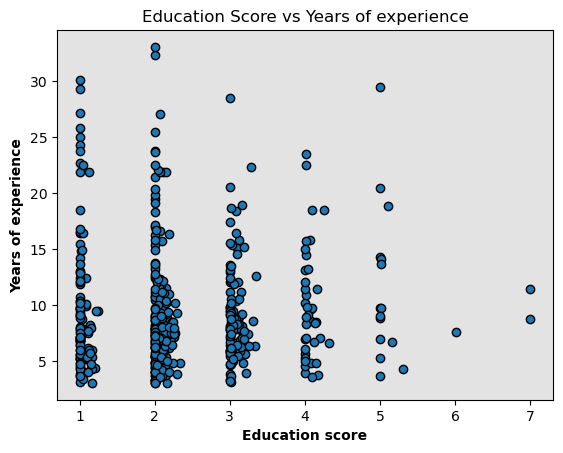

In [21]:
plotting_functions.drawScatterPlot(df["education_score"],df["years_working_experience"],"Education Score vs Years of experience","Education score","Years of experience")   

### Determing cluster tendency: Hopikins Statistic test

In [22]:
# Since multiple calls of the function will result in different values of H, 
# the function is called and compute Hopkins' Statistic multiple times, and taken its average.

print("First trial of Hopkins test:"+str(clust.hopkins_statistic(merged_df[scaled_df.columns])))

l = [] #list to hold values for each call
for i in range(100):
    H=clust.hopkins_statistic(merged_df[scaled_df.columns])
    l.append(H)
#print average value:
mean=np.mean(l)
print ("mean = ",mean)
if (mean>0.75):
    print ("There is a clustering tendency at the 90% confidence level.")


First trial of Hopkins test:0.9290272054491141
mean =  0.888145806840042
There is a clustering tendency at the 90% confidence level.


### K-Means

C:\Users\Davide\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


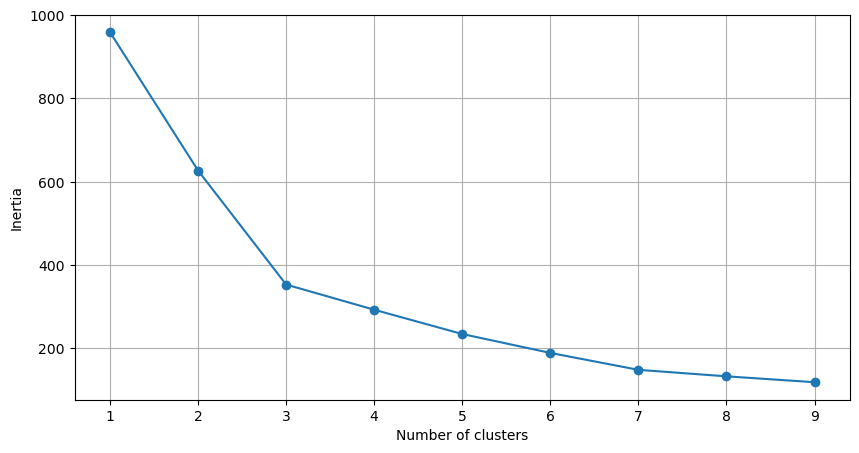

In [23]:
### Identify the optimum number of clusters
clust.optimise_k_means(merged_df[scaled_df.columns],10)

In [26]:
kmeans=KMeans(n_clusters=3)
kmeans.fit_predict(merged_df[scaled_df.columns])
kmeans.labels_=clust.orderClusterDescending(kmeans.labels_)
merged_df["kmeans_cluster"]=kmeans.labels_

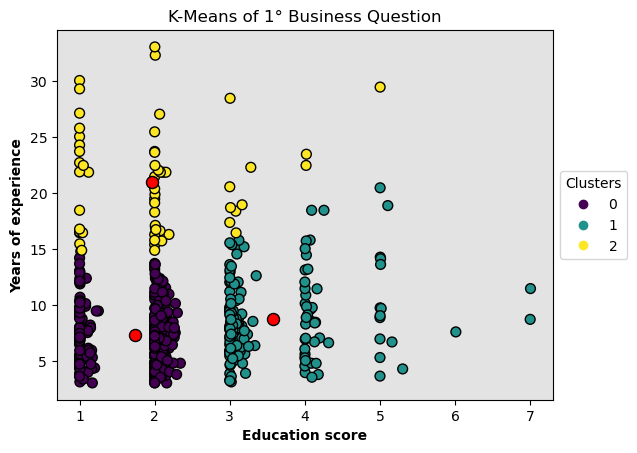

Silhouette score:0.47374707199979477


In [27]:
plotting_functions.plot_clusters(merged_df[["education_score","years_working_experience"]]
                                 ,merged_df["kmeans_cluster"],
                                 scaler.inverse_transform(kmeans.cluster_centers_),
                                 "K-Means of 1° Business Question",
                                 "Education score",
                                 "Years of experience")
score = silhouette_score(merged_df[["education_score_t","years_working_experience_t"]], merged_df["kmeans_cluster"], metric='euclidean')
print("Silhouette score:"+str(score))

### DBSCAN

In [104]:
#Try to use DBSCAN in order to see if a better result can be achived.

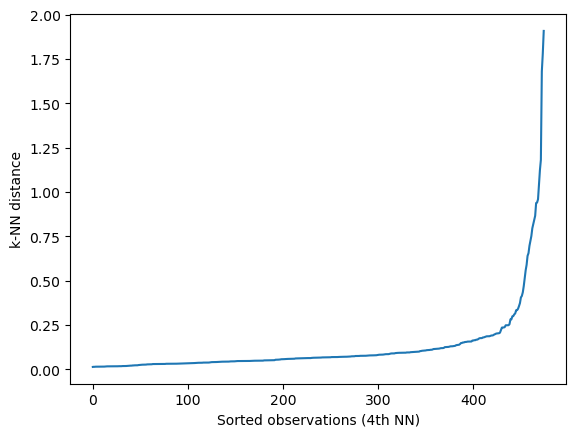

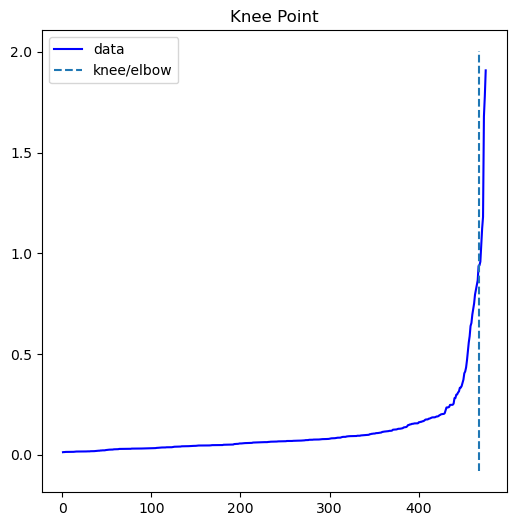

0.9376225808569064


In [144]:
best_eps=clust.find_opt_eps(merged_df[["education_score_t","years_working_experience_t"]])
print(best_eps)

In [145]:
list_eps = [round(i, 2) for i in list(np.arange(0.25, 0.93, 0.01))]
numPoints=[i for i in range(4, 8)]
best_dict=clust.gridSearchOptCluster(merged_df[["education_score_t","years_working_experience_t"]],list_eps,numPoints)
best_dict

{'best_score': 0.6082699834822528, 'best_eps': 0.92, 'best_minPoints': 4}

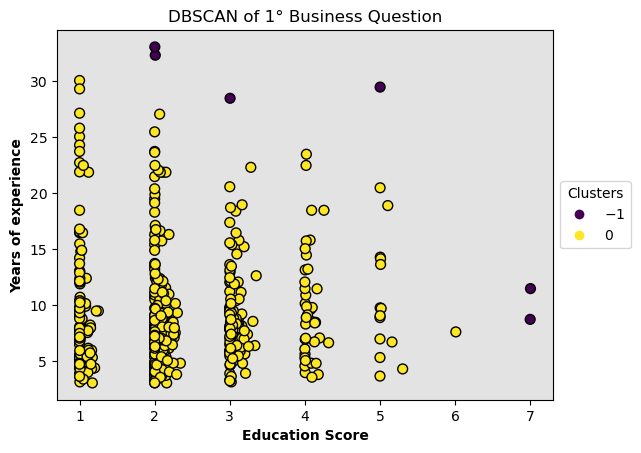

In [146]:
clusters = DBSCAN(eps = best_dict["best_eps"], min_samples = best_dict["best_minPoints"]).fit(merged_df[["education_score_t","years_working_experience_t"]])
merged_df["DBScan_cluster"]=clusters.labels_
plotting_functions.plot_clusters(merged_df[["education_score","years_working_experience"]],clusters.labels_,None,"DBSCAN of 1° Business Question","Education Score","Years of experience")

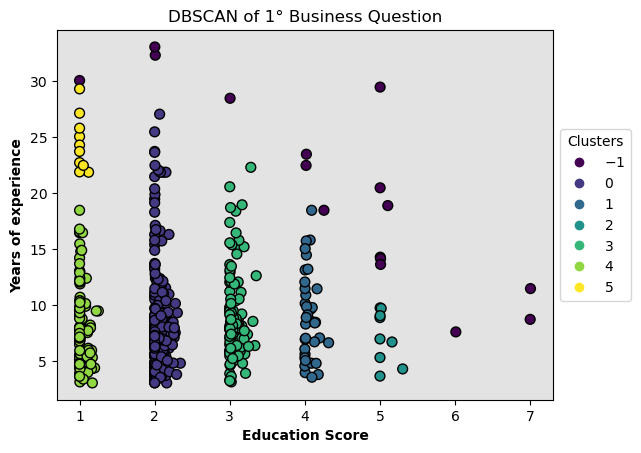

Silhouette score:0.34016895485020543


In [147]:
#Changing the values of eps, choosing manually a lower value.
clusters = DBSCAN(eps = 0.50, min_samples = best_dict["best_minPoints"]).fit(merged_df[["education_score_t","years_working_experience_t"]])

plotting_functions.plot_clusters(merged_df[["education_score","years_working_experience"]],clusters.labels_,None,"DBSCAN of 1° Business Question","Education Score","Years of experience")
score = silhouette_score(merged_df[["education_score_t","years_working_experience_t"]], clusters.labels_, metric='euclidean')
print("Silhouette score:"+str(score))

## Analisis of the results on K-means

In [ ]:
#The two algorithms' behaviour is different and the most significant result can be seen on k-means. 

In [148]:
#Assign cluster_number to duplicates.

for index1, row1 in duplicate_df.iterrows():
    for index2, row2 in merged_df.iterrows():
        if (row1["full_name"]==row2["full_name"]):
            break   
        if (row1["education_score"]==row2["education_score"] and row1["years_working_experience"]==row2["years_working_experience"]):
            duplicate_df.at[index1, 'kmeans_cluster']=row2["kmeans_cluster"]
            break
duplicate_df=duplicate_df.dropna()
merged_df = pd.concat([merged_df, duplicate_df], ignore_index=True)            

,Total,LANG_EN%,LANG_IN%,LANG_OT%,LANG_SP%,LANG_FR%,LANG_DE%,LANG_CH%
kmeans_cluster,,,,,,,,
0.0,277,95.67,30.32,27.08,9.75,6.50,4.69,2.17
1.0,149,97.99,34.23,33.56,12.08,6.71,4.70,2.68
2.0,57,98.25,7.02,15.79,5.26,1.75,0.00,0.00


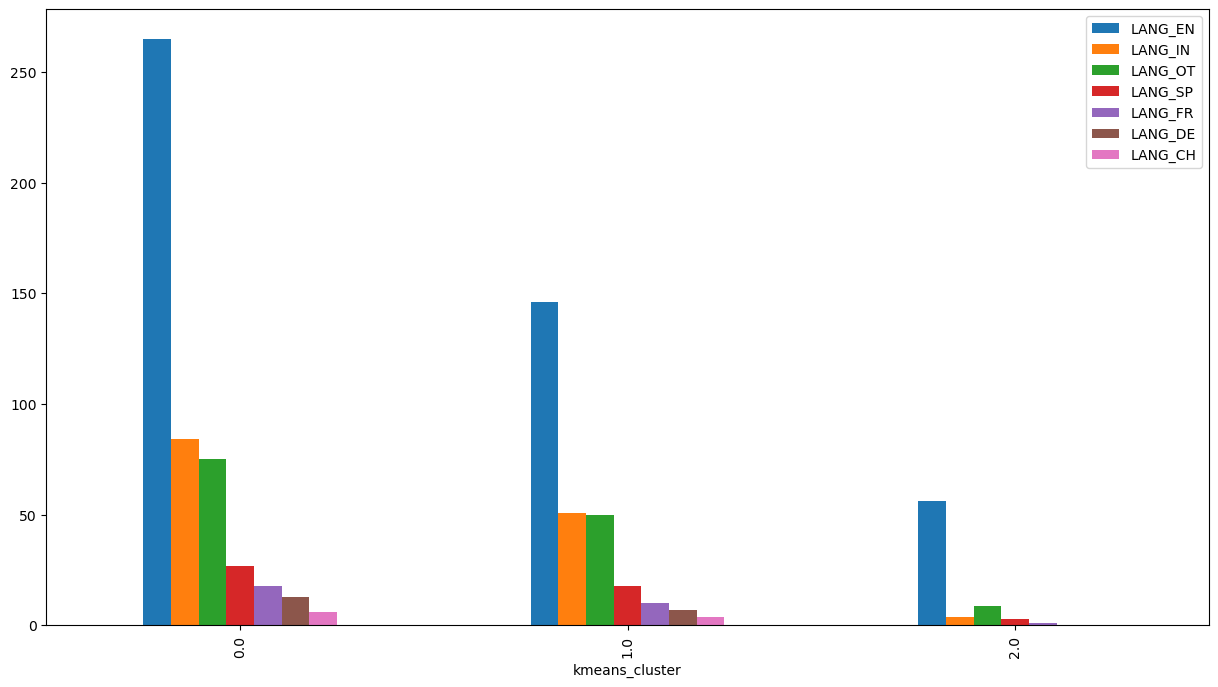

In [149]:
plotting_functions.plotPercentagesLanguagesForEachCluster(merged_df,"kmeans_cluster")

,Total,Frontend%,MiddleWare%,OS%,Database%,AI%,Networks%,General%
kmeans_cluster,,,,,,,,
0.0,277,43.32,19.49,19.49,50.90,27.44,59.21,85.56
1.0,149,37.58,16.78,16.78,53.02,34.90,60.40,89.93
2.0,57,35.09,26.32,26.32,45.61,24.56,68.42,91.23


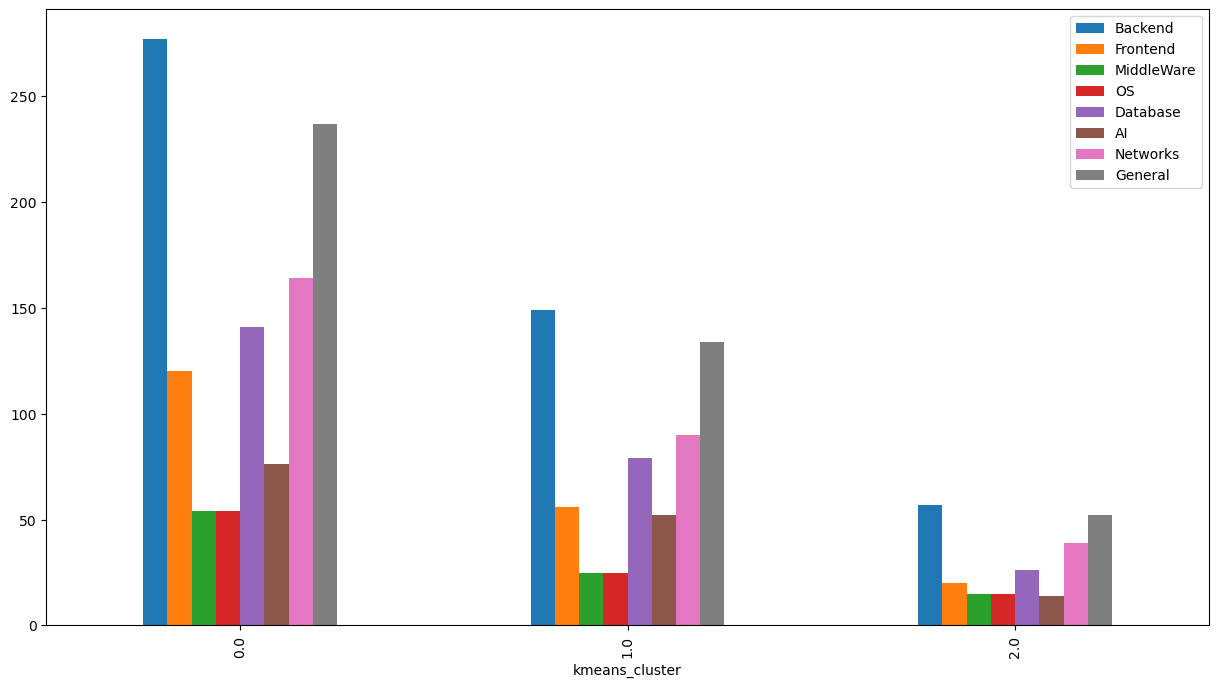

In [150]:
plotting_functions.plotPercentagesSkillsForEachCluster(merged_df,"kmeans_cluster")

## 2° Business Question 

### Identification of groups of possible future employees able to work in a multilanguage team on different topics (based on the skills)

In [3]:
#Nr of candidatares: from (intial) 10000 to 484 (end)
df = pd.read_csv(DATASET_FOLDER+'/datasetScreened.csv')
df = general_utilities.aggregateSkills(df)
df=general_utilities.give_weights_to_languages_and_skills(df)

[{'lang': 'LANG_EN', 'count': 468, 'weight': 0.1}, {'lang': 'LANG_IN', 'count': 140, 'weight': 0.2}, {'lang': 'LANG_OT', 'count': 135, 'weight': 0.3}, {'lang': 'LANG_SP', 'count': 48, 'weight': 0.4}, {'lang': 'LANG_FR', 'count': 29, 'weight': 0.5}, {'lang': 'LANG_DE', 'count': 20, 'weight': 0.6}, {'lang': 'LANG_CH', 'count': 10, 'weight': 0.7}, {'lang': 'LANG_RU', 'count': 9, 'weight': 0.8}, {'lang': 'LANG_JP', 'count': 4, 'weight': 0.9}, {'lang': 'LANG_IT', 'count': 1, 'weight': 1.0}]


[{'skill': 'General', 'count': 424, 'weight': 0.14}, {'skill': 'Networks', 'count': 294, 'weight': 0.29}, {'skill': 'Database', 'count': 247, 'weight': 0.43}, {'skill': 'Frontend', 'count': 197, 'weight': 0.57}, {'skill': 'AI', 'count': 143, 'weight': 0.71}, {'skill': 'MiddleWare', 'count': 94, 'weight': 0.86}, {'skill': 'OS', 'count': 94, 'weight': 1.0}]


In [4]:
scaler=StandardScaler()
newDf = df[["skillScore","langScore"]]
scaled_data = scaler.fit_transform(newDf)
scaled_df = pd.DataFrame(scaled_data, columns=newDf.columns)
scaled_df=scaled_df.add_suffix('_t')


merged_df = pd.merge(df, scaled_df, left_index=True, right_index=True)
merged_df.describe()

# Identify duplicate rows
duplicates = merged_df[merged_df.duplicated(subset=['skillScore', 'langScore'],keep=False)]
# Save duplicate rows to a new DataFrame
duplicate_df = duplicates.copy()

merged_df=merged_df.drop_duplicates(subset=['skillScore', 'langScore'],keep='first')
merged_df


,full_name,working,travelling_experiences,working_experiences,years_working_experience,certifications,university,num_of_degrees,accomplishment_projects,accomplishment_courses,...,OS,Database,AI,Networks,General,Total,skillScore,langScore,skillScore_t,langScore_t
0,Aaroh Mathur,1,0,8,7.38,4,1,2,8,14,...,0,1,1,0,1,1,7.40,1.054545,0.288820,-0.219801
1,Aakash Shah,1,0,14,21.89,2,1,2,7,11,...,1,1,1,1,1,1,20.58,1.272727,2.389878,0.386373
2,Aaksha Jaywant,1,0,6,3.98,2,1,4,0,0,...,0,0,0,0,1,1,0.14,1.018182,-0.868516,-0.320830
3,Aakash Sudhakar,1,0,12,9.77,1,1,5,6,0,...,0,1,1,1,1,1,10.70,1.018182,0.814882,-0.320830
4,Aaron Alphonsus,1,0,14,8.16,0,1,3,1,16,...,0,0,0,0,1,1,1.42,1.018182,-0.664467,-0.320830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,Aaron Caruso,1,0,7,3.06,5,1,1,1,16,...,0,0,0,0,1,1,0.14,1.072727,-0.868516,-0.169286
464,Aaren Twedt,1,0,8,13.66,4,1,2,0,0,...,0,0,0,1,1,1,0.86,1.436364,-0.753738,0.841004
465,"Aahan Zindani, EIT",1,0,5,9.16,0,1,3,0,0,...,0,0,0,0,0,1,0.00,2.254545,-0.890833,3.114157
472,Aarifa (Ari) Gowani,1,0,8,7.91,2,1,3,0,0,...,0,0,0,0,1,1,1.42,1.127273,-0.664467,-0.017743


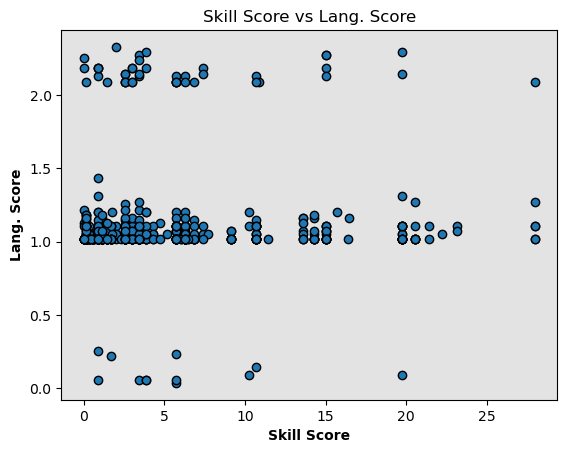

In [5]:
plotting_functions.drawScatterPlot(df["skillScore"],df["langScore"],"Skill Score vs Lang. Score","Skill Score","Lang. Score")   

### Determing cluster tendency: Hopikins Statistic test

In [6]:
# Since multiple calls of the function will result in different values of H, 
# the function is called and compute Hopkins' Statistic multiple times, and taken its average.

print("First trial of Hopkins test:"+str(clust.hopkins_statistic(merged_df[scaled_df.columns])))

l = [] #list to hold values for each call
for i in range(100):
    H=clust.hopkins_statistic(merged_df[scaled_df.columns])
    l.append(H)
#print average value:
mean=np.mean(l)
print ("mean = ",mean)
if (mean>0.75):
    print ("There is a clustering tendency at the 90% confidence level.")

First trial of Hopkins test:0.8565316386952257
mean =  0.8447692207692556
There is a clustering tendency at the 90% confidence level.


### K-Means

C:\Users\Davide\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


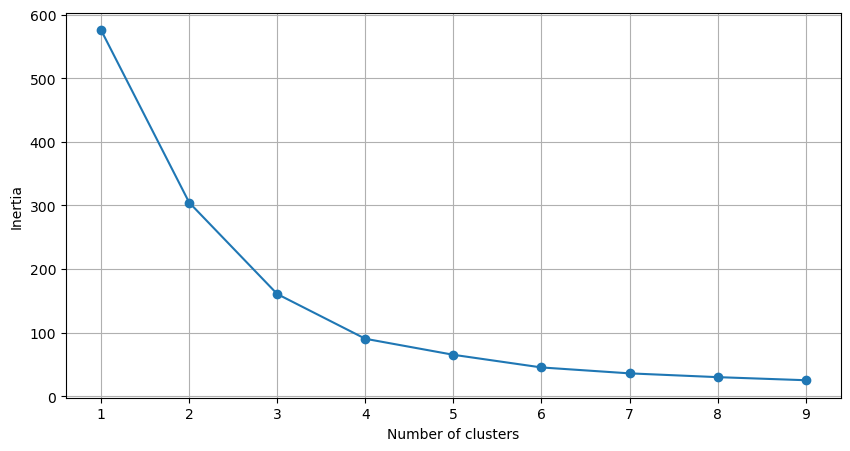

In [7]:
clust.optimise_k_means(merged_df[scaled_df.columns],10)

In [12]:
kmeans=KMeans(n_clusters=4)
kmeans.fit_predict(merged_df[scaled_df.columns])
kmeans.labels_=clust.orderClusterDescending(kmeans.labels_)
merged_df["kmeans_cluster"]=kmeans.labels_

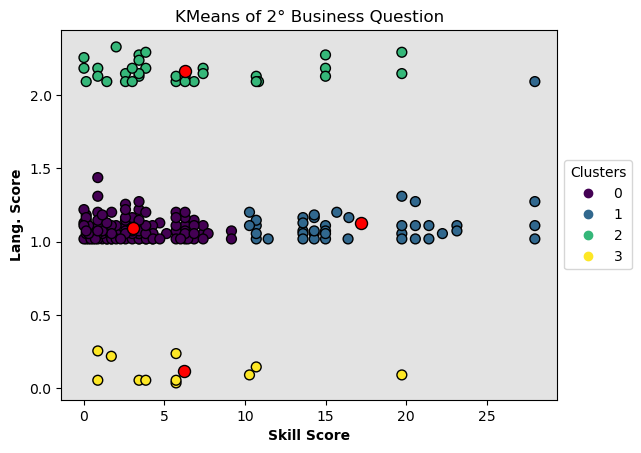

Silhouette score:0.6711452966771533


In [13]:
plotting_functions.plot_clusters(merged_df[["skillScore","langScore"]]
                                 ,merged_df["kmeans_cluster"],
                                 scaler.inverse_transform(kmeans.cluster_centers_),
                                 "KMeans of 2° Business Question",
                                 "Skill Score",
                                 "Lang. Score")
score = silhouette_score(merged_df[["skillScore_t","langScore_t"]], merged_df["kmeans_cluster"], metric='euclidean')
print("Silhouette score:"+str(score))

### DBSCAN

In [ ]:
#Even the siluhette score gives a good result, the DB scan is also used to discovery more interesting clusters.

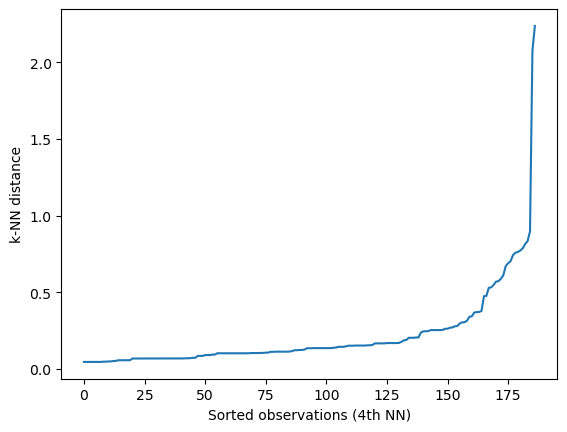

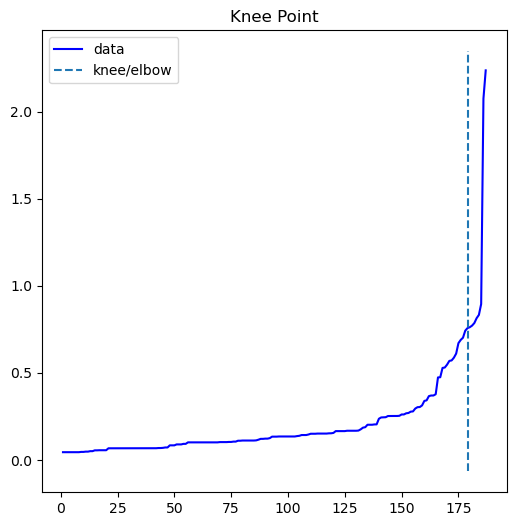

0.7573024394265683


In [14]:
#Using 4 as minPoints value.
best_eps=clust.find_opt_eps(merged_df[["skillScore_t","langScore_t"]])
print(best_eps)

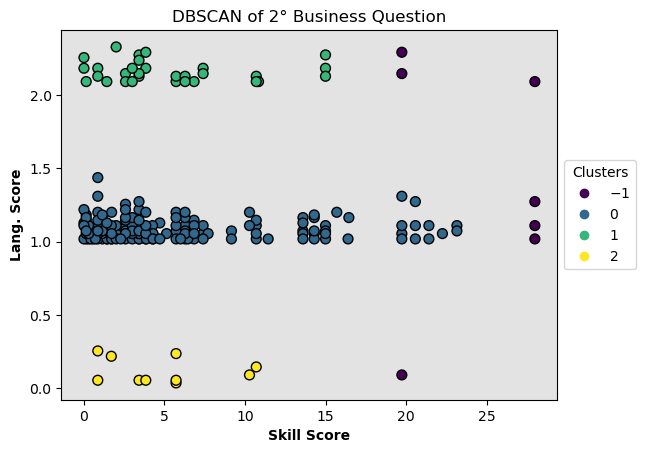

In [16]:
clusters = DBSCAN(eps = 0.75, min_samples = 4).fit(merged_df[["skillScore_t","langScore_t"]])
merged_df["DBScan_cluster"]=clusters.labels_
plotting_functions.plot_clusters(merged_df[["skillScore","langScore"]],clusters.labels_,None,"DBSCAN of 2° Business Question","Skill Score","Lang. Score")

#The distinction that emarges is only based on nr of languages. Not other useful cluster can be detected with this values.
#In the next part, I tried to play with eps and minPoints values.

In [23]:
#Using a grid search with empirical values.
list_eps = [round(i, 2) for i in list(np.arange(0.20, 0.30, 0.01))]
numPoints=[3]
best_dict=clust.gridSearchOptCluster(merged_df[["skillScore_t","langScore_t"]],list_eps,numPoints)
best_dict

{'best_score': 0.5086307524302117, 'best_eps': 0.29, 'best_minPoints': 3}

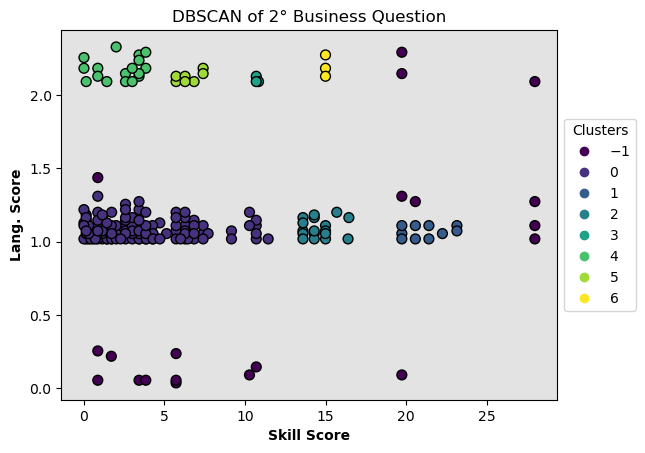

In [24]:
clusters = DBSCAN(eps = best_dict["best_eps"], min_samples = best_dict["best_minPoints"]).fit(merged_df[["skillScore_t","langScore_t"]])
merged_df["DBScan_cluster"]=clusters.labels_
plotting_functions.plot_clusters(merged_df[["skillScore","langScore"]],clusters.labels_,None,"DBSCAN of 2° Business Question","Skill Score","Lang. Score")

In [25]:
#Assign cluster_number to duplicates.
for index1, row1 in duplicate_df.iterrows():
    for index2, row2 in merged_df.iterrows():
        if (row1["full_name"]==row2["full_name"]):
            break   
        if (row1["skillScore"]==row2["skillScore"] and row1["langScore"]==row2["langScore"]):
            duplicate_df.at[index1, 'DBScan_cluster']=row2["DBScan_cluster"]
            break
duplicate_df=duplicate_df.dropna()
merged_df = pd.concat([merged_df, duplicate_df], ignore_index=True)   

,Total,Frontend%,MiddleWare%,OS%,Database%,AI%,Networks%,General%
DBScan_cluster,,,,,,,,
-1.0,23,69.57,52.17,52.17,78.26,47.83,78.26,100.00
0.0,357,33.33,4.20,4.20,44.82,28.29,56.02,84.87
1.0,27,77.78,100.00,100.00,92.59,40.74,96.30,92.59
2.0,34,58.82,100.00,100.00,58.82,20.59,64.71,97.06
3.0,3,66.67,33.33,33.33,66.67,100.00,66.67,100.00
4.0,24,33.33,0.00,0.00,41.67,16.67,62.50,87.50
5.0,10,80.00,0.00,0.00,90.00,50.00,80.00,100.00
6.0,4,75.00,100.00,100.00,75.00,25.00,25.00,100.00


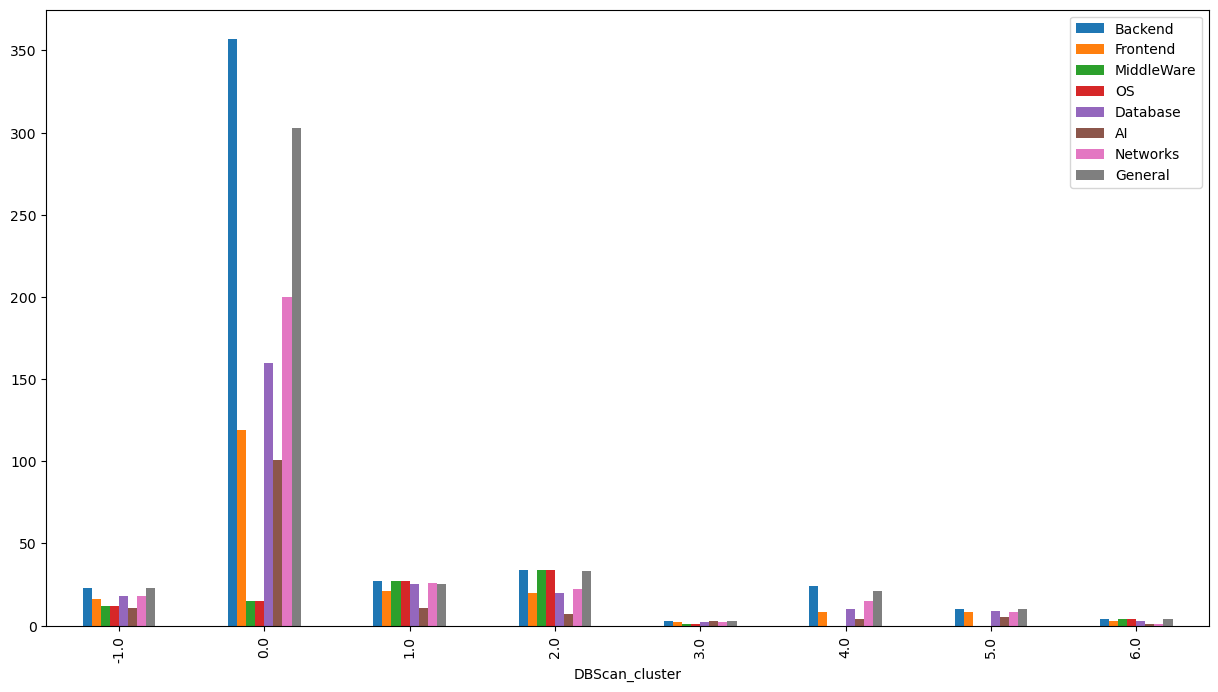

In [20]:
plotting_functions.plotPercentagesSkillsForEachCluster(merged_df,"DBScan_cluster")

,Total,LANG_EN%,LANG_IN%,LANG_OT%,LANG_SP%,LANG_FR%,LANG_DE%,LANG_CH%
DBScan_cluster,,,,,,,,
-1.0,23,47.83,26.09,65.22,13.04,26.09,13.04,4.35
0.0,357,99.16,28.29,24.09,0.84,4.76,3.08,1.68
1.0,27,100.00,40.74,33.33,0.00,0.00,0.00,0.00
2.0,34,97.06,20.59,26.47,2.94,8.82,8.82,0.00
3.0,3,100.00,33.33,0.00,100.00,0.00,0.00,0.00
4.0,24,100.00,37.50,45.83,100.00,12.50,12.50,4.17
5.0,10,100.00,30.00,20.00,100.00,0.00,0.00,0.00
6.0,4,100.00,50.00,75.00,100.00,0.00,0.00,50.00


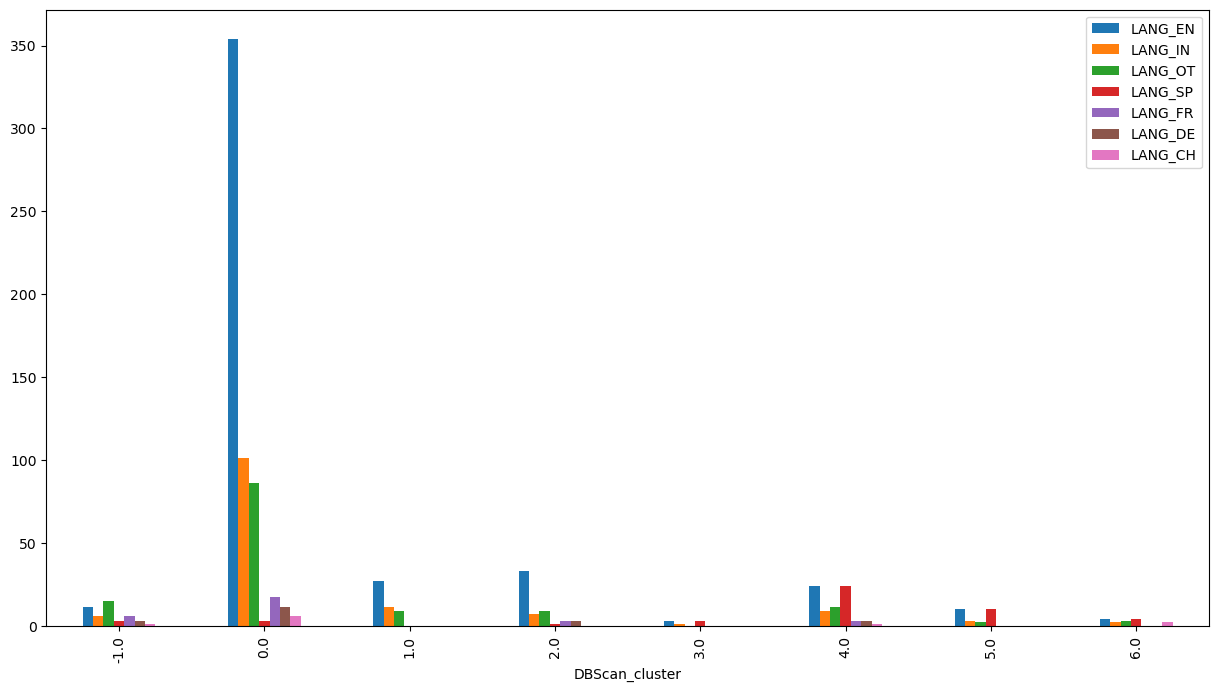

In [21]:
plotting_functions.plotPercentagesLanguagesForEachCluster(merged_df,"DBScan_cluster")